**Navigating the Nexus of Health and Wealth**: A Survival Analysis Model for Chronic Disease Management, Cost Efficiency, and Quality Care in Health Insurance

Authors: Scott Howard, Mu Miao, Esther Xu


<a name="toc"></a>

# Table of Contents

- [Introduction](#intro-1)

- [Set-up and Dependencies](#dependencies-1)

- [Framework for Analyzing Time-to-Event Data](#background)

- [Medical Claims and Administrative Data](#claim-admin)

  - [CMS Data Entreprenuers' Synthetic Data](#cms-data)

  - [Cox-PH Model](#cox-ph)

  - [Non-linear Survival Analysis with Neural Networks](#nn)

- [Worcester Heart Study Data](#whas)
  
  - [Cox-PH Model](#cox-ph-whas)

  - [Non-linear Survival Analysis with Neural Networks](#nn-whas)

- [Conclusion](#conclusion)


- [References](#references-1)

<a name="intro-1"></a>
# Introduction

Health insurance organizations have a dual purpose: to ensure the health and well-being of their participating members while maintaining financial sustainability and profitability. We propose a survival analysis model, specifically one using Cox proportional hazards regression (Cox-PH), to identify members who have been diagnosed with a chronic disease—and/or members with a comorbidity—and are most at risk of death. A well performing model could lead to improved quality of care for health plan members and bring significant financial benefits to health insurers. We've identified 4 key areas of opportunity that are highly relevant to health insurers: Enhanced Preventive Care and Improved Quality of Care, Profitability and Resource Optimization, Financial Forecasting and Improved Risk Stratification, and Federal Reimbursements.

**Enhanced Preventive Care and Improved Quality of Care**. Survival analysis and the Cox model can help to identify the most significant predictors of adverse health events, this can lead to the development of personalized care plans and targeted preventive care strategies (e.g. a “house-call” program for a segment of a health plan's Medicaid enrollees). Additionally, proactively Identifying health plan members at high risk of sickness/death can help manage their conditions more effectively, potentially slowing disease progression, improving their quality of life, and even extending their lifespan.

**Profitability and Resource Optimization**. Identifying health plan members most at risk of death is not only crucial for their health but also for the financial health of the organization managing their care. Members with chronic diseases and comorbidities often require extensive medical care, leading to high costs. By identifying these members early, health insurers can implement preventive measures and disease management programs that can reduce hospitalizations, emergency room visits, as well as other forms of resource-intensive high-cost care, thereby reducing overall healthcare costs. In addition, improved resource allocation where high-risk members can be prioritized for interventions, while low-risk members can be monitored less intensively ensures that resources are used where they are most needed, improving efficiency and potentially reducing costs.

**Financial Forecasting and Improved Risk Stratification**. Our proposed model can aid in financial forecasting. By predicting the number and timing of adverse events, health insurers can estimate future healthcare costs. This can inform pricing strategies, ensuring that premiums cover expected costs. Furthermore, by identifying factors that influence the time to an event (e.g., hospitalization, cancer recurrence, death), health plan members can be stratified into different risk categories. This proactive identification of risk can help insurers reduce their Medical Loss Ratio (MLR). The MLR is a metric established by the Affordable Care Act (ACA) that represents the percentage of insurance premium dollars that a health insurer spends on healthcare and quality improvement activities, compared to administrative costs, marketing, and profits. If an insurer does not meet these MLR standards, they are required to provide rebates to policyholders. Therefore, a lower MLR can be advantageous for insurers as it means they are spending less on healthcare costs relative to the premiums they collect, reducing the likelihood of having to issue rebates.

**Federal Reimbursements**. Our proposed model can also increase federal reimbursement to health insurers from programs such as the Healthcare Effectiveness Data and Information Set (HEDIS). HEDIS measures the performance of health plans on various dimensions of care and service. By improving care for individuals with chronic diseases who are most at risk of death, health plans can improve HEDIS scores, which can lead to higher federal reimbursements.

The flexibility of our model and it's applicability to real-life scenarios can provide valuable insights into treatment effectiveness, risk assessment, and resource optimization.


<a name="dependencies-1"></a>
# Set-up and Dependencies

In [ ]:
#!pip install scikit-survival lifelines SurvSet torchtuples pycox

In [ ]:
# Python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML #display(HTML(response))
import itertools

# Statistical libraries
from statsmodels.formula.api import glm
import statsmodels.api as sm
from scipy.stats import chi2_contingency, chi2, ttest_ind, f_oneway
from patsy import dmatrices

# scikit-survival
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored
from sksurv.datasets import load_whas500
from sksurv.preprocessing import OneHotEncoder
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis #, CoxTimeVaryingSurvivalAnalysis
from lifelines.exceptions import ConvergenceError

# ML libraries
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
#from pycox.models import CoxPH
import pycox
from pycox.evaluation import EvalSurv
import torch.optim as optim

# Survival Analysis
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

# Datasets
from SurvSet.data import SurvLoader
surv_loader = SurvLoader()

# increase max rows, max columns, max column width
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 150)

import warnings
warnings.simplefilter('ignore')

n_random_state = 42


## Connect to Google Drive

In [ ]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Data"

# cms_data_dir = f'{root_dir}/CMS_Synthetic_Data'
# os.listdir(cms_data_dir)

Mounted at /content/gdrive


## Connect to Local Directory

In [ ]:
# root_dir = f'../Data/cms_synthetic_data'

<a name="background"></a>
# Framework for Analyzing Time-to-Event Data
[Back to Top](#toc)

## The Survival Function

In survival analysis, the survival function (or survival curve), often denoted by $S(t)$, is used to describe the probability that a subject will survive past time $t$. It is related to the cumulative distribution function (cdf) of the survival times $F(t)$ and can be expressed as:

$$S(t) = 1 - F(t) = P(T > t)$$

where,

- $T$ represents the random variable for the time until an event (such as death or failure) occurs, and

- $P(T > t)$ is the probability that the event occurs after time $t$.

This decreasing function quantifies the probability that the subject will survive past time $t$.

## Kaplan-Meier (KM) Method

The Kaplan-Meier (KM) method is a popular method used in survival analysis to estimate the survival function. It's especially valuable in medical/population health research, where it is often used to understanding patient survival over time. We use it in our analysis to understand the different survival curves between cohorts (e.g. males compared to females). A description of its main features and characteristics is provided below:

**Censoring**: One of the unique features of the Kaplan-Meier method is its ability to handle right-censored data. Censoring occurs when the exact time of an event is not known for some subjects (e.g., they may drop out of a study before the event occurs). The KM estimator appropriately accounts for these censored observations.

**Non-Parametric**: The Kaplan-Meier method is a non-parametric estimation technique, meaning that it doesn't assume any underlying statistical distribution for the survival times. This flexibility allows it to be used with various types of data.

**Estimation**: The Kaplan-Meier estimator provides a stepwise estimation of the survival function $S(t)$. It's a product-limit estimator, and the equation is given by:

   $$\hat{S}(d_k) = \prod_{j=1}^{k} \left(\frac{r_j-q_j}{r_j}\right)$$

where,

- **$k$**: The number of unique death times among the non-censored patients up to time $d_k$.

- **$\hat{S}(d_k)$**: This is the estimated survival function at the $k$-th unique death time $d_k$. It represents the probability that a subject survives longer than time $d_k$.

- $r_j$: The number of subjects at risk just before the $j$-th death time. This includes all individuals who have not yet had the event of interest or been censored before time $d_j$.
   
- $q_j$: The number of subjects who died at the $j$-th death time. This is the number of events (e.g., deaths) that occurred at time $d_j$.

- The fraction $\frac{r_j-q_j}{r_j}$ calculates the proportion of subjects who survived the $j$-th death time, given that they were at risk just before that time.

**Curve Representation**: The Kaplan-Meier survival curve is a step function that decreases stepwise at each time an event occurs. It starts at 1 (indicating 100% survival) and declines over time, reflecting the proportion of the population surviving as time progresses.

**Confidence Intervals**: Confidence intervals can be calculated around the Kaplan-Meier estimate to provide a range of plausible values for the survival function.

**Comparison**: The Kaplan-Meier method can be used in conjunction with statistical tests (such as the log-rank test) to compare survival functions between different groups.

## Proportional Hazards Assumption

The proportional hazards assumption is a critical assumption in survival analysis. It implies that the hazard ratios (e.g., $\exp(\beta_1))$ are constant over time, meaning that the relative risk between different levels of a covariate stays the same throughout the study period. In other words, the risk of the event occurring in one group relative to another stays the same throughout the study period. If this assumption is violated, the results of the analysis may be biased.

## Cox's Proportional Hazards Regression Model (Cox-PH)

Cox-PH is a widely used statistical method in survival analysis. It's particularly useful for understanding the relationship between the survival time of subjects and one or more predictor variables. The Cox-PH model is expressed through the hazard function, which describes the instantaneous risk of the event occurring at time $t$, given survival until that time. The equation for the hazard function in the Cox model is given by:

$$
h(t, \mathbf{x}) = h_0(t) \exp\biggr(\sum_{j=1}^{p}x_{ij} \beta_{j}\biggr),
$$

where $h_{0}(t)\ge0$is an unspecified function, known as the baseline hazard. It is "unspecified" in that it makes no assumptions about its functional form. Instead of specifying the form of the baseline hazard function, the method uses partial likelihood, a technique that separates the effect of the covariates from the baseline hazard. This allows for estimation of the $\beta$ coefficients without needing to know the baseline hazard.

**Model Interpretation**

The coefficients in the Cox model can be interpreted as the log hazard ratios for a one-unit increase in the corresponding covariate. Exponentiating the coefficients gives the hazard ratios, which represent the multiplicative effect on the hazard for a one-unit change in the predictor.

**Extensions**

The model can be extended to handle time-dependent covariates, where the effect of a predictor changes over time (i.e., the hazard ratios are not constant over time). In our analysis we attempt to add neural net extension to Cox-PH where appropriate.


<a name="claim-admin"></a>
# Medical Claims and Administrative Data
[Back to Top](#toc)


Health insurance companies can utilize claims and administrative data systems to gain valuable insights into their members' health trends, behaviors, and needs. Claims data, which includes information on medical diagnoses, treatments, and costs, provides a detailed view of a patient's medical history. By analyzing this data, insurers can identify patterns and trends, such as prevalent diseases within a specific demographic or geographic location. Administrative data, on the other hand, encompasses information related to enrollment, demographics, and billing. This data can be used to understand the socio-economic factors influencing health, streamline billing processes, and enhance customer service. Together, claims and administrative data can be leveraged to create personalized health programs, forecast future healthcare needs, detect fraudulent activities, and optimize resource allocation. The integration and analysis of these data sets enable health insurance organizations to make informed decisions that can improve patient care, reduce costs, and enhance overall operational efficiency.

In our analysis we demonstrate how to perform feature engineering and transformations on synthetic medical claims and administrative data available through the Centers for Medicare & Medicaid Services' (CMS) public use files (described in more detail below). The knowledge of--and ability to process--claims and administrative data is essential for any entity offering products or services to health insurers. We believe our analysis will contribute to the understanding of these types of data.

We are including the CMS data in our analysis, not to draw meaningful inferential conclusions (due to the synthetic methods used in its creation), but for two main purposes: (1) to demonstrate our capability to engineer and transform this data into a format suitable for survival analysis models, and (2) to advocate a robust methodology for constructing a practical model for medical and claims data. This model can then be applied to real data stored by insurance companies.

To overcome the limitations of the CMS data, further analysis is performed on real (non-synthetic) datasets from which we can responsibly provide inferential conclusions.

---

<a name="cms-data"></a>
# CMS Data Entreprenuers' Synthetic Data
[Back to Top](#toc)




The Data Entrepreneurs' Synthetic Public Use File (PUF) was developed with the intention of offering a genuine set of public claims data while ensuring the utmost protection for Medicare beneficiaries' confidential health information. The PUF serves several purposes:

- It enables data entrepreneurs to create and design software and applications that could be used with real CMS claims data in the future.
- It provides training for researchers in handling and understanding the intricacies of working with CMS claims data before they begin the process of accessing the actual CMS data.
- It fosters secure data mining innovations that might uncover unexpected insights, all while maintaining the privacy of beneficiaries.

The PUF has been structured to ensure that programs and procedures developed with it will be compatible with CMS Limited Data Sets. While the Medicare PUF's data structure closely resembles that of the CMS Limited Data Sets, it includes fewer variables. Additionally, the PUF offers extensive metadata on CMS claims data that was previously unavailable to the public.

The PUF is a 5% representative sample (2.4 million individuals) of Medicare beneficiaries and their claims from 2008, 2009, and 2010. To protect privacy, the beneficiaries in the sample went through a stochastic de-identification process.

The PUF encompasses five types of datasets: Beneficiary Summary Files, Inpatient Claims, Outpatient Claims, Carrier Claims, and Prescription Drug Events. Please reference the supplemental notebook (LNM_Final_Supplemental_CMS_v009.ipynb) that provides a data dictionary for each file. The supplemental notebook also describes our process for data engineering a single dataframe, `cms_df`, that is used for our model.

## Load CMS (Engineered) Dataset

**Variables**

- `DESYNPUF_ID` Unique patient identifier (2,343 unique patients in file) for beneficiaries with heart disease

- `AGE` Age of beneficiary

- `SEX` Sex of beneficiary: ‘Male’; ‘Female’

- `RACE` 'White', 'Black', 'Others', 'Hispanic’

- `STATE` Code for US state where the beneficiary lives

- `DEPRESSION` Does the beneficiary suffer from depression

- `CHRNC_CON` Does the beneficiary have multiple chronic conditions: 1 yes; 2 no (if no then the patient only has heart disease

- `EVENT` Has a death occurred? 0 no death; 1 death

- `TOT_IP_ADMSN` Total inpatient hospital admissions (count data)

- `TOT_IP_COST` Total cost of hospital admission (continuous data)

- `TOT_OP_VISIT` Total outpatient visits (count data)

- `TOT_OP_COIN` Total cost of of patient outpatient visits (copays) (continuous data)

- `TOT_MEDS` Total number of medications taken by the beneficiary (from pharmacy claims)

- `TOT_DSPNSD` Total number of units (grams) of prescribed medications.


In [ ]:
cms_df = pd.read_csv(f"{root_dir}/cms_df.csv", sep=",", index_col=0)

print(cms_df.shape)

cms_df.head(1)

(2343, 14)


DESYNPUF_ID  AGE     SEX   RACE  STATE DEPRESSION  CHRNC_CON  EVENT  \
0  00151A878F9A2C0D   89  Female  White     33         No          1      0   

   TOT_IP_ADMSN  TOT_IP_COST  TOT_OP_VISIT  TOT_OP_COIN  TOT_MEDS  TOT_DSPNSD  
0           NaN          NaN           9.0       1370.0      73.0      3640.0

In [ ]:
event_col = 'EVENT'
time_col = 'AGE'

numeric_cols_without_time = ['TOT_IP_ADMSN', 'TOT_IP_COST', 'TOT_OP_VISIT',
                             'TOT_OP_COIN', 'TOT_MEDS', 'TOT_DSPNSD']

numeric_cols = numeric_cols_without_time + [time_col]

categorical_cols_without_event = ['SEX', 'RACE', 'DEPRESSION', 'CHRNC_CON', 'STATE']

categorical_cols = categorical_cols_without_event + [event_col]

In [ ]:
#### Check for missing variables

def missing_cols(df):
    # Count of missing values
    missing_count = df.isnull().sum()

    # Percentage of missing values
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Creating a DataFrame to show the results
    missing_data = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percentage (%)': missing_percentage
    })

    # Filter out only rows with missing values
    missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values(by='Missing Percentage (%)', ascending=False)

    return missing_data

In [ ]:
missing_cols(cms_df)

Missing Count  Missing Percentage (%)
TOT_IP_ADMSN           1712               73.068715
TOT_IP_COST            1712               73.068715
TOT_OP_VISIT            202                8.621426
TOT_OP_COIN             202                8.621426
TOT_MEDS                185                7.895860
TOT_DSPNSD              185                7.895860

### Section Summary

The total (TOT) columns contain null values, suggesting that certain patients might not have perscribed medications and/or have no hospitalizations. For example, columns such as `TOT_IP_ADMSN`, and `TOT_IP_COST` have the same count of nulls, suggesting there are no inpatient claims for these Medicare beneficiaries. Such nulls are normal for this type of data, but we will still need to appropriately handle these nulls in our analysis.

## Histograms

array([[<Axes: title={'center': 'AGE'}>,
        <Axes: title={'center': 'STATE'}>,
        <Axes: title={'center': 'CHRNC_CON'}>],
       [<Axes: title={'center': 'EVENT'}>,
        <Axes: title={'center': 'TOT_IP_ADMSN'}>,
        <Axes: title={'center': 'TOT_IP_COST'}>],
       [<Axes: title={'center': 'TOT_OP_VISIT'}>,
        <Axes: title={'center': 'TOT_OP_COIN'}>,
        <Axes: title={'center': 'TOT_MEDS'}>],
       [<Axes: title={'center': 'TOT_DSPNSD'}>, <Axes: >, <Axes: >]],
      dtype=object)

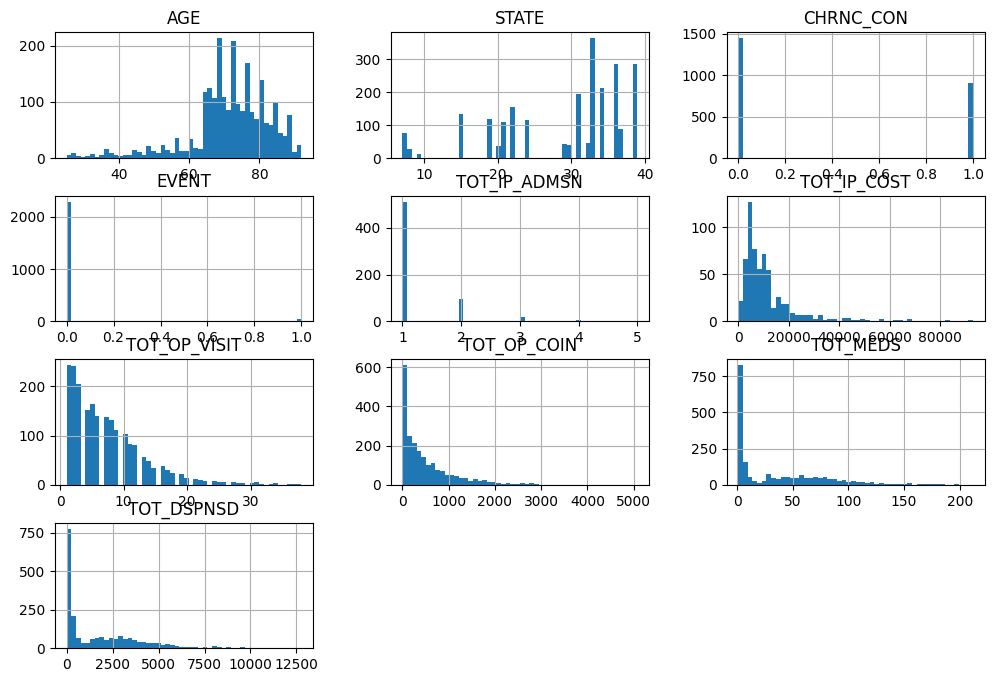

In [ ]:
cms_df.hist(bins=50, figsize=(12, 8))

## Categorical Variables - Plots

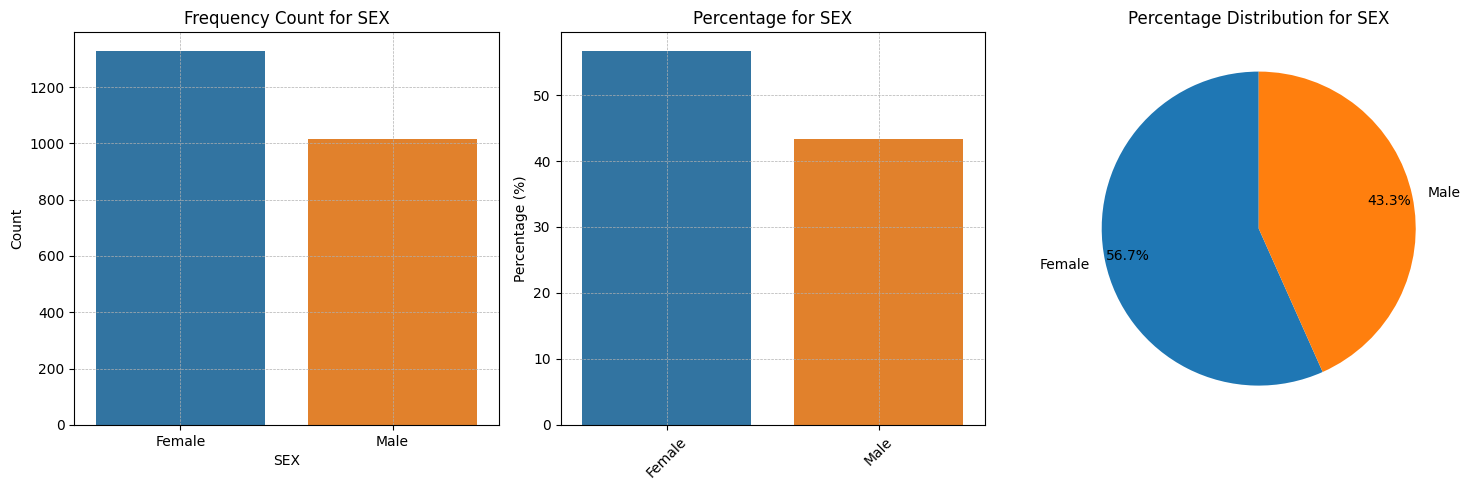

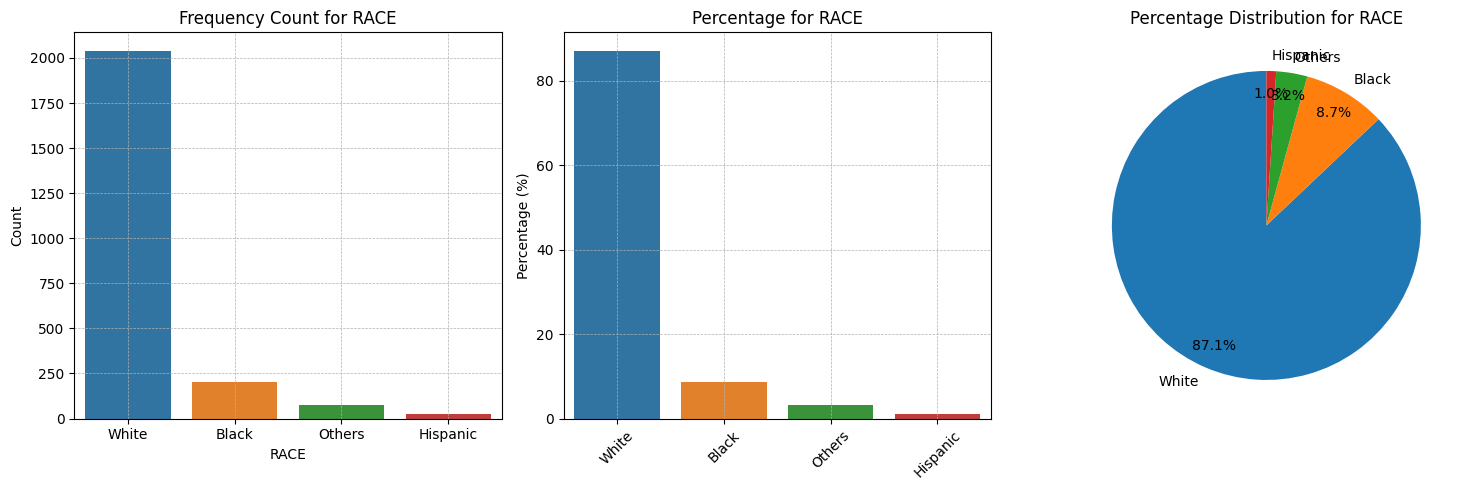

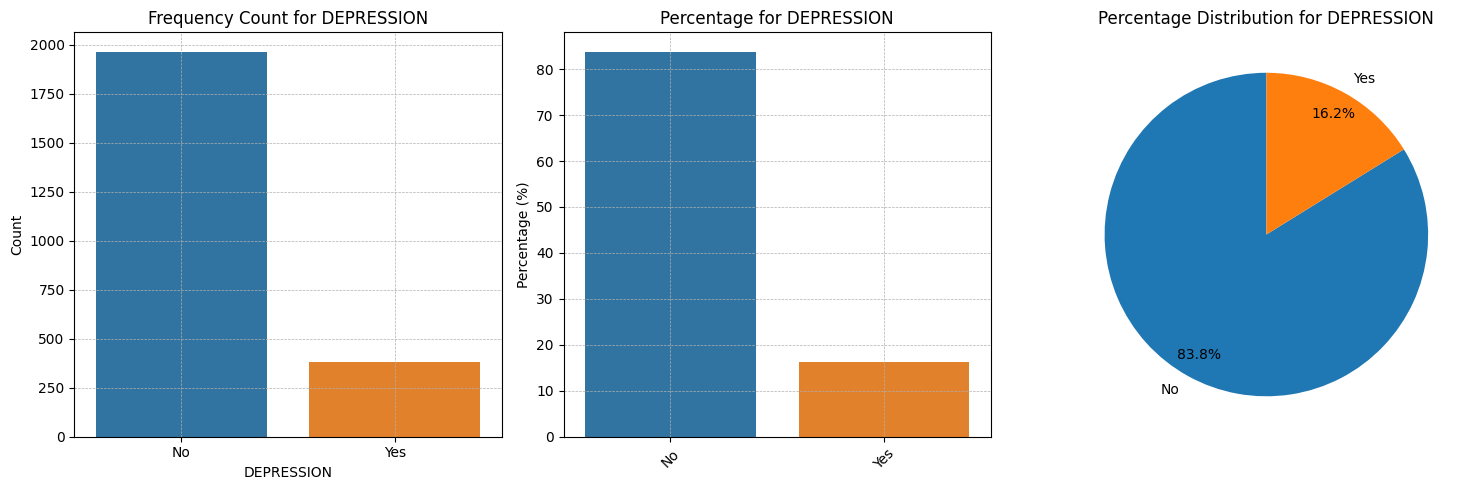

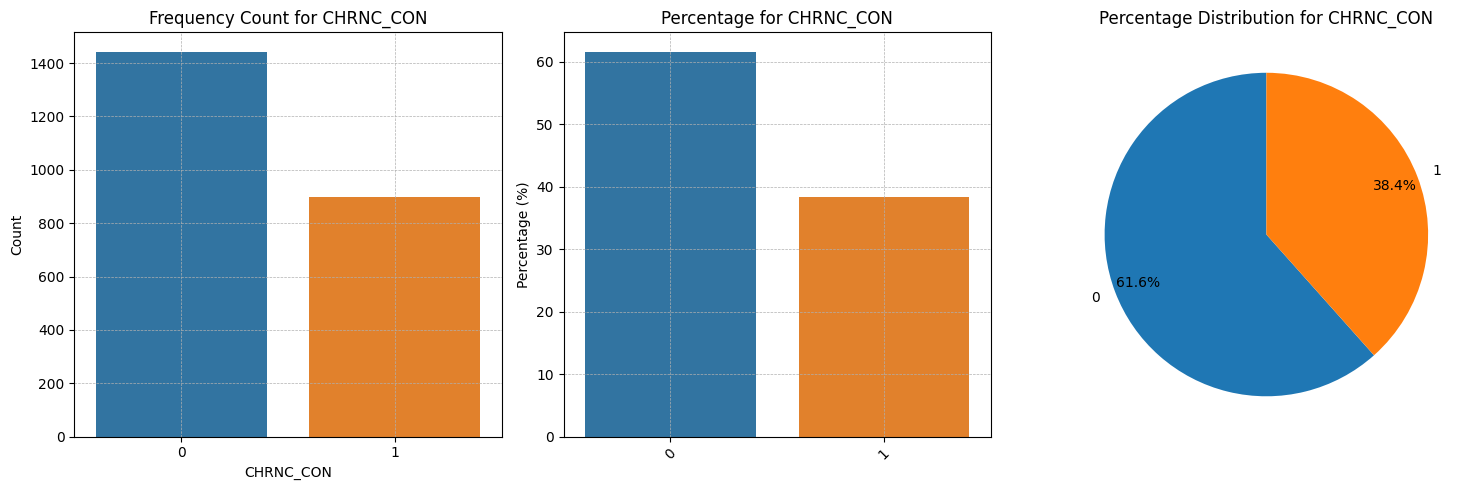

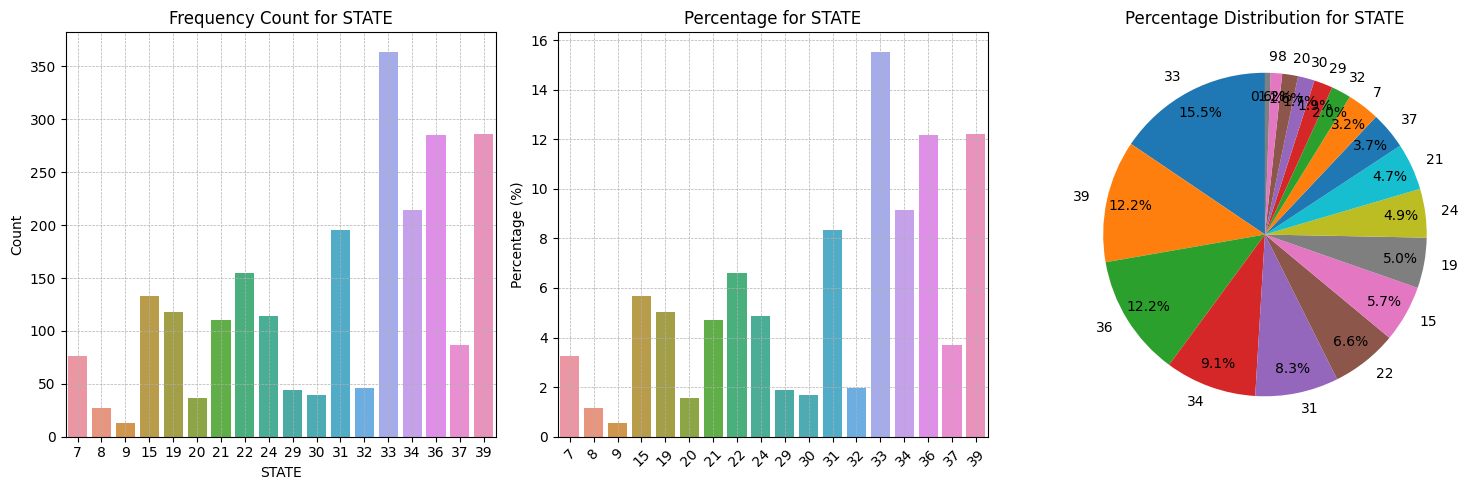

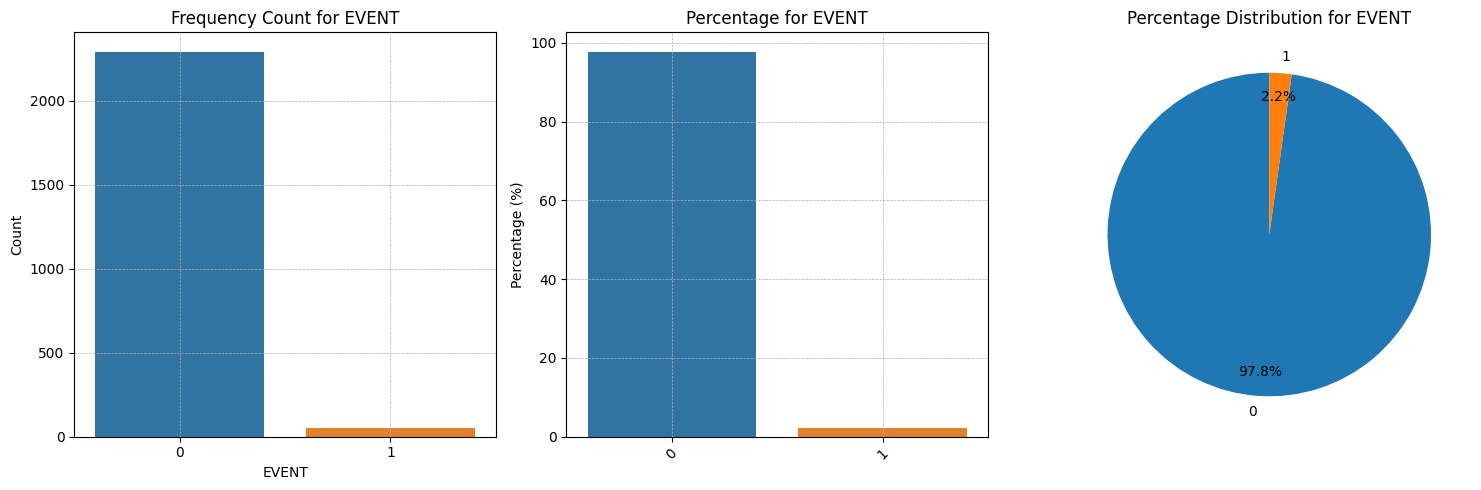

In [ ]:
def plot_categorical_cols(df, categorical_cols):
    for col in categorical_cols:
        plt.figure(figsize=(15, 5))

        # 1. Bar Chart for Frequency Count
        plt.subplot(1, 3, 1)
        sns.countplot(data=df, x=col)
        plt.title(f'Frequency Count for {col}')
        plt.ylabel('Count')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        # 2. Bar Chart for Percentage
        plt.subplot(1, 3, 2)
        sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts(normalize=True) * 100)
        plt.title(f'Percentage for {col}')
        plt.ylabel('Percentage (%)')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45)

        # 3. Pie Chart for Percentage Distribution
        plt.subplot(1, 3, 3)
        df[col].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', startangle=90, pctdistance=0.85)
        plt.title(f'Percentage Distribution for {col}')
        plt.ylabel('')

        # Display
        plt.tight_layout()
        plt.show()
        print("\n" + "="*100 + "\n")

plot_categorical_cols(cms_df, categorical_cols)

## Test Set

In [ ]:
# Class weights for `EVENT` Imbalance
weights = compute_class_weight('balanced', classes=cms_df[event_col].unique(), y=cms_df[event_col])
class_weights = {i: weights[i] for i in range(len(weights))}

In [ ]:
# Stratified Split
combined_cols = ["RACE", "SEX", "EVENT"]

cms_df['COMBINED_STRAT'] = cms_df[combined_cols].astype(str).agg('_'.join, axis=1)

print(cms_df['COMBINED_STRAT'].value_counts())

White_Female_0       1130
White_Male_0          864
Black_Female_0        115
Black_Male_0           83
Others_Female_0        45
Others_Male_0          30
White_Male_1           25
White_Female_1         21
Hispanic_Female_0      14
Hispanic_Male_0        10
Black_Male_1            3
Black_Female_1          2
Others_Female_1         1
Name: COMBINED_STRAT, dtype: int64


In [ ]:
# Remove the rows with 'Others_Female_1'
cms_df = cms_df[cms_df['COMBINED_STRAT'] != 'Others_Female_1']

# Split the data into Train and Test
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = n_random_state)

for train_index, test_index in sss.split(cms_df, cms_df['COMBINED_STRAT']):
    strat_train_set = cms_df.iloc[train_index]
    strat_test_set = cms_df.iloc[test_index]

# Drop the combined column post split
strat_train_set = strat_train_set.drop('COMBINED_STRAT', axis=1)
strat_test_set = strat_test_set.drop('COMBINED_STRAT', axis=1)
cms_df = cms_df.drop('COMBINED_STRAT', axis=1)

In [ ]:
# Check distribution of imbalanced variables

def compare_distributions(data, train_set, test_set, column):
    def get_proportions(data, column):
        return data[column].value_counts() / len(data)

    compare_props = pd.DataFrame({
        "Overall %": get_proportions(data, column),
        "Train %": get_proportions(train_set, column),
        "Test %": get_proportions(test_set, column),
    }).sort_index()

    compare_props.index.name = f"{column} Category"
    compare_props["Strat. Error %"] = (compare_props["Train %"] /
                                       compare_props["Overall %"] - 1)
    compare_props["Rand. Error %"] = (compare_props["Test %"] /
                                      compare_props["Overall %"] - 1)

    return compare_props

for cols in combined_cols:
    comparison = compare_distributions(cms_df, strat_train_set, strat_test_set, cols)
    print((comparison * 100).round(2))
    print("\n" + "="*100 + "\n")

               Overall %  Train %  Test %  Strat. Error %  Rand. Error %
RACE Category                                                           
Black               8.67     8.65    8.74           -0.21           0.86
Hispanic            1.02     1.01    1.07           -1.01           4.03
Others              3.20     3.20    3.20            0.03          -0.13
White              87.11    87.13   86.99            0.03          -0.13


              Overall %  Train %  Test %  Strat. Error %  Rand. Error %
SEX Category                                                           
Female            56.66     56.7    56.5            0.07          -0.28
Male              43.34     43.3    43.5           -0.09           0.36


                Overall %  Train %  Test %  Strat. Error %  Rand. Error %
EVENT Category                                                           
0                   97.82    97.81   97.87           -0.01           0.05
1                    2.18     2.19    2.13      

### Section Summary

Our event (deaths) covariate is heavily imbalanced. We account for this with the class weights technique. Additionally, to ensure a balanced representation of the `EVENT`, `RACE` and `SEX` columns in both the training and test sets, we employ the technique of stratification.

We discovered that the combination `Others_Female_1` appeared only once in the data before attempting the split. Given that the StratifiedShuffleSplit requires each class to have a minimum of two instances, we removed this particular class.

<a name="uni-bi"></a>
## Univariate and Bivariate Analysis
[Back to Top](#toc)

**Univariate**

In [ ]:
# Numeric variables
def plot_numeric_cols(df, numeric_cols):
    sns.set_style("whitegrid")
    palette = sns.color_palette("coolwarm", n_colors=len(numeric_cols))

    for idx, col in enumerate(numeric_cols):
        plt.figure(figsize=(12, 7))

        # Plotting the histogram with enhanced color palette
        ax = sns.histplot(df[col], kde=True, color=palette[idx])
        plt.title(f'Histogram for {col}', fontsize=18, fontweight='bold')
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        # Getting summary statistics
        stats = df[col].describe()

        # Annotate statistics on the plot
        # Marking mean
        plt.axvline(stats['mean'], color='red', linestyle='--')
        plt.text(stats['mean'], ax.get_ylim()[1]*0.9, 'Mean: {:.2f}'.format(stats['mean']), rotation=0, color='red', fontsize=12)

        # Marking median
        plt.axvline(stats['50%'], color='blue', linestyle='--')
        plt.text(stats['50%'], ax.get_ylim()[1]*0.8, 'Median: {:.2f}'.format(stats['50%']), rotation=0, color='blue', fontsize=12)

        # Marking std
        plt.axvline(stats['mean'] + stats['std'], color='orange', linestyle='--')
        plt.axvline(stats['mean'] - stats['std'], color='orange', linestyle='--')
        plt.text(stats['mean'] + stats['std'], ax.get_ylim()[1]*0.7, 'Std: +{:.2f}'.format(stats['std']), rotation=0, color='orange', fontsize=12)
        plt.text(stats['mean'] - stats['std'], ax.get_ylim()[1]*0.7, 'Std: -{:.2f}'.format(stats['std']), rotation=0, color='orange', fontsize=12)

        # Marking 25%
        plt.axvline(stats['25%'], color='green', linestyle='--')
        plt.text(stats['25%'], ax.get_ylim()[1]*0.6, '25%: {:.2f}'.format(stats['25%']), rotation=0, color='green', fontsize=12)

        # Marking 75%
        plt.axvline(stats['75%'], color='purple', linestyle='--')
        plt.text(stats['75%'], ax.get_ylim()[1]*0.5, '75%: {:.2f}'.format(stats['75%']), rotation=0, color='purple', fontsize=12)

        # Marking min & max (placed at the bottom)
        plt.text(stats['min'], ax.get_ylim()[1]*0.05, 'Min: {:.2f}'.format(stats['min']), rotation=0, color='grey', fontsize=12)
        plt.text(stats['max'], ax.get_ylim()[1]*0.05, 'Max: {:.2f}'.format(stats['max']), rotation=0, color='grey', fontsize=12)

        plt.show()
        print("\n" + "="*100 + "\n")


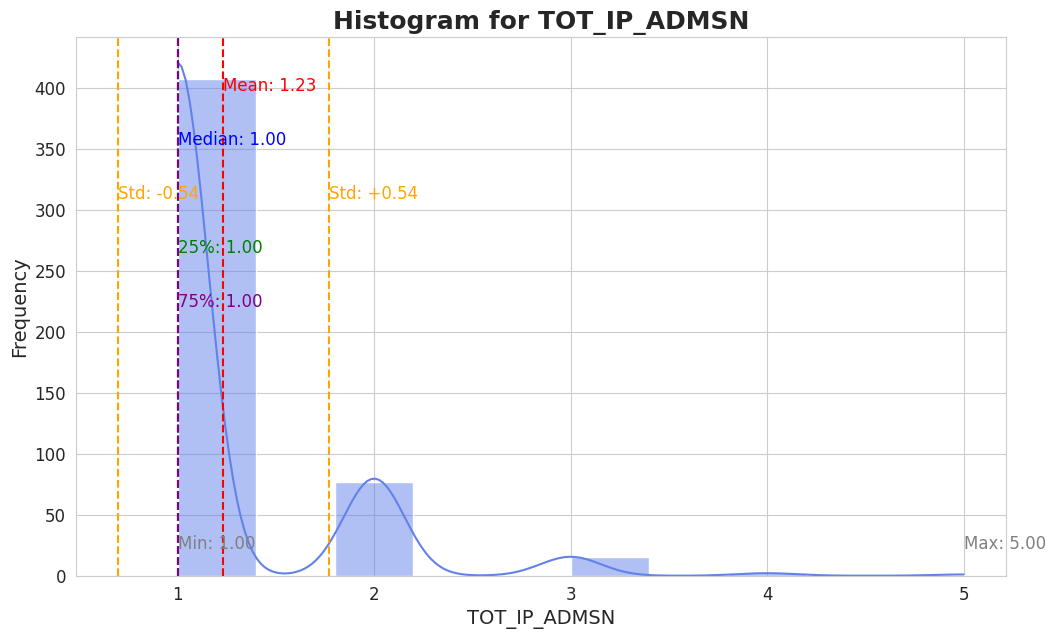

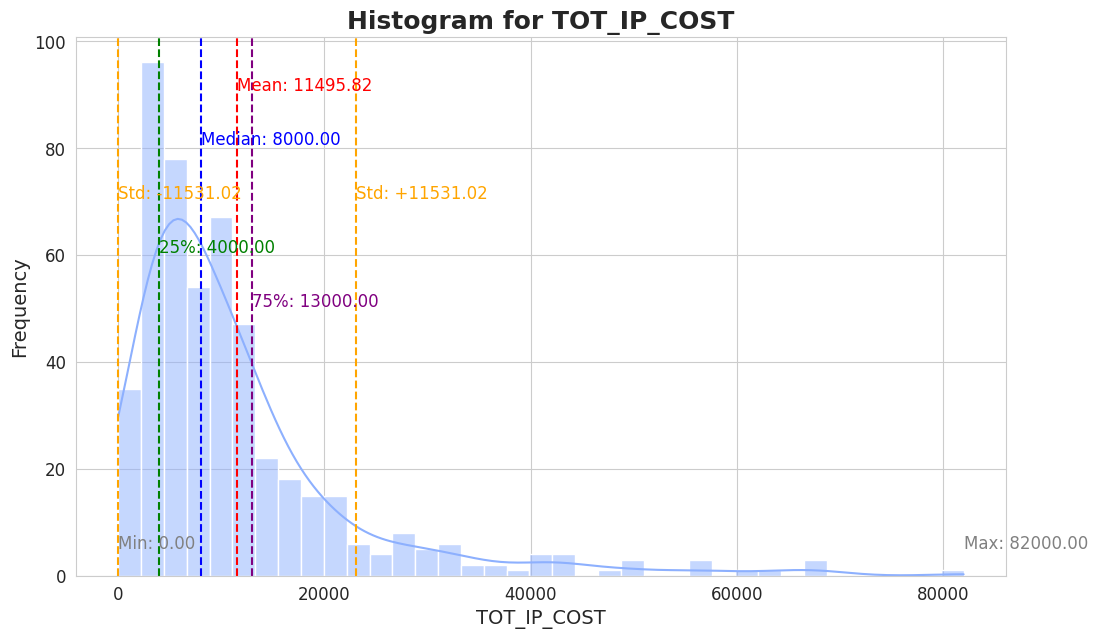

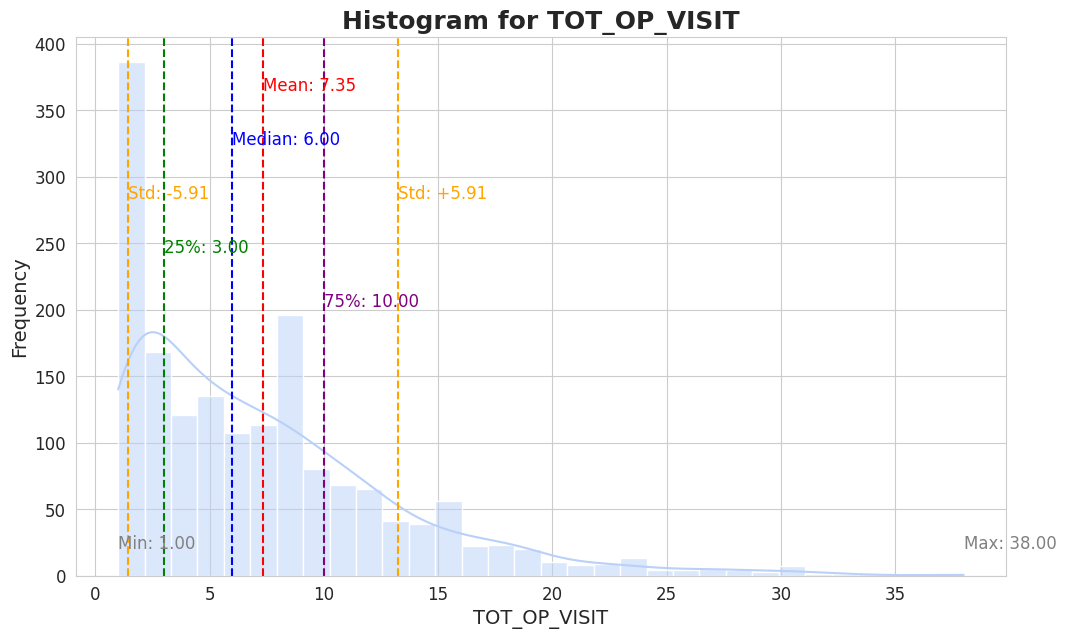

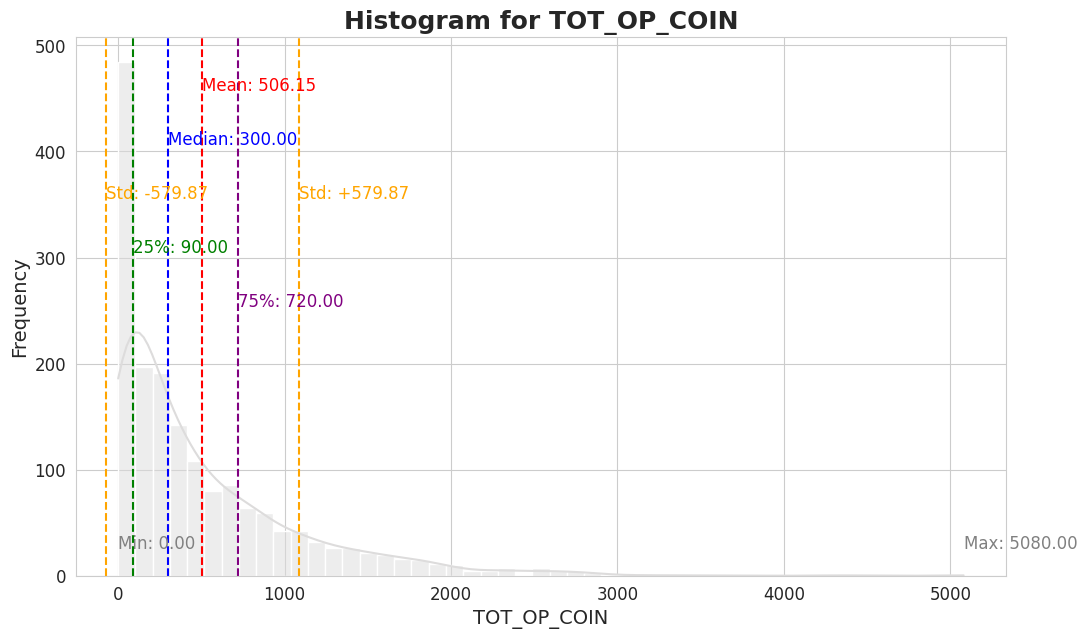

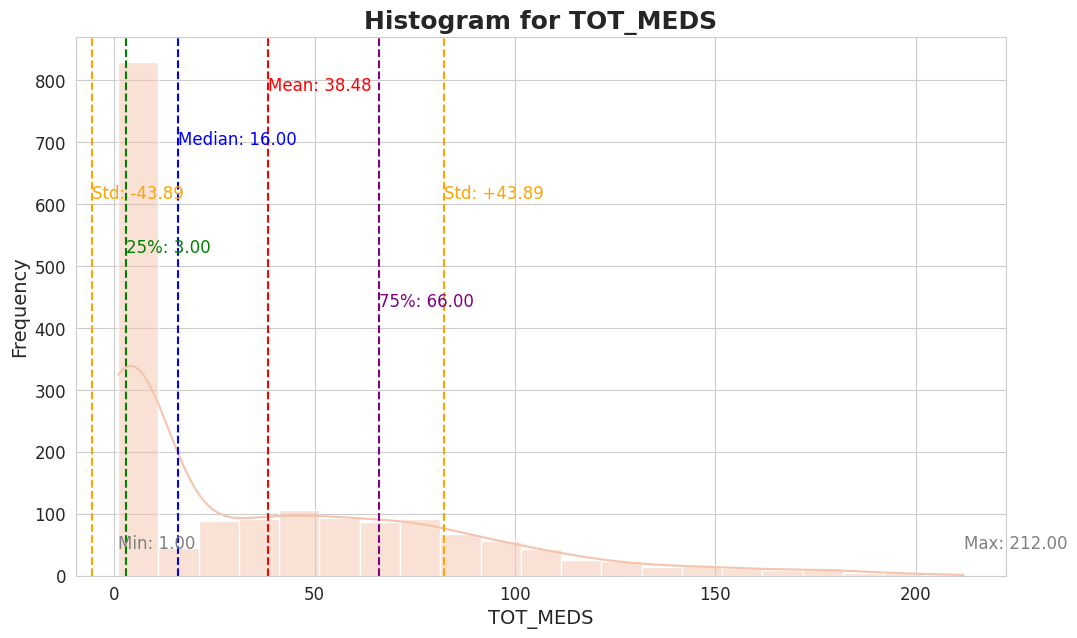

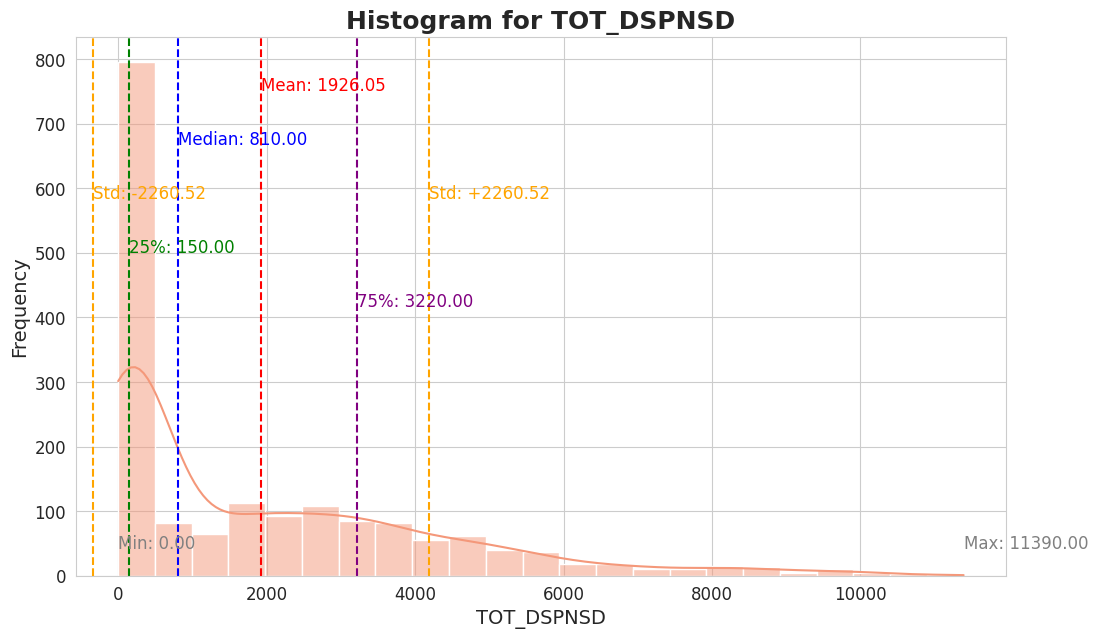

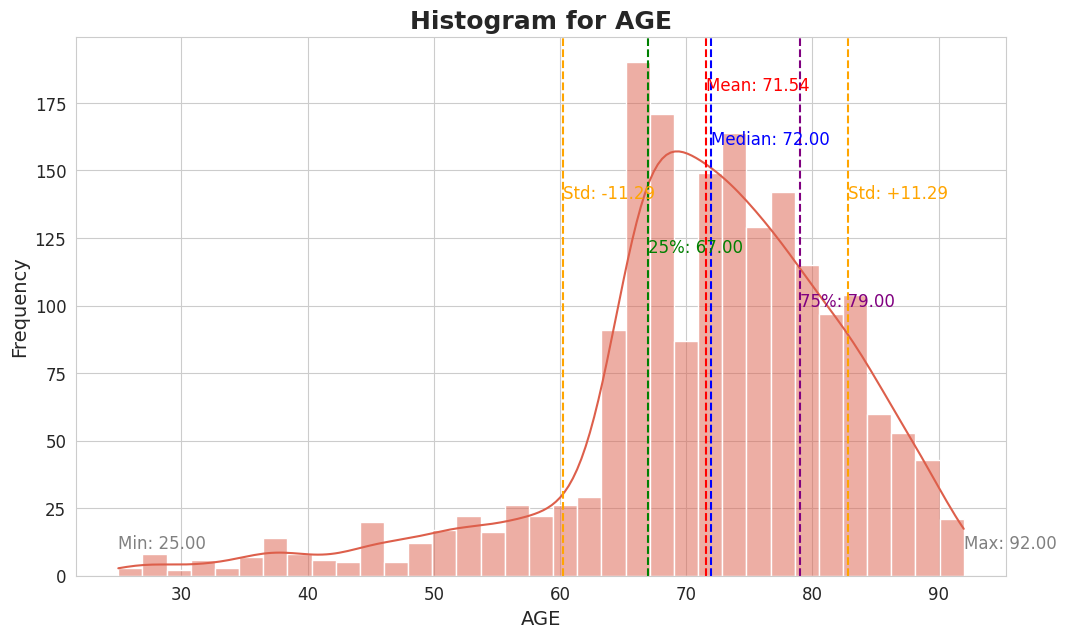

In [ ]:
# Numeric variables
plot_numeric_cols(strat_train_set, numeric_cols)


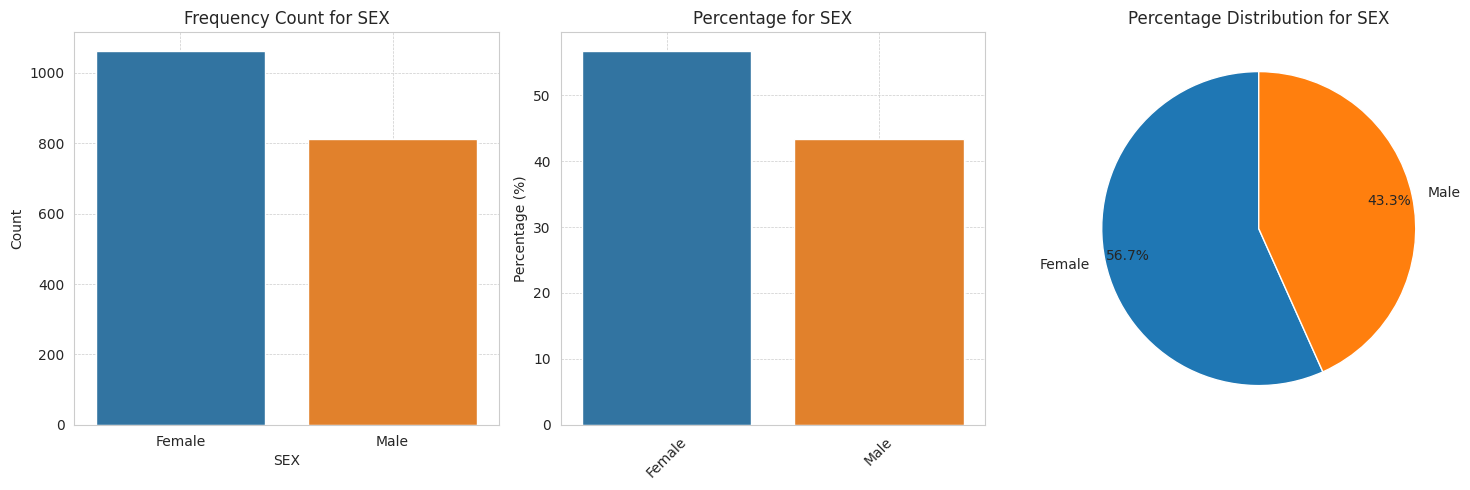

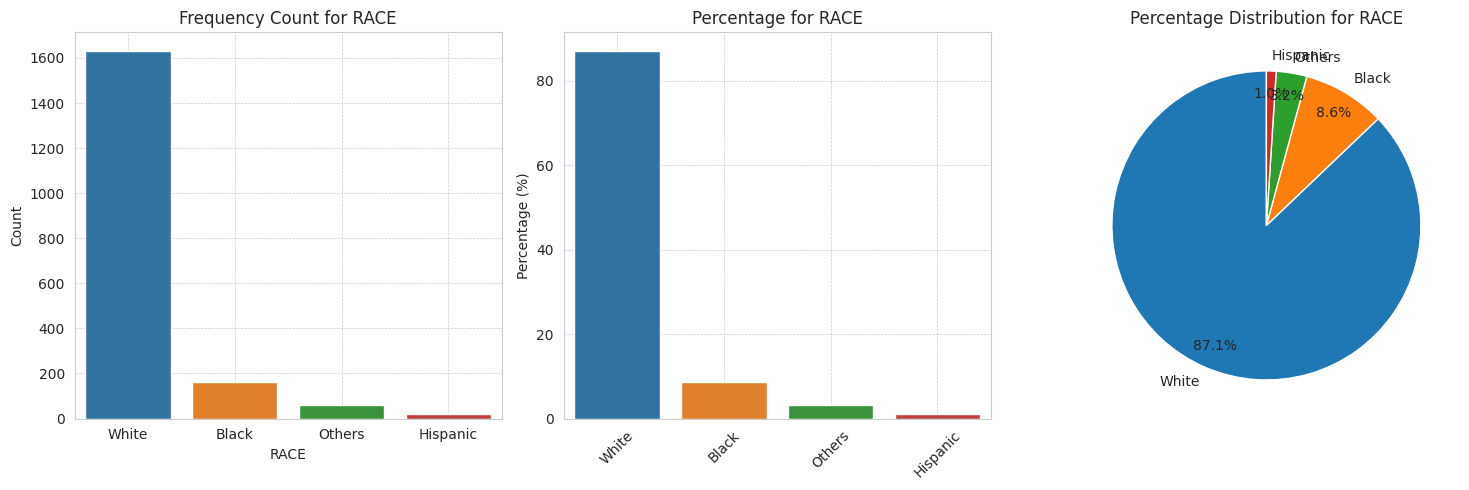

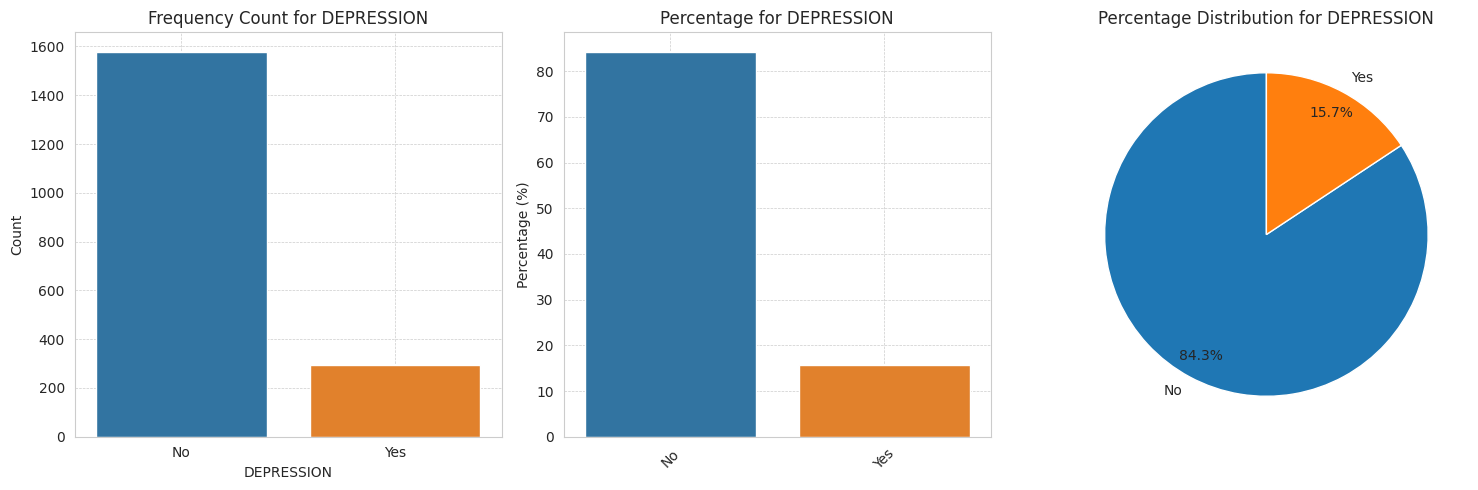

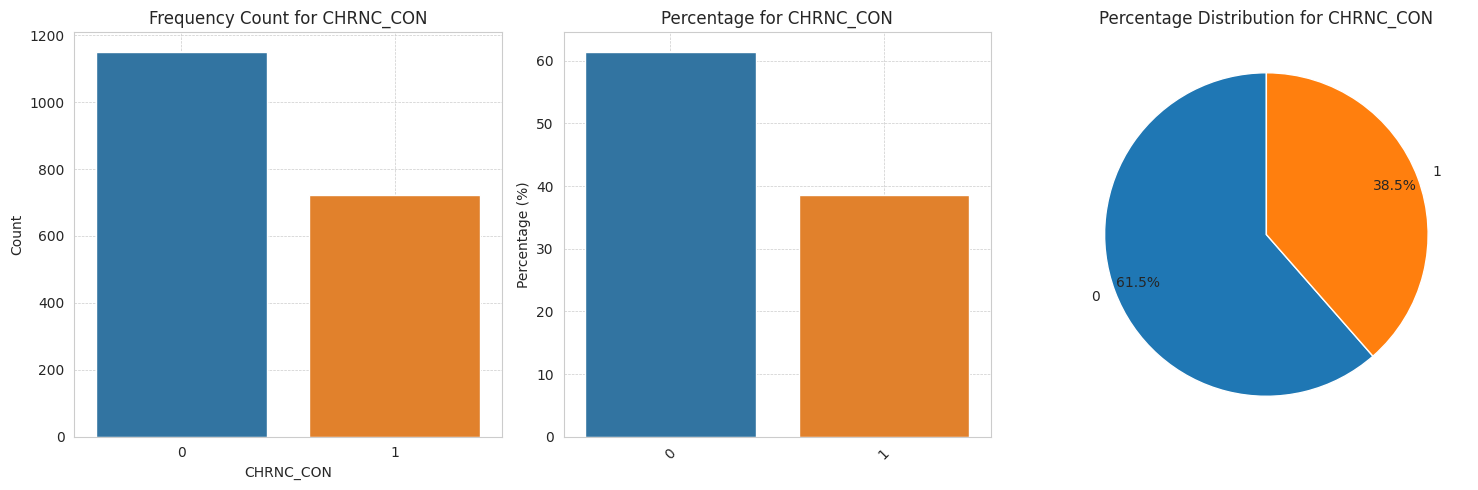

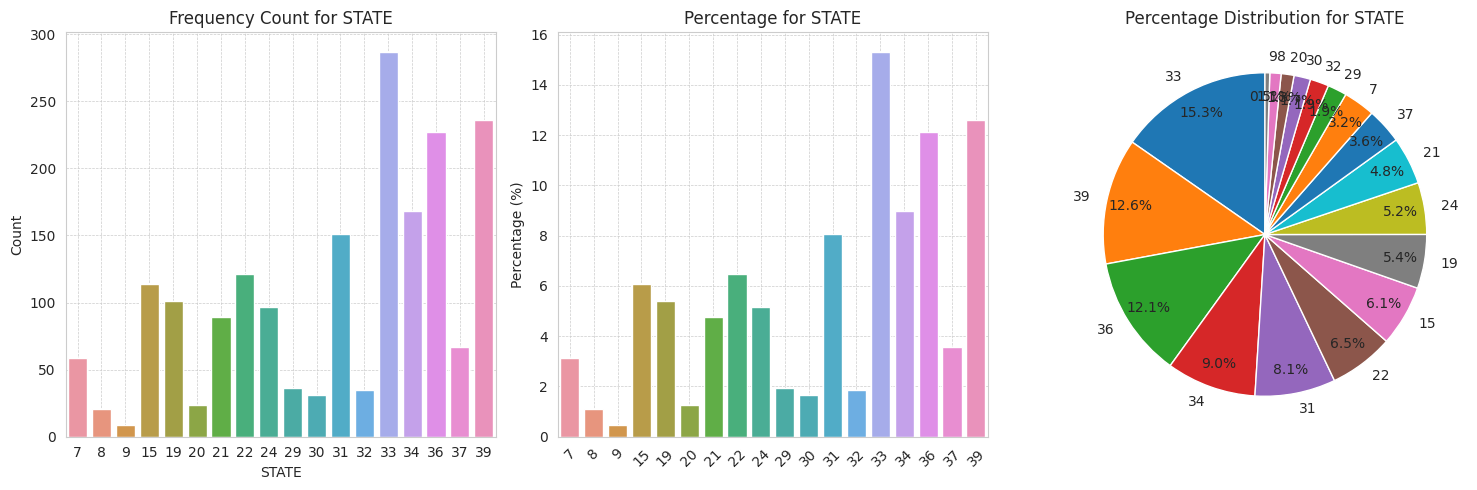

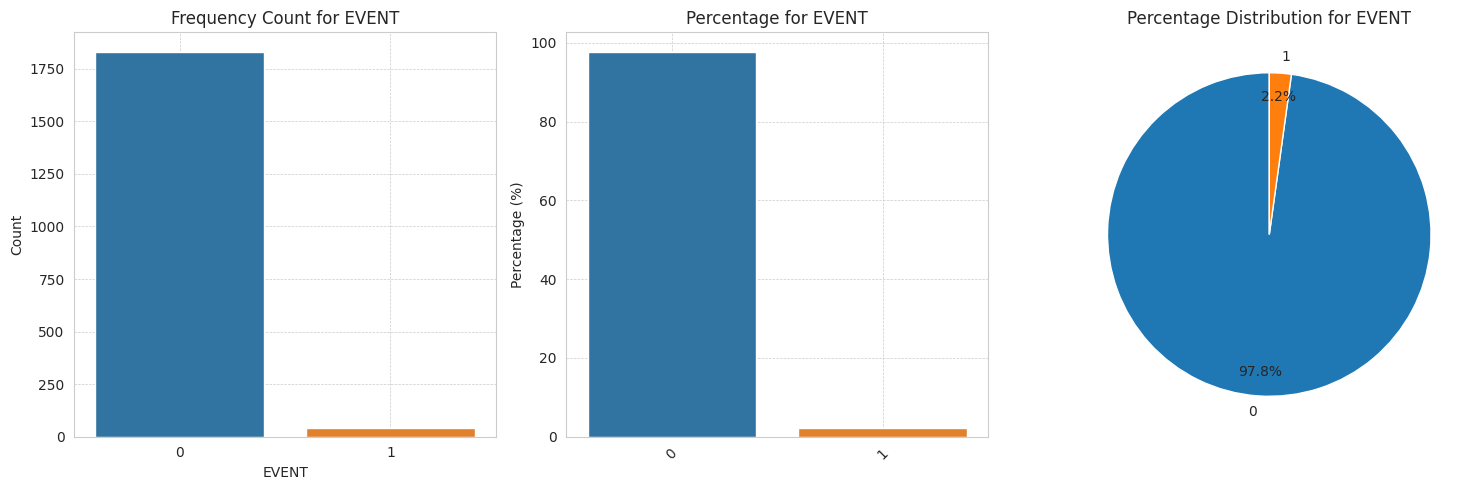

In [ ]:
# Categorical variables
plot_categorical_cols(strat_train_set, categorical_cols)

**Bivariate**

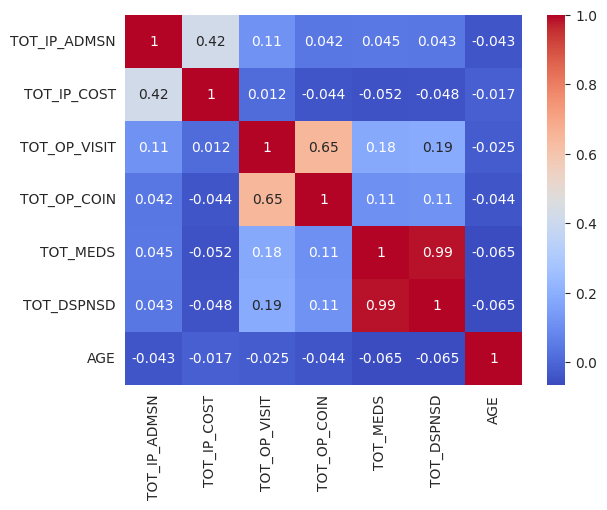

In [ ]:
#### Correlation heatmap of numerical variables

correlation_matrix = strat_train_set[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

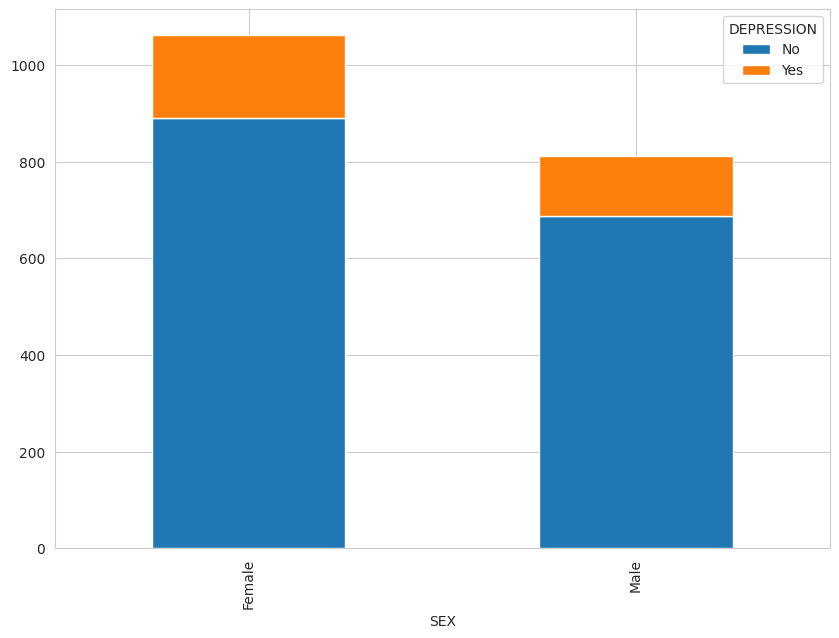

In [ ]:
#### Categorical variables

cross_tab = pd.crosstab(strat_train_set['SEX'], strat_train_set['DEPRESSION'])

# Plot as a stacked bar chart
cross_tab.plot(kind='bar', stacked=True, figsize=(10,7))
plt.show()

**Categorical vs. Numerical**

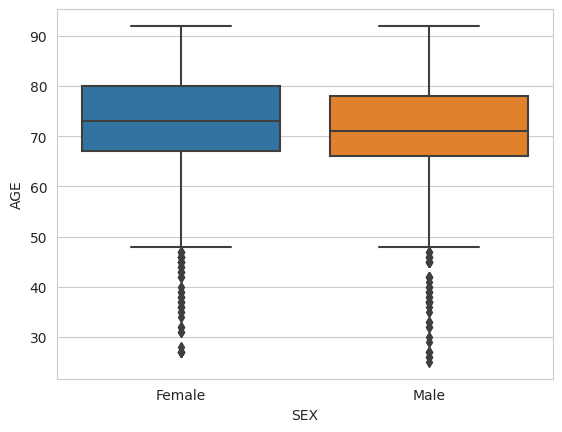

In [ ]:
sns.boxplot(data=strat_train_set, x='SEX', y='AGE')
plt.show()

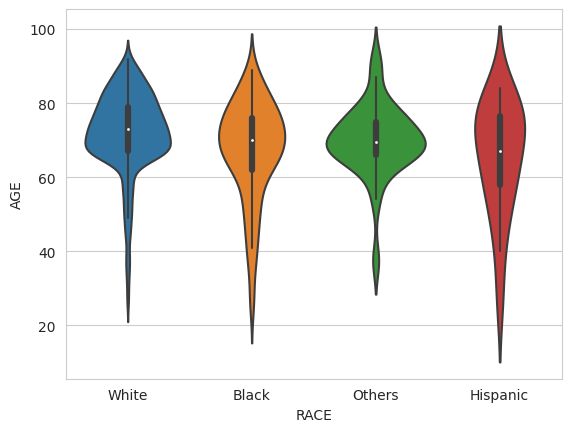

In [ ]:
sns.violinplot(data=strat_train_set, x='RACE', y='AGE')
plt.show()

**Event Analysis** - **Numerical Variables**

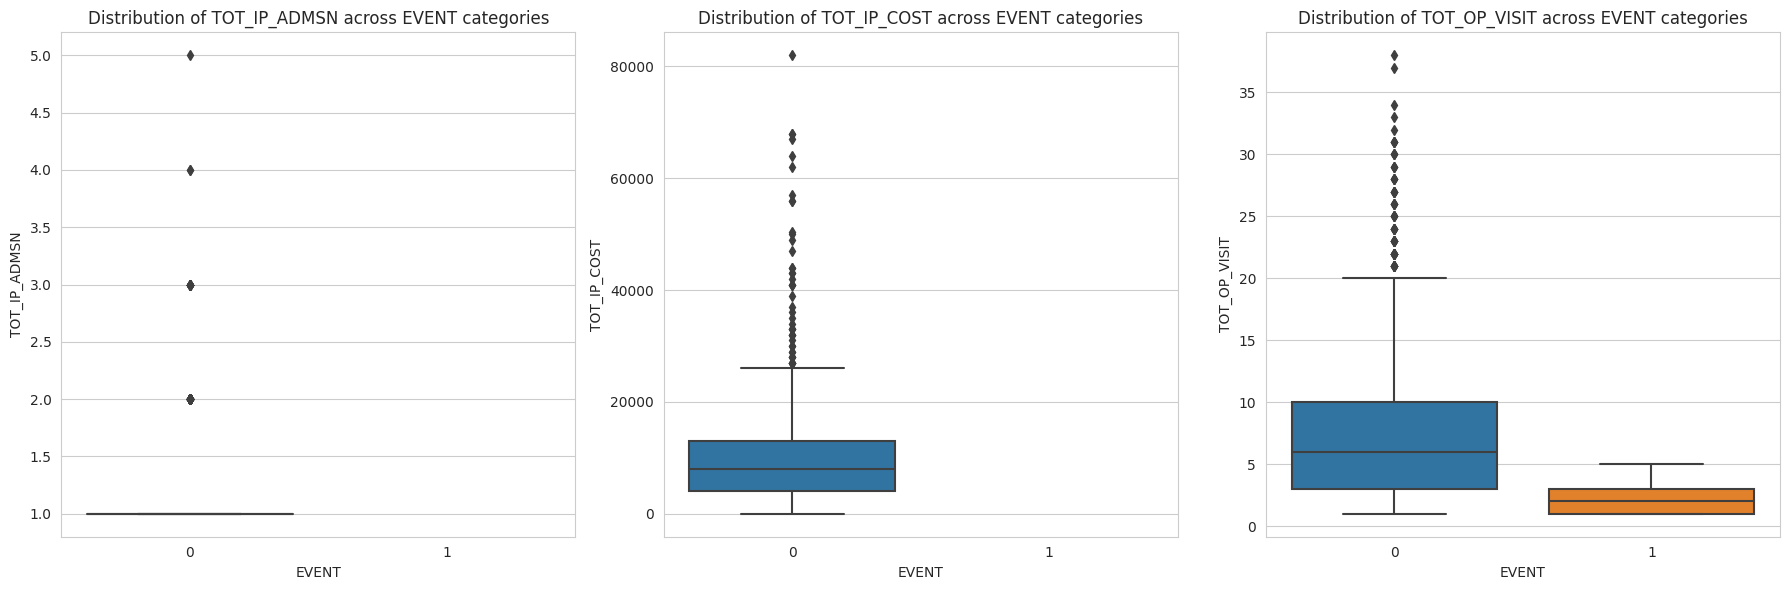

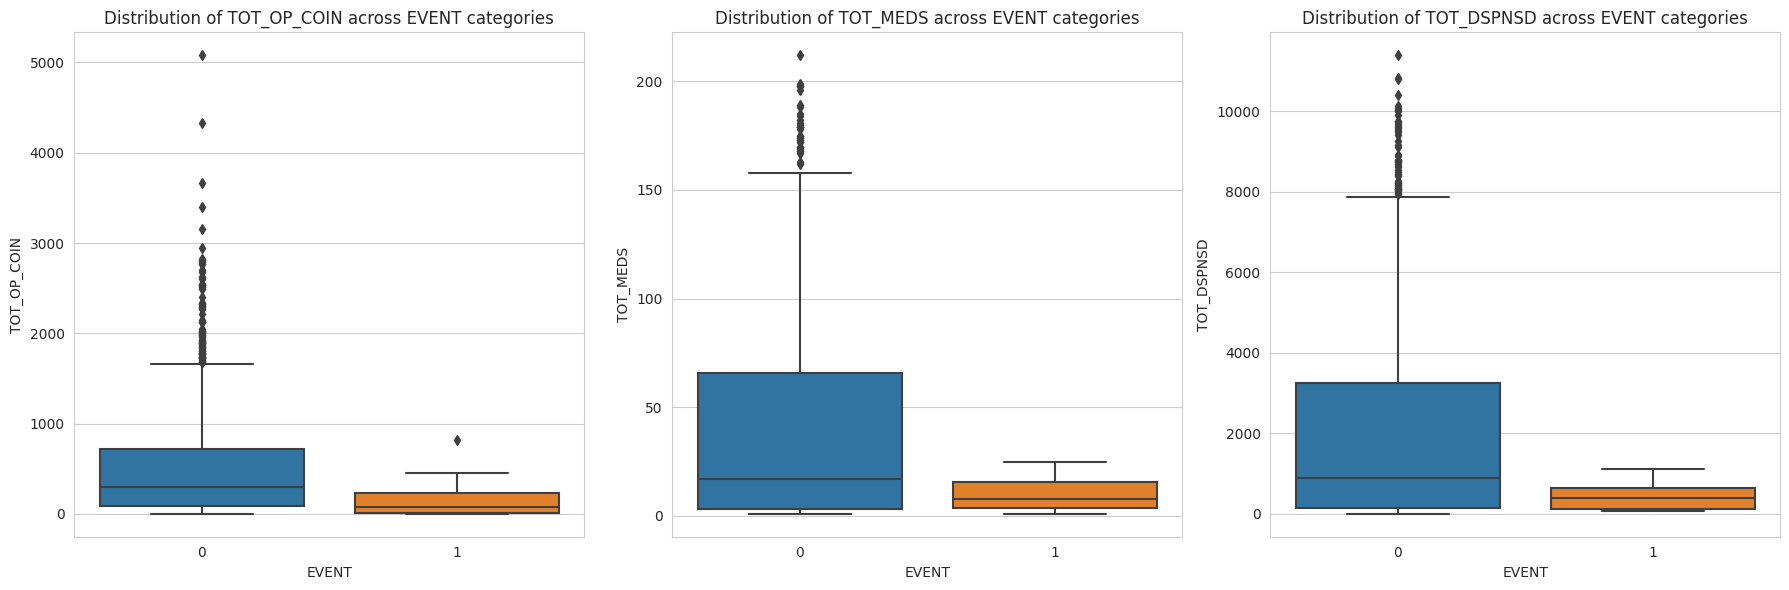

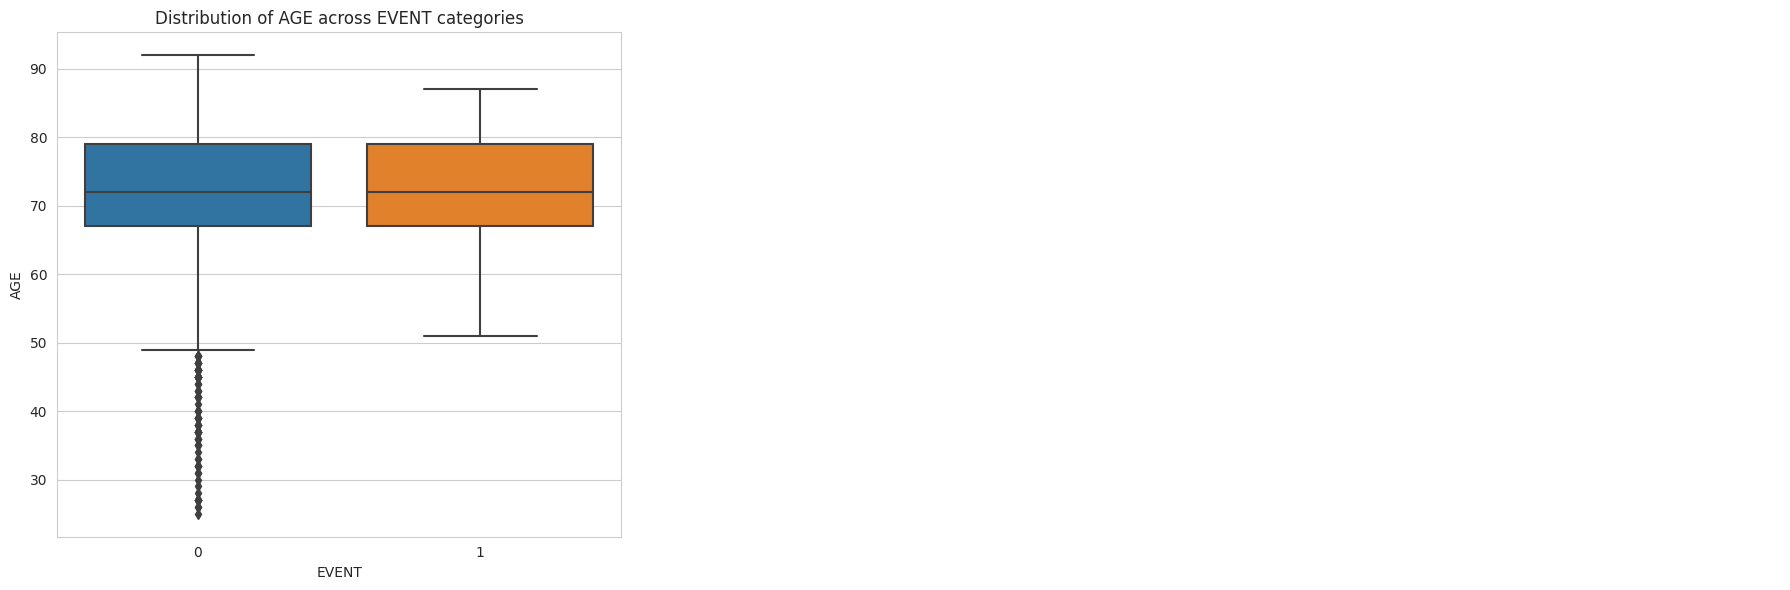

In [ ]:
# Number of columns in each subplot row
n_cols = 3

for i, col in enumerate(numeric_cols):
    # Create a new figure with subplots for every 3 columns
    if i % n_cols == 0:
        fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(18, 6))
        # Turn off all axes to begin with; we'll turn them back on when used
        for ax in axes:
            ax.axis('off')

    # Plot the boxplot on the correct subplot
    sns.boxplot(data=strat_train_set, x=event_col, y=col, ax=axes[i % n_cols])
    axes[i % n_cols].set_title(f'Distribution of {col} across EVENT categories')
    axes[i % n_cols].axis('on')  # Turn the axis back on

    # Show the figure after every 3 columns or on the last column
    if (i+1) % n_cols == 0 or i == len(numeric_cols) - 1:
        plt.tight_layout()
        plt.show()

**Event Analysis** - **Categorical Variables**

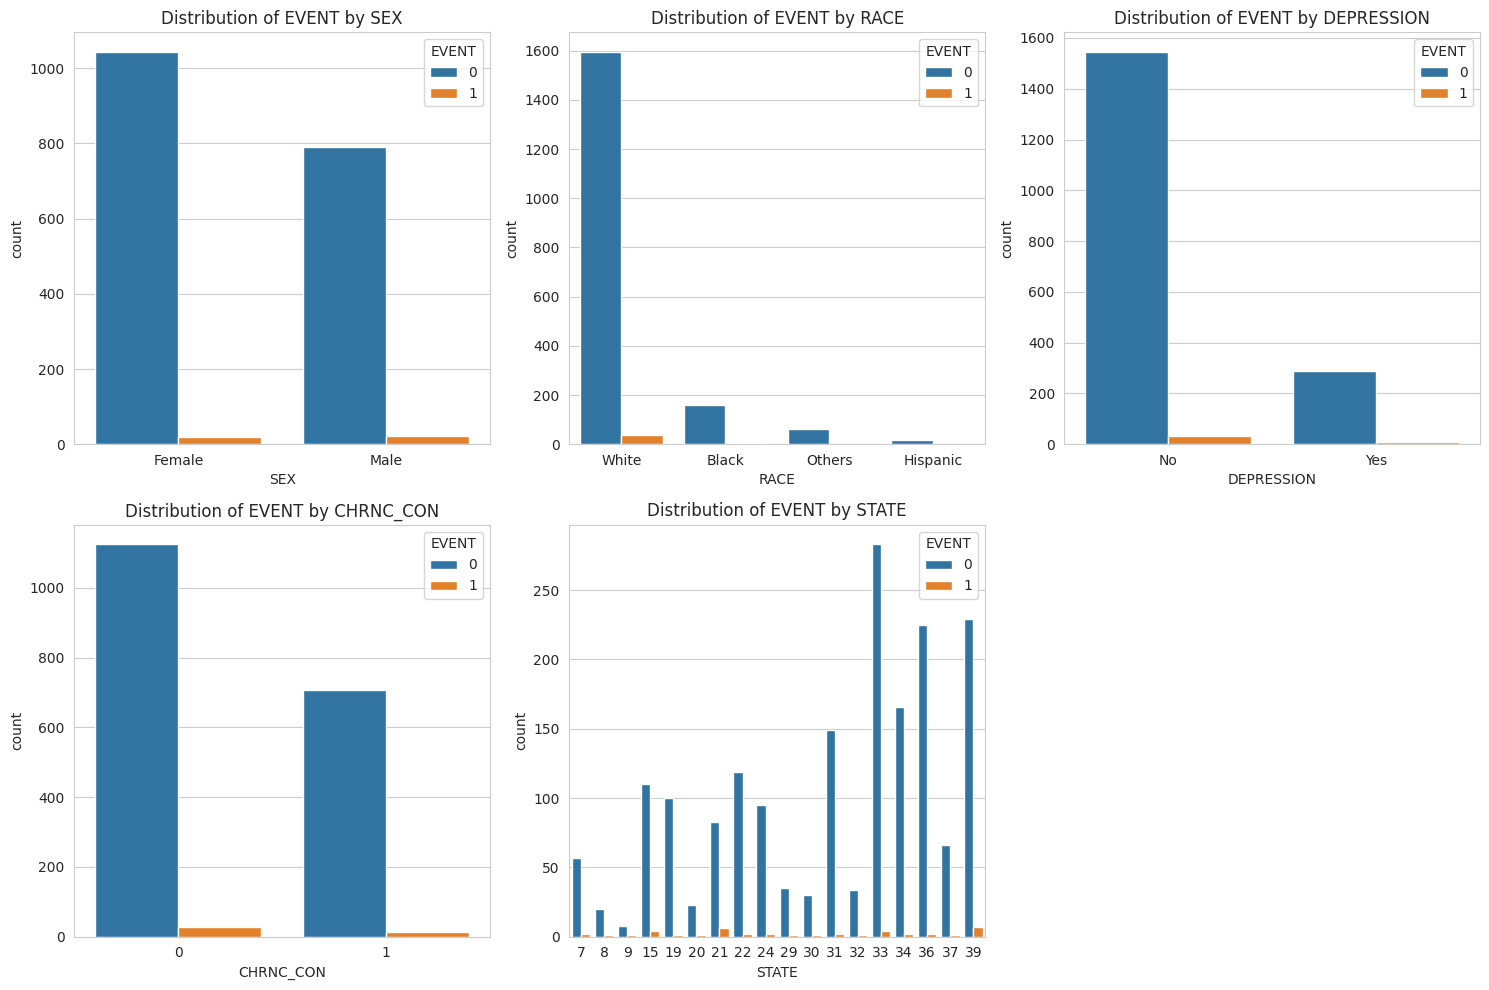

In [ ]:
n_rows = -(-len(categorical_cols_without_event) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# If there's only one row (axes is 1D), make it 2D for consistent indexing
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)

# Go through the categorical columns and plot them
for idx, col in enumerate(categorical_cols_without_event):
    current_row, current_col = divmod(idx, n_cols)
    ax = axes[current_row, current_col]
    sns.countplot(x=col, hue=event_col, data=strat_train_set, ax=ax)
    ax.set_title(f'Distribution of EVENT by {col}')
    ax.legend(title='EVENT')

# If the total number of plots isn't a multiple of n_cols, some subplots remain empty.
# We can turn these off for a cleaner look.
for empty_idx in range(len(categorical_cols_without_event), n_rows * n_cols):
    current_row, current_col = divmod(empty_idx, n_cols)
    axes[current_row, current_col].axis('off')

plt.tight_layout()
plt.show()

**Event Analysis** - **Statistical Testing**

For comparing `EVENT` across the groups in each categorical variable, we use ANOVA if the categorical variable has more than two levels/groups, or a T-test if it only has two:

In [ ]:
for col in categorical_cols_without_event:
    if strat_train_set[col].nunique() == 2:
        group1 = strat_train_set[event_col][strat_train_set[col] == strat_train_set[col].unique()[0]]
        group2 = strat_train_set[event_col][strat_train_set[col] == strat_train_set[col].unique()[1]]

        t_stat, p_val = ttest_ind(group1, group2)
        print(f"T-test for {col}: T-stat: {t_stat}, P-value: {p_val}")
    else:
        # Perform ANOVA
        groups = [strat_train_set[event_col][strat_train_set[col] == group] for group in strat_train_set[col].unique()]
        f_stat, p_val = f_oneway(*groups)
        print(f"ANOVA for {col}: F-stat: {f_stat}, P-value: {p_val}")

T-test for SEX: T-stat: -1.3535124211850613, P-value: 0.17605547393983448
ANOVA for RACE: F-stat: 0.6239397018099759, P-value: 0.5995257741661886
T-test for DEPRESSION: T-stat: -0.24484962636420593, P-value: 0.8065997168041429
T-test for CHRNC_CON: T-stat: 0.5852378652971532, P-value: 0.5584583610427462
ANOVA for STATE: F-stat: 1.195415138220625, P-value: 0.2595118623338593


### Section Summary

For each variable examined (`SEX`, `RACE`, `DEPRESSION`, `CHRNC_CON`, and `STATE`), the statistical results do not provide sufficient evidence to conclude that there are different means within the categories of these variables when associated with `EVENT`. Given that the p-values from all tests surpass typical significance thresholds, such as 0.05, we cannot reject the null hypothesis for any of the variables.

<a name="sa"></a>
## Survival Analysis
[Back to Top](#toc)

In [ ]:
def plot_km_curves(df, duration_col, event_col, stratify_by=None, x_axis_name = "Time"):
    """
    Plots the Kaplan-Meier curves for the given dataframe.

    Parameters:
    - df: DataFrame containing the data
    - duration_col: Name of the column representing the duration (e.g., 'AGE')
    - event_col: Name of the column representing the event (e.g., 'EVENT')
    - stratify_by: Name of the categorical column to stratify by (default is None)
    """
    kmf = KaplanMeierFitter()

    if not stratify_by:
        kmf.fit(df[duration_col], event_observed=df[event_col])
        plt.figure(figsize=(8, 6))
        kmf.plot()
        plt.title('Kaplan-Meier Survival Curve')
        plt.xlabel(x_axis_name)
        plt.ylabel('Survival Probability')
        plt.grid()
        plt.show()
    else:
        for category in df[stratify_by].unique():
            # Selecting data for the group
            grouped_df = df[df[stratify_by] == category]

            kmf.fit(grouped_df[duration_col], grouped_df[event_col], label=str(category))
            kmf.plot()

        plt.title(f'Kaplan-Meier Survival Curve by {stratify_by}')
        plt.xlabel(x_axis_name)
        plt.ylabel('Survival Probability')
        plt.grid()
        plt.show()

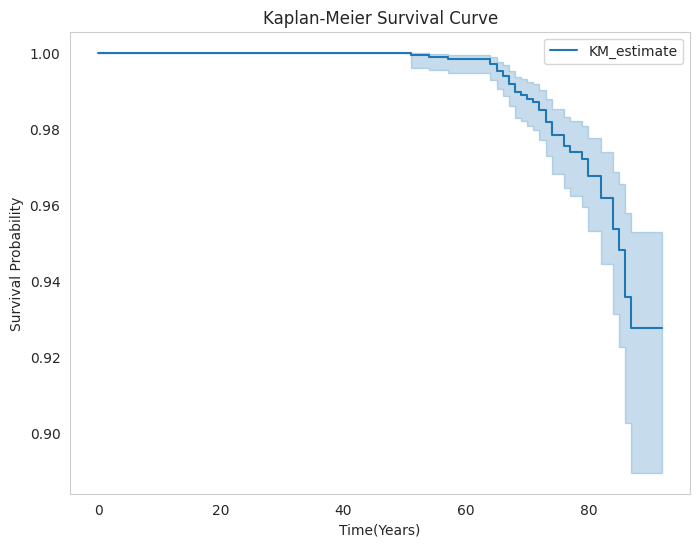

In [ ]:
#### Survival curve

plot_km_curves(strat_train_set, time_col, event_col,x_axis_name = "Time(Years)")

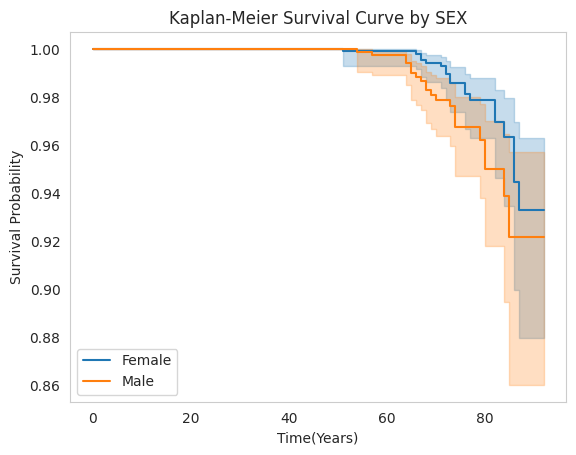

In [ ]:
#### Survival curves - SEX

plot_km_curves(strat_train_set, time_col, event_col, stratify_by='SEX',x_axis_name = "Time(Years)")

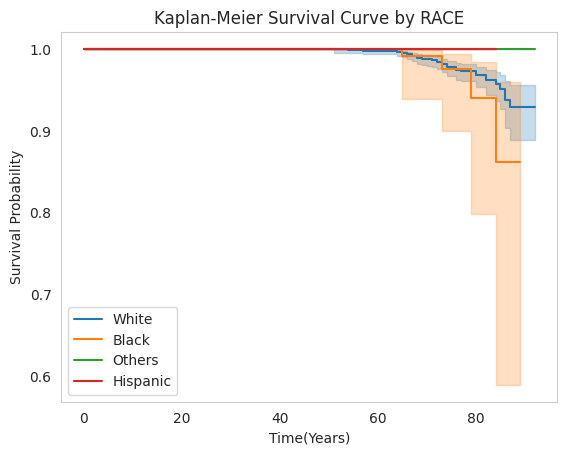

In [ ]:
#### Survival cuves - RACE

plot_km_curves(strat_train_set, time_col, event_col, stratify_by='RACE',x_axis_name = "Time(Years)")

## Data Preprocessing

In [ ]:
#### Drop ID column
strat_train_cleaned = strat_train_set.drop("DESYNPUF_ID", axis=1)
strat_test_cleaned = strat_test_set.drop("DESYNPUF_ID", axis=1)

In [ ]:
#### Missing values

missing_cols(strat_train_cleaned)

Missing Count  Missing Percentage (%)
TOT_IP_ADMSN           1371               73.198078
TOT_IP_COST            1371               73.198078
TOT_OP_VISIT            161                8.595836
TOT_OP_COIN             161                8.595836
TOT_MEDS                152                8.115323
TOT_DSPNSD              152                8.115323

In [ ]:
missing_cols(strat_test_cleaned)

Missing Count  Missing Percentage (%)
TOT_IP_ADMSN            341               72.707889
TOT_IP_COST             341               72.707889
TOT_OP_VISIT             40                8.528785
TOT_OP_COIN              40                8.528785
TOT_MEDS                 33                7.036247
TOT_DSPNSD               33                7.036247

In [ ]:
# All missing values are of a count data type,
# we will replace nulls with 0.

strat_train_cleaned = strat_train_cleaned.fillna(0)
strat_test_cleaned = strat_test_cleaned.fillna(0)

In [ ]:
unique_values = cms_df[categorical_cols].apply(pd.Series.unique)
print(unique_values)

SEX                                                                  [Female, Male]
RACE                                               [White, Black, Others, Hispanic]
DEPRESSION                                                                [No, Yes]
CHRNC_CON                                                                    [1, 0]
STATE         [33, 31, 7, 8, 32, 24, 22, 39, 36, 34, 37, 15, 19, 21, 20, 9, 29, 30]
EVENT                                                                        [0, 1]
dtype: object


In [ ]:
#### Convert 2 value categories `SEX`, `DEPRESSION`  into binary variables

def convert_categorical_to_binary(df, mappings):
    """
    Replaces categorical values with binary ones in specified columns.

    Parameters:
    - df (DataFrame): The dataframe containing the data.
    - mappings (dict): Dictionary with keys as column names and values as another dictionary
                      specifying the replacements. e.g., {'SEX': {'Male': 1, 'Female': 0}}

    Returns:
    - DataFrame with replaced values.
    """
    for column, mapping in mappings.items():
        df[column] = df[column].replace(mapping)

In [ ]:
replacements = {
    'SEX': {'Male': 1, 'Female': 0},
    'DEPRESSION': {'Yes': 1, 'No': 0}
}

convert_categorical_to_binary(strat_train_cleaned, replacements)
convert_categorical_to_binary(strat_test_cleaned, replacements)

In [ ]:
#### Convert race into dummy variables

strat_train_cleaned = pd.get_dummies(strat_train_cleaned, columns=['RACE'])
strat_test_cleaned = pd.get_dummies(strat_test_cleaned, columns=['RACE'])

In [ ]:
#### Normalization

train_df_scaled = strat_train_cleaned.copy()
test_df_scaled = strat_test_cleaned.copy()

scaler = StandardScaler()

# Fit the scaler on the training data and transform it
train_df_scaled[numeric_cols] = scaler.fit_transform(train_df_scaled[numeric_cols])

# Transform the test data using the same scaler (don't fit the scaler on the test data!)
test_df_scaled[numeric_cols] = scaler.transform(test_df_scaled[numeric_cols])

## Univariate Analysis with Cox-PH


In [ ]:
#### Cox-PH regression

cph = CoxPHFitter()
significant_features = []

for col in train_df_scaled.columns.difference([time_col, event_col]):
    cph.fit(train_df_scaled[[col, time_col, event_col]], duration_col=time_col, event_col=event_col)

    # Extract the p-value for the current feature
    p_value = cph.summary.loc[col, 'p']

    if p_value < 0.05:  # Check if p-value is less than 0.05
        significant_features.append(col)
        print(f"Feature: {col}, p-value: {p_value}")

print("\nSignificant Features:", significant_features)

Feature: STATE, p-value: 0.03250299168573303
Feature: TOT_DSPNSD, p-value: 0.008000121202466818
Feature: TOT_MEDS, p-value: 0.011161637771821895
Feature: TOT_OP_COIN, p-value: 2.1787366367614292e-05
Feature: TOT_OP_VISIT, p-value: 6.4395378133131055e-09

Significant Features: ['STATE', 'TOT_DSPNSD', 'TOT_MEDS', 'TOT_OP_COIN', 'TOT_OP_VISIT']


In [ ]:
### Check for high-correlation among covariates

corr_matrix = train_df_scaled.drop([event_col, time_col], axis=1).corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
print(high_corr_var)

remove_high_corr_cols = ["TOT_DSPNSD","RACE_Black"]

train_df_scaled = train_df_scaled.drop(remove_high_corr_cols, axis=1)
test_df_scaled = test_df_scaled.drop(remove_high_corr_cols, axis=1)

[('TOT_MEDS', 'TOT_DSPNSD'), ('RACE_Black', 'RACE_White')]


In [ ]:
#### Recursive feature elimination

class CoxPH(BaseEstimator, RegressorMixin):
    def __init__(self, feature_names=None):
        self.feature_names = feature_names

    def fit(self, X, y):
        # Dynamically set the column names based on the shape of X
        current_columns = self.feature_names[:X.shape[1]]

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=current_columns)
        if not isinstance(y, pd.DataFrame):
            y = pd.DataFrame(y, columns=['AGE', 'EVENT'])

        # Double check shapes before concatenation
        assert X.shape[0] == y.shape[0], "Mismatch in number of rows between X and y"

        data = pd.concat([X, y], axis=1)

        self.coxph = CoxPHFitter()
        self.coxph.fit(data, duration_col='AGE', event_col='EVENT')

        # Add the coef_ attribute to satisfy sklearn's RFE
        self.coef_ = self.coxph.params_.values.reshape(1, -1)
        return self

    def predict(self, X):
        return self.coxph.predict_partial_hazard(X).values

In [ ]:
X = train_df_scaled.drop([event_col, time_col], axis=1)
y = train_df_scaled[[time_col, event_col]]

feature_cols = X.columns.tolist()
selector = RFE(estimator=CoxPH(feature_names=feature_cols), n_features_to_select=8) # We pick top 8
selector.fit(X, y)

# Get the ranking of the features
feature_ranking = pd.Series(selector.ranking_, index=feature_cols)
print(feature_ranking.sort_values())

SEX              1
DEPRESSION       1
TOT_IP_ADMSN     1
TOT_OP_VISIT     1
TOT_MEDS         1
RACE_Hispanic    1
RACE_Others      1
RACE_White       1
CHRNC_CON        2
TOT_IP_COST      3
TOT_OP_COIN      4
STATE            5
dtype: int64


In [ ]:
selected_features = feature_ranking[feature_ranking == 1].index.tolist()

train_df_scaled_selected = train_df_scaled[selected_features + [time_col, event_col]]
test_df_scaled_selected = test_df_scaled[selected_features + [time_col, event_col]]

<a name="cox-ph"></a>
## Cox-PH Model
[Back to Top](#toc)

### Model Fit

In [ ]:
# Fit the Cox's Proportional Hazards model
cph_model = CoxPHFitter()
cph_model.fit(train_df_scaled_selected, duration_col=time_col, event_col=event_col)
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 1873 total observations, 1832 right-censored observations>
             duration col = 'AGE'
                event col = 'EVENT'
      baseline estimation = breslow
   number of observations = 1873
number of events observed = 41
   partial log-likelihood = -172.96
         time fit was run = 2023-08-15 15:54:39 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
SEX             0.47       1.59       0.32            -0.16             1.09                 0.85                 2.97
DEPRESSION      1.43       4.20       0.44             0.58             2.29                 1.78                 9.91
TOT_IP_ADMSN  -11.26       0.00    2004.73         -3940.45          3917.94                 0.00                  inf
TOT_OP_VISIT   -7.04       0.00       1.11            -9.21            -4.87                 0.00                 0.01
TOT_MEDS       -4.80       0.01       1.66            -8.06            -1.55                 0.00                 0.21
RACE_Hispanic -19.77       0.00   30494.94        -59788.76         59749.22                 0.00                  inf
RACE_Others   -16.77       0.00   13974.40        -27406.09         27372.56                 0.00                  inf
RACE_White     -1.48       0.23       0.55            -2.56            -0.41                 0.08                 0.66

                cmp to     z      p   -log2(p)
covariate                                     
SEX               0.00  1.46   0.14       2.80
DEPRESSION        0.00  3.27 <0.005       9.88
TOT_IP_ADMSN      0.00 -0.01   1.00       0.01
TOT_OP_VISIT      0.00 -6.35 <0.005      32.16
TOT_MEDS          0.00 -2.89 <0.005       8.03
RACE_Hispanic     0.00 -0.00   1.00       0.00
RACE_Others       0.00 -0.00   1.00       0.00
RACE_White        0.00 -2.71   0.01       7.20
---
Concordance = 0.97
Partial AIC = 361.92
log-likelihood ratio test = 200.93 on 8 df
-log2(p) of ll-ratio test = 127.53

In [ ]:
# Calculate and print the Concordance Index for the training data
train_score = cph_model.score(train_df_scaled_selected, scoring_method="concordance_index")
print(f"CoxPH model Concordance Index (c-index) on training dataset: {train_score:.4f}")

CoxPH model Concordance Index (c-index) on training dataset: 0.9662


**Proportional hazards assumption**

In [ ]:
#### Statistical tests
cph_model.check_assumptions(train_df_scaled_selected, p_value_threshold=0.05) # show p < 0.05

Proportional hazard assumption looks okay.


[]

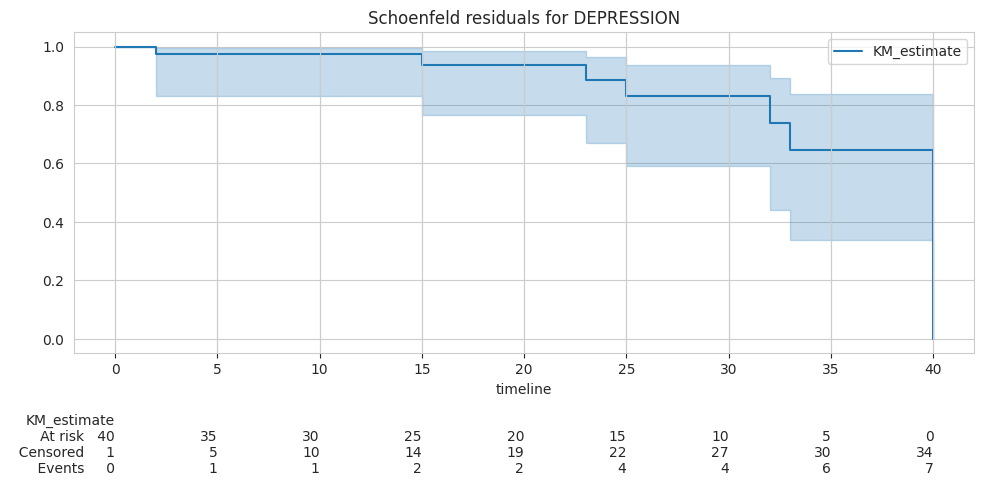

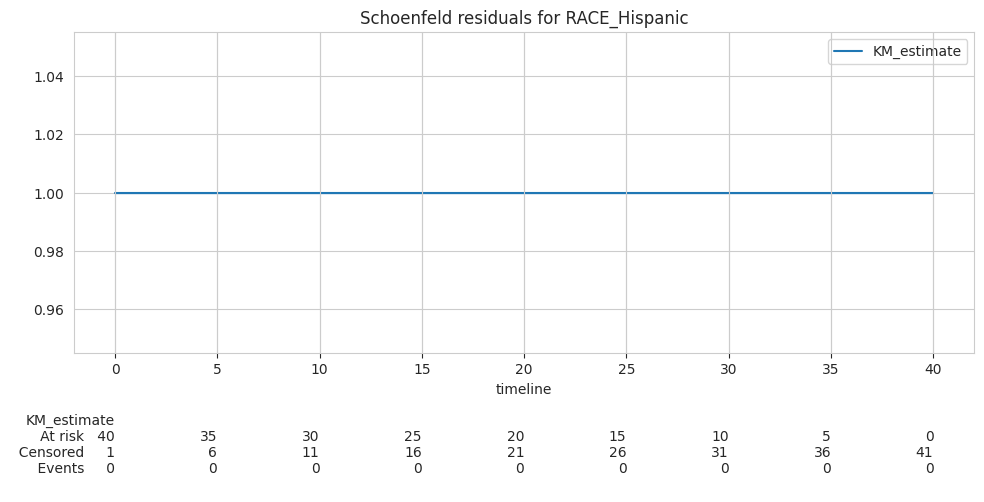

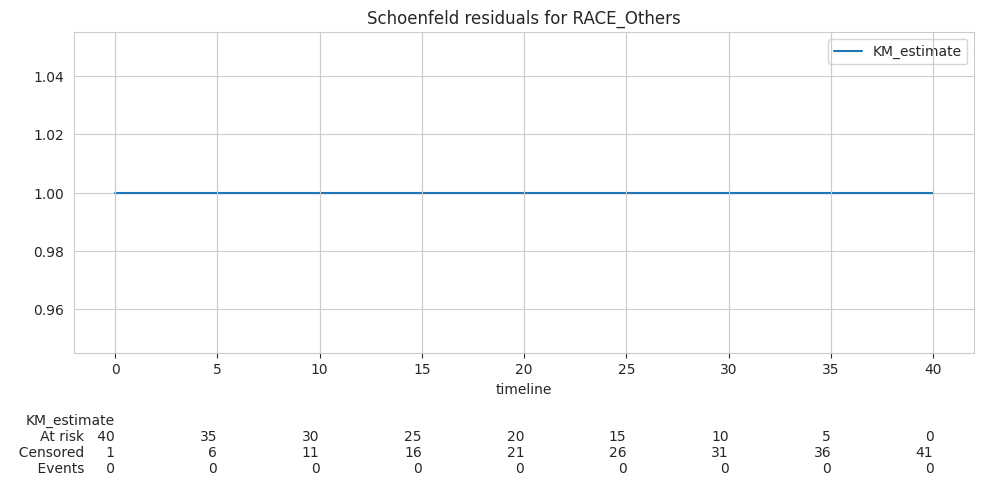

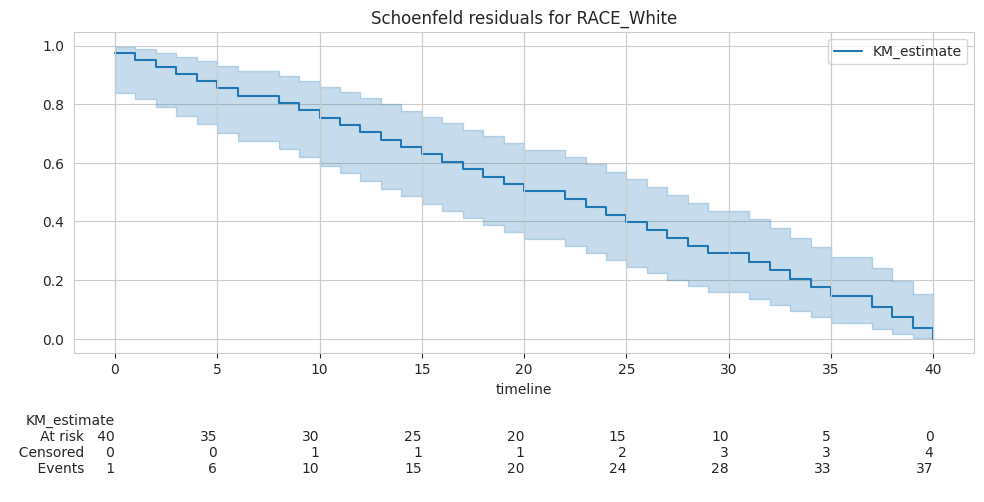

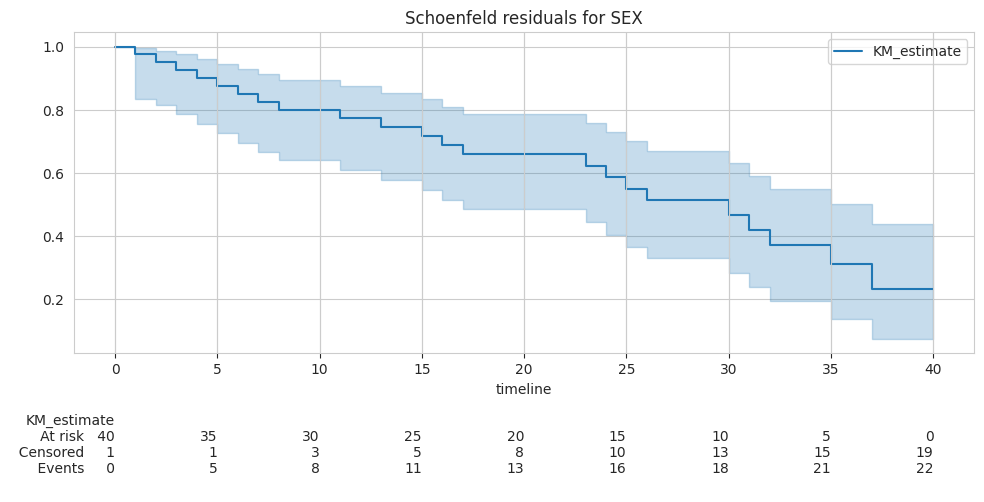

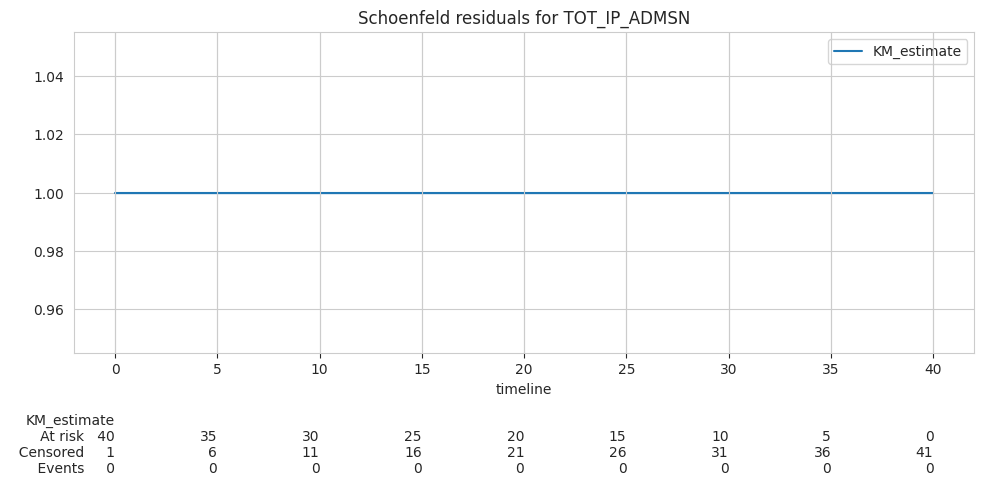

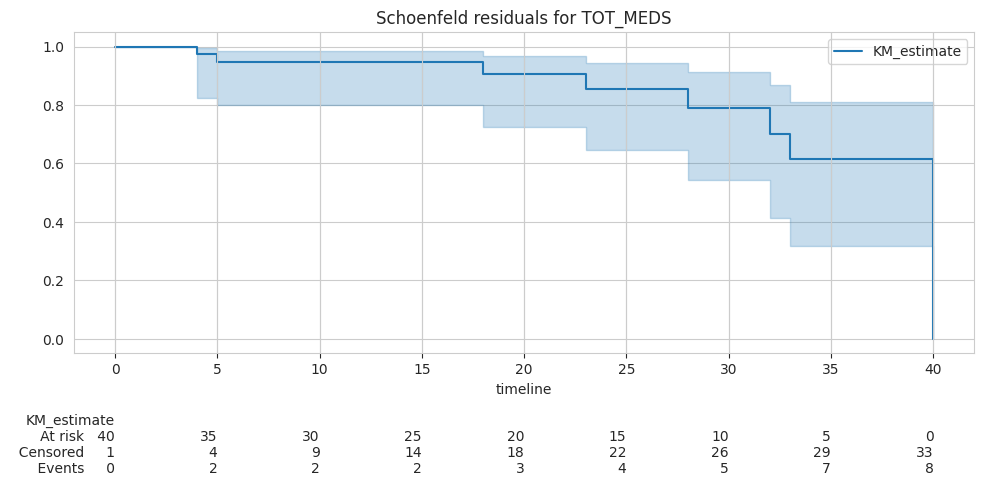

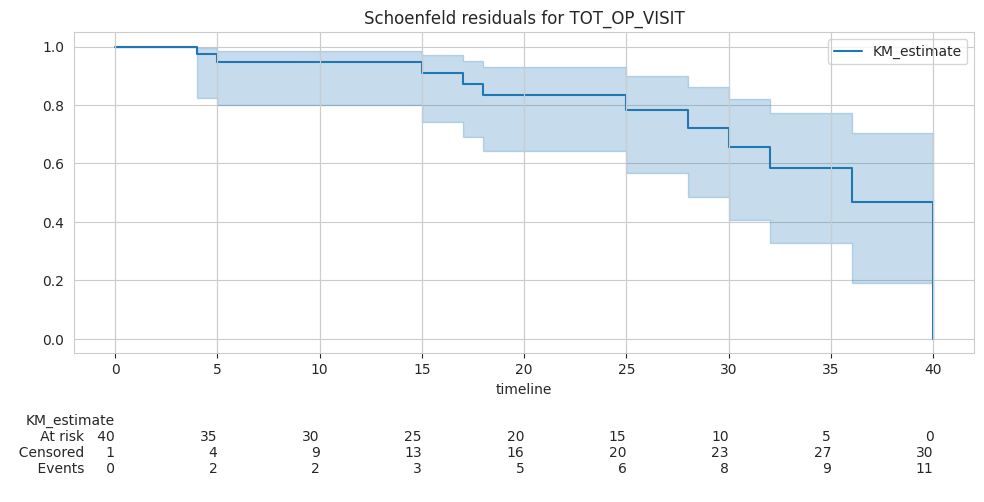

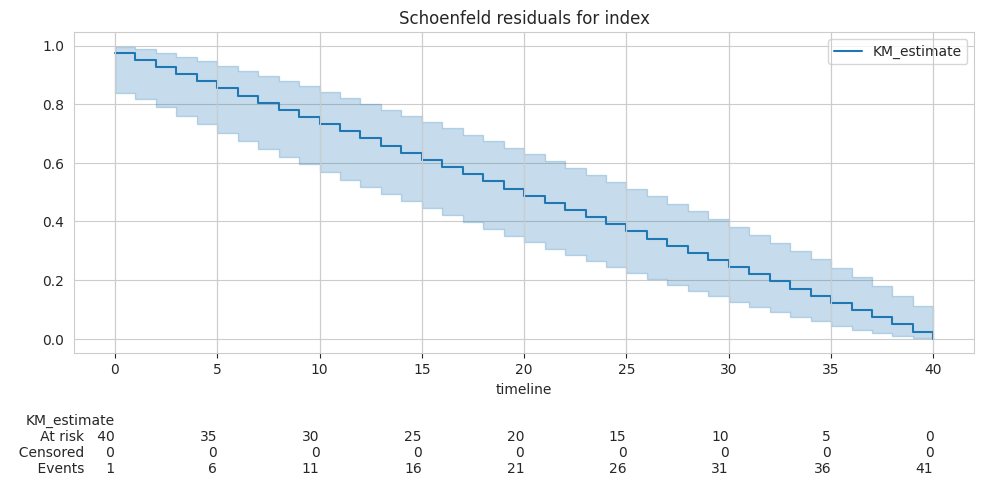

In [ ]:
#### Residual plots

# Obtain scaled Schoenfeld residuals
residuals = cph_model.compute_residuals(train_df_scaled_selected, 'schoenfeld')
residuals = residuals.reset_index()

kmf = KaplanMeierFitter()

# For each covariate, plot the residuals
for covariate in residuals.columns.difference(['event']):
    plt.figure(figsize=(10, 5))
    times = residuals.index
    kmf.fit(times, event_observed=(residuals[covariate] > 0))
    kmf.plot(at_risk_counts=True)
    plt.title(f"Schoenfeld residuals for {covariate}")
    plt.show()

### Model Evaluation

**Risk scores**

In [ ]:
risk_scores_test = cph_model.predict_partial_hazard(test_df_scaled_selected)

**Concordance index (c-index)**

In [ ]:
from lifelines.utils import concordance_index
c_index = concordance_index(test_df_scaled_selected[time_col], -cph_model.predict_partial_hazard(test_df_scaled_selected).values, test_df_scaled_selected[event_col])

print(f"CoxPH model Concordance Index (c-index) on test dataset: {c_index:.4f}")

CoxPH model Concordance Index (c-index) on test dataset: 0.9092


**Hazard ratios**

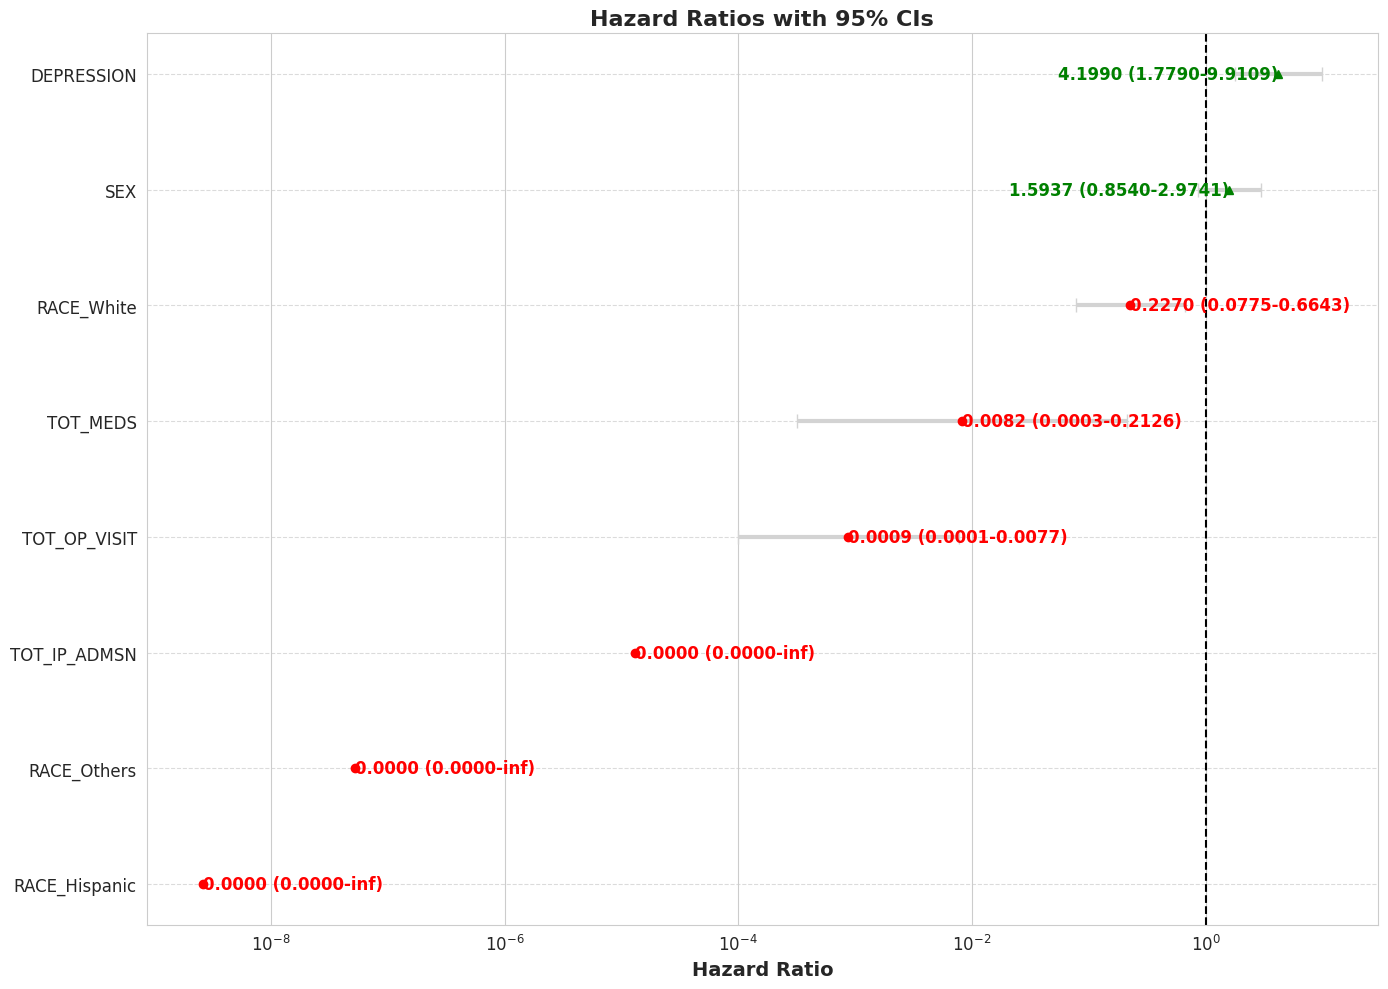

In [ ]:
# Get hazard ratios and confidence intervals
hr = cph_model.hazard_ratios_
ci = cph_model.confidence_intervals_

# Sort for better visualization
sorted_vars = hr.sort_values().index
hr_sorted = hr[sorted_vars]
ci_sorted = ci.loc[sorted_vars]

# Plot
plt.figure(figsize=(14, 10))

colors = ['red' if h < 1 else 'green' for h in hr_sorted]
markers = ['o' if h < 1 else '^' for h in hr_sorted]

for idx, var in enumerate(sorted_vars):
    plt.errorbar(y=idx, x=hr_sorted[var], xerr=[[hr_sorted[var] - np.exp(ci_sorted.loc[var, '95% lower-bound'])], [np.exp(ci_sorted.loc[var, '95% upper-bound']) - hr_sorted[var]]], fmt=markers[idx], color=colors[idx], ecolor='lightgray', elinewidth=3, capsize=5, label=var)
    plt.text(s=f"{hr_sorted[var]:.4f} ({np.exp(ci_sorted.loc[var, '95% lower-bound']):.4f}-{np.exp(ci_sorted.loc[var, '95% upper-bound']):.4f})", x=hr_sorted[var], y=idx, color=colors[idx], va="center", ha="right" if hr_sorted[var] > 1 else "left", fontsize=12, fontweight='bold')

plt.yticks(ticks=np.arange(len(sorted_vars)), labels=sorted_vars, fontsize=12)
plt.xticks(fontsize=12)
plt.xscale("log")
plt.axvline(x=1, color='black', linestyle='--', linewidth=1.5)
plt.title("Hazard Ratios with 95% CIs", fontsize=16, fontweight='bold')
plt.xlabel("Hazard Ratio", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Model Interpretation


**Covariates**

*The* hazard ratios and their 95% confidence intervals offer a glimpse into the association between each variable and the desired outcome while keeping other variables steady. Based on the depicted graph:

- **SEX (1.5937)**: Men have a 59.37% higher risk of death due to heart disease than women. This is significant as the confidence interval (0.85340 to 2.9741) does not include 1.


- **DEPRESSION (4.1990)**: Patients with depression have about 4.2 times higher risk of death than those without depression. Given the confidence interval (1.7790 to 9.9109), we can be pretty sure about this significant risk.


- **TOT_IP_ADMSN (0.0000129)**: Each additional inpatient hospital admission significantly reduces the risk of death. This suggests frequent hospitalizations might be tied to more aggressive or effective treatment and monitoring. However, the confidence interval is (0 to infinity), indicating instability in this coefficient. It's a very low HR and could be hard to interpret in a real-world context.


- **TOT_OP_VISIT (0.0009)**: Each additional outpatient visit is associated with a significant risk reduction. This again underscores the importance of regular medical monitoring and check-ups for patients.


- **TOT_MEDS (0.0082)** Taking more medications (from pharmacy claims) significantly reduces the risk of death. This might indicate that those on more medications receive better overall care or are more compliant with treatment recommendations.


- **RACE_Hispanic (0.00000000259) & RACE_Others (0.0000000522)**: Hispanic and "Others" race categories seem to have a near-zero risk. However, this interpretation is tricky. The confidence intervals for both go to infinity, suggesting there might be very few events in these categories or insufficient data, causing estimates instability. Investigating these findings further is crucial before making decisions based on them.


- **RACE_White (0.2270)**: Being of the White race seems to reduce the risk by about 77.3% compared to the reference race category. This significant reduction may prompt further investigation into social determinants of health or access to care.


**Business Implications**:

- **Patient Care**:

    - Understanding these risk factors can help prioritize interventions for high-risk groups. For example, more intensive monitoring or interventions can be applied to male patients and those with depression.
    
    - Encouraging regular outpatient visits and ensuring patients are on appropriate medication regimes can potentially reduce death rates among heart disease patients.

**K-folds cross validation**

In [ ]:
k = 5

kf = KFold(n_splits=k, shuffle=True, random_state=n_random_state)
c_indices = []

for train_index, test_index in kf.split(train_df_scaled_selected):
    # Split data
    train_fold, test_fold = train_df_scaled_selected.iloc[train_index], train_df_scaled_selected.iloc[test_index]

    # Initialize and fit Cox Proportional Hazard model
    #cph = CoxPHFitter()
    cph_model.fit(train_fold, duration_col=time_col, event_col=event_col)

    # Predict hazard on test data
    predicted_hazard = cph_model.predict_partial_hazard(test_fold).values.flatten()

    # Calculate C-index
    c_idx = concordance_index(test_fold[time_col], -predicted_hazard, test_fold[event_col])
    c_indices.append(c_idx)

average_c_index = np.mean(c_indices)
print(f"Average C-index across {k} folds: {average_c_index:.4f}")

Average C-index across 5 folds: 0.9617


**Bootstrapping with Cox-PH**

In [ ]:
n_iterations = 1000
n_size = int(len(train_df_scaled_selected) * 1.0)  # Resample the entire data
stats = []

#cph = CoxPHFitter()

for i in range(n_iterations):
    # Bootstrap sampling
    train_sample = resample(train_df_scaled_selected, n_samples=n_size, replace=True, stratify=train_df_scaled_selected[event_col])

    # Fit the Cox Proportional Hazard model
    cph_model.fit(train_sample, duration_col=time_col, event_col=event_col)

    # Evaluate performance on the original training set
    c_index = concordance_index(train_df_scaled_selected[time_col],
                                -cph_model.predict_partial_hazard(train_df_scaled_selected).values,
                                train_df_scaled_selected[event_col])
    stats.append(c_index)


In [ ]:
confidence_level = 0.95
p = ((1.0 - confidence_level) / 2.0) * 100
lower = np.percentile(stats, p)

p = (confidence_level + ((1.0 - confidence_level) / 2.0)) * 100
upper = np.percentile(stats, p)

print(f"{confidence_level*100} confidence interval of C-index: {lower:.2f} - {upper:.2f}")

95.0 confidence interval of C-index: 0.96 - 0.97


**ROC curves**

Text(0.5, 1.0, 'ROC Curve')

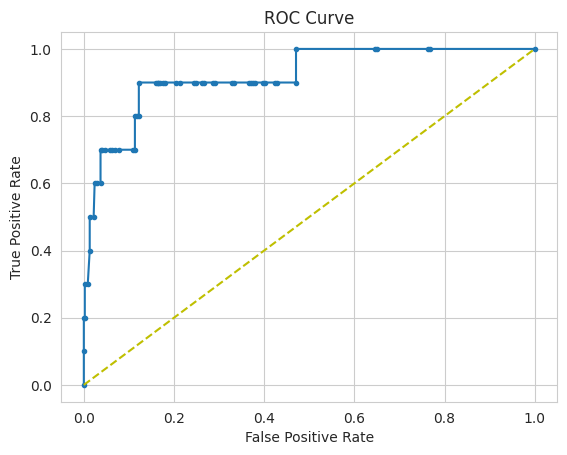

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds= roc_curve(test_df_scaled_selected[event_col],risk_scores_test)
plt.plot(fpr, tpr, marker=".")
plt.plot([0,1], [0,1], 'y--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

<a name="nn"></a>
## Non-linear Survival Analysis with Neural Networks
[Back to Top](#toc)



Remember, Cox's proportional hazards model is a linear model, i.e., the predicted risk score is a linear combination of features. However, the model can easily be extended to the non-linear case by just replacing the linear predictor with the output of a neural network with parameters $\theta$.

In [ ]:
# Convert boolean columns to int
def convert_bool_to_int(df):
    for col in df.select_dtypes(include=[bool]).columns:
        df[col] = df[col].astype(int)
    return df

In [ ]:
nn_train_set = convert_bool_to_int(train_df_scaled.copy())
nn_test_set = convert_bool_to_int(test_df_scaled.copy())

## PyCox

In [ ]:
# Split the Data

# Extract features and targets from nn_train_set
X_train_full = nn_train_set.drop(columns=[time_col, event_col])
Y_duration_train_full = nn_train_set[time_col]
Y_event_train_full = nn_train_set[event_col]

# Split into training and validation
X_train, X_val, Y_duration_train, Y_duration_val, Y_event_train, Y_event_val = train_test_split(
    X_train_full, Y_duration_train_full, Y_event_train_full, test_size=0.2, random_state=n_random_state)

# Extract features and targets from nn_test_set
X_test = nn_test_set.drop(columns=[time_col, event_col])
Y_duration_test = nn_test_set[time_col]
Y_event_test = nn_test_set[event_col]

In [ ]:
# Convert dataframe to PyTorch tensors

X_train = torch.tensor(X_train.values, dtype=torch.float)
Y_duration_train = torch.tensor(Y_duration_train.values, dtype=torch.float)
Y_event_train = torch.tensor(Y_event_train.values, dtype=torch.float)

X_val = torch.tensor(X_val.values, dtype=torch.float)
Y_duration_val = torch.tensor(Y_duration_val.values, dtype=torch.float)
Y_event_val = torch.tensor(Y_event_val.values, dtype=torch.float)

X_test = torch.tensor(X_test.values, dtype=torch.float)
Y_duration_test = torch.tensor(Y_duration_test.values, dtype=torch.float)
Y_event_test = torch.tensor(Y_event_test.values, dtype=torch.float)

Y_train = (Y_duration_train, Y_event_train)
Y_val = (Y_duration_val, Y_event_val)
Y_test = (Y_duration_test, Y_event_test)

In [ ]:
torch.manual_seed(n_random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(n_random_state)
    torch.cuda.manual_seed_all(n_random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Neural Network Architecture
in_features = X_train.shape[1]
num_nodes = [64, 64]
out_features = 1
dropout = 0.3

net = nn.Sequential(
    nn.Linear(in_features, num_nodes[0]),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(num_nodes[0], num_nodes[1]),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(num_nodes[1], out_features)
)

pycox_model = pycox.models.CoxPH(net, torch.optim.Adam)
batch_size = 256
pycox_model.fit(X_train, Y_train, batch_size, epochs=20, callbacks=[], verbose=True, val_data=(X_val, Y_val))

0:	[0s / 0s],		train_loss: 5.1332,	val_loss: 5.5315
1:	[0s / 0s],		train_loss: 4.6151,	val_loss: 5.4186
2:	[0s / 0s],		train_loss: 4.8479,	val_loss: 5.3206
3:	[0s / 0s],		train_loss: 4.8149,	val_loss: 5.2375
4:	[0s / 0s],		train_loss: 4.4584,	val_loss: 5.1673
5:	[0s / 0s],		train_loss: 4.6085,	val_loss: 5.1296
6:	[0s / 0s],		train_loss: 4.3299,	val_loss: 5.1134
7:	[0s / 0s],		train_loss: 4.6019,	val_loss: 5.0924
8:	[0s / 0s],		train_loss: 4.3507,	val_loss: 5.0591
9:	[0s / 0s],		train_loss: 4.1765,	val_loss: 5.0165
10:	[0s / 0s],		train_loss: 4.2035,	val_loss: 4.9495
11:	[0s / 0s],		train_loss: 4.1229,	val_loss: 4.8917
12:	[0s / 0s],		train_loss: 4.4559,	val_loss: 4.8441
13:	[0s / 0s],		train_loss: 4.2268,	val_loss: 4.7974
14:	[0s / 0s],		train_loss: 4.0696,	val_loss: 4.7469
15:	[0s / 0s],		train_loss: 4.1007,	val_loss: 4.7076
16:	[0s / 0s],		train_loss: 4.1742,	val_loss: 4.6681
17:	[0s / 0s],		train_loss: 3.9508,	val_loss: 4.6091
18:	[0s / 0s],		train_loss: 4.0646,	val_loss: 4.5240
19:

In [ ]:
# Add is_monotonic attribute to pandas Series class
if not hasattr(pd.Series, 'is_monotonic'):
    pd.Series.is_monotonic = property(lambda self: self.is_monotonic_increasing)


# Convert tensors back to numpy arrays
Y_duration_test_np = Y_duration_test.numpy()
Y_event_test_np = Y_event_test.numpy()


_ = pycox_model.compute_baseline_hazards()
surv = pycox_model.predict_surv_df(X_test)
ev = EvalSurv(surv, Y_duration_test_np, Y_event_test_np, censor_surv='km')
c_index = ev.concordance_td()
print(f"C-index: {c_index}")

C-index: 0.6724611161939615


## DeepSurv

In [ ]:
# Convert dataframe to PyTorch tensors
def df_to_tensor(df):
    # Convert boolean columns to int
    df = convert_bool_to_int(df)

    # Features - Drop the 'EVENT' column
    X = torch.tensor(df.drop(event_col, axis=1).values, dtype=torch.float32)

    # Time
    T = torch.tensor(df[time_col].values, dtype=torch.float32).unsqueeze(1)

    # Event
    E = torch.tensor(df[event_col].values, dtype=torch.float32).unsqueeze(1)

    return X, T, E

x_train_deepsurv, t_train_deepsurv, e_train_deepsurv = df_to_tensor(train_df_scaled.copy())  # using .copy() to avoid modifying the original dataframe
x_test_deepsurv, t_test_deepsurv, e_test_deepsurv = df_to_tensor(test_df_scaled.copy())


In [ ]:
class CoxPHLoss(nn.Module):
    def forward(self, outputs, labels, events):
        outputs = outputs.squeeze()
        events = events.float()
        risk_set = labels.unsqueeze(0) <= labels.unsqueeze(1)
        log_risk = torch.log(torch.sum(torch.exp(outputs) * risk_set.float(), dim=1))
        log_risk_event = log_risk * events
        loss = torch.sum(outputs - log_risk_event)
        return torch.mean(loss)


class DeepSurv(nn.Module):
    def __init__(self, n_in, hidden_layers_sizes=None, activation="rectify", dropout=None):
        super(DeepSurv, self).__init__()

        # Define layers
        layers = []
        input_size = n_in

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

        for size in hidden_layers_sizes:
            layers.append(nn.Linear(input_size, size))

            if activation == 'rectify':
                layers.append(nn.ReLU())
            elif activation == 'selu':
                layers.append(nn.SELU())
            else:
                raise ValueError("Unknown activation function: %s" % activation)

            if dropout is not None:
                layers.append(nn.Dropout(dropout))

            input_size = size

        # Output layer
        layers.append(nn.Linear(input_size, 1))  # No activation for the output layer

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def train_model(self, train_data, valid_data=None, learning_rate=0.001, n_epochs=500,
                    batch_size=100, validation_frequency=100,  # Reduced validation frequency
                    patience=20, improvement_threshold=0.99999, patience_increase=2,
                    consecutive_increase_threshold=5, verbose=True, **kwargs):  # Added consecutive_increase_threshold

        #optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight_decay

        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)
        criterion = CoxPHLoss()

        x_train, t_train, e_train = train_data
        train_dataset = TensorDataset(x_train, t_train, e_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        if valid_data:
            x_valid, t_valid, e_valid = valid_data

        best_validation_loss = float('inf')
        best_params = None
        best_params_idx = -1
        patience_curr = 0
        consecutive_increase = 0

        for epoch in range(n_epochs):
            running_loss = 0.0
            for batch in train_loader:
                inputs, labels, events = batch

                optimizer.zero_grad()
                outputs = self(inputs)
                #print(torch.isnan(outputs).any())  # Check if there's any NaN in the outputs

                loss = criterion(outputs, labels, events)

                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=1)
                optimizer.step()

                running_loss += loss.item()

            if valid_data and epoch % validation_frequency == 0:
                with torch.no_grad():

                    valid_outputs = self(x_valid)
                    #validation_loss = criterion(valid_outputs, t_valid)
                    validation_loss = criterion(valid_outputs, t_valid, e_valid)
                    scheduler.step(validation_loss)

                    # If validation loss becomes NaN
                    if torch.isnan(validation_loss):
                        print("Validation Loss is NaN. Halting training...")
                        break

                    # Check for improvement in validation loss
                    if validation_loss < best_validation_loss:
                        consecutive_increase = 0  # Reset the counter
                        if validation_loss < best_validation_loss * improvement_threshold:
                            patience_curr = 0
                        best_validation_loss = validation_loss
                        best_params = [p.clone() for p in self.parameters()]
                        best_params_idx = epoch

                    # If validation loss has increased compared to the best observed loss
                    elif validation_loss > best_validation_loss:
                        consecutive_increase += 1
                        patience_curr += 1
                        if consecutive_increase >= consecutive_increase_threshold:
                            print("Validation loss increased consecutively. Early stopping...")
                            break

                    else:
                        patience_curr += 1

                    if verbose:
                        print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {validation_loss.item()}")

                    # If patience has been exhausted
                    if patience_curr > patience:
                        print("Early stopping due to exhausted patience...")
                        break

        return {
            'best_valid_loss': best_validation_loss,
            'best_params': best_params,
            'best_params_idx': best_params_idx
        }





In [ ]:
input_size_deepsurv = x_train_deepsurv.shape[1]

hidden_layer_sizes = [128, 128, 64, 32]

deepsurv_model = DeepSurv(input_size_deepsurv,
                          hidden_layer_sizes,
                          activation='rectify',
                          dropout=0.3)

deepsurv_model_train_result = deepsurv_model.train_model(train_data=(x_train_deepsurv, t_train_deepsurv, e_train_deepsurv),
                               valid_data=(x_test_deepsurv, t_test_deepsurv, e_test_deepsurv),
                               learning_rate=1e-6,
                               n_epochs=500,
                               batch_size=64)

Epoch 1, Training Loss: -382.9769587616126, Validation Loss: -27664.548828125
Epoch 101, Training Loss: -3082.519204711914, Validation Loss: -189386.796875
Epoch 201, Training Loss: -7678.183601888021, Validation Loss: -447704.78125
Epoch 301, Training Loss: -15432.35712483724, Validation Loss: -868308.0625
Epoch 401, Training Loss: -28238.7123819987, Validation Loss: -1560999.0


In [ ]:
torch.manual_seed(n_random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(n_random_state)
    torch.cuda.manual_seed_all(n_random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

with torch.no_grad():
    predictions = deepsurv_model(x_test_deepsurv).numpy().flatten()
    true_times = t_test_deepsurv.numpy().flatten()
    event_observed = e_test_deepsurv.numpy().flatten()

    cindex = concordance_index(true_times, -predictions, event_observed)
    print(f"C-index: {cindex}")


C-index: 0.3674553355866731


<a name="whas"></a>
# The Worcester Heart Attack Study (WHAS) Data
[Back to Top](#toc)



The Worcester Heart Attack Study data is an extensive dataset collected as part of a population-based surveillance study focusing on acute myocardial infarction (AMI) in residents of the Worcester metropolitan area in Massachusetts. The dataset spans three decades from 1975 to 2005. The data provides a comprehensive and in-depth look at the incidence rates, demographic and clinical characteristics, treatment practices, and outcomes related to AMI over a 30-year span. It serves as an invaluable resource for researchers, policy-makers, and clinicians aiming to understand the long-term trends in AMI and the impact of various interventions and societal changes on heart health.

## Load WHAS Dataset

**Variables**

- `afb` Atrial fibrillation, a heart condition that causes an irregular and often abnormally fast heart rate. '0' indicates no atrial fibrillation, '1' indicates the presence of atrial fibrillation.

- `age` Age of the patient in years.

- `av3` Third-degree atrioventricular block, a type of heart block in which the signal from the atria to the ventricles is completely blocked. '0' indicates no third-degree atrioventricular block, '1' indicates the presence of third-degree atrioventricular block.

- `bmi` Body Mass Index, a measure used to determine whether you have a healthy body weight for a certain height. It's defined as the individual's body mass divided by the square of their height.

- `chf` Congestive Heart Failure, a chronic progressive condition that affects the pumping power of your heart muscles. '0' indicates no congestive heart failure, '1' indicates the presence of congestive heart failure.

- `cvd` Cardiovascular disease, a class of diseases that involve the heart or blood vessels. '0' indicates no cardiovascular disease, '1' indicates the presence of cardiovascular disease.

- `diasbp` Diastolic blood pressure, the pressure in the arteries when the heart rests between beats.

- `gender` '0' indicates male, '1' indicates female.

- `hr` Heart rate, the speed of the heartbeat measured by the number of contractions (beats) of the heart per minute (bpm).

- `los` Length of stay, the duration of a single episode of hospitalization.

- `miord` MI Order. '1' indicates Recurrent. '0' indicates First.

- `mitype` MI Type. '1' indicates Q-wave. '2' indicates Not Q-wave. '3' indicates Indeterminate.

- `sho` Cardiogenic shock complications. '1' indicates Yes. '0' indicates No.

- `sysbp` Systolic blood pressure, the pressure in the arteries when the heart beats (when the heart muscle contracts).

- `fstat` Final status, 'True' indicates the event of interest (death) occurred, 'False' indicates it did not occur.

- `lenfol` Length of follow-up, the time period over which an individual was observed, measured in days.

In [ ]:
# Load the WHAS500 dataset
data = load_whas500()
x = data[0]
y = pd.DataFrame(data[1])

whas_df = pd.concat([x, y], axis=1)

print(f"DataFrame shape: {whas_df.shape}")

whas_df.head(1)

DataFrame shape: (500, 16)


afb   age av3       bmi chf cvd  diasbp gender    hr  los miord mitype sho  \
0   1  83.0   0  25.54051   0   1    78.0      0  89.0  5.0     1      0   0   

   sysbp  fstat  lenfol  
0  152.0  False  2178.0

In [ ]:
#### Define event, time and other predictors

event_col = 'fstat'
time_col = 'lenfol'

numeric_cols_without_time = ["age", "bmi", "diasbp", "hr", "los", "sysbp"]

numeric_cols = numeric_cols_without_time + [time_col]

categorical_cols_without_event = ["afb", "av3", "chf",
                                  "cvd", "gender", "miord",
                                  "mitype", "sho"]

categorical_cols = categorical_cols_without_event + [event_col]

def add_to_list_if_not_present(lst, item):
    if item not in lst:
        lst.append(item)
    return lst

In [ ]:
#### Check for missing variables

if len(missing_cols(whas_df)) == 0:
  print("There are no missing values.")

There are no missing values.


## Histograms

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'diasbp'}>],
       [<Axes: title={'center': 'hr'}>, <Axes: title={'center': 'los'}>,
        <Axes: title={'center': 'sysbp'}>],
       [<Axes: title={'center': 'lenfol'}>, <Axes: >, <Axes: >]],
      dtype=object)

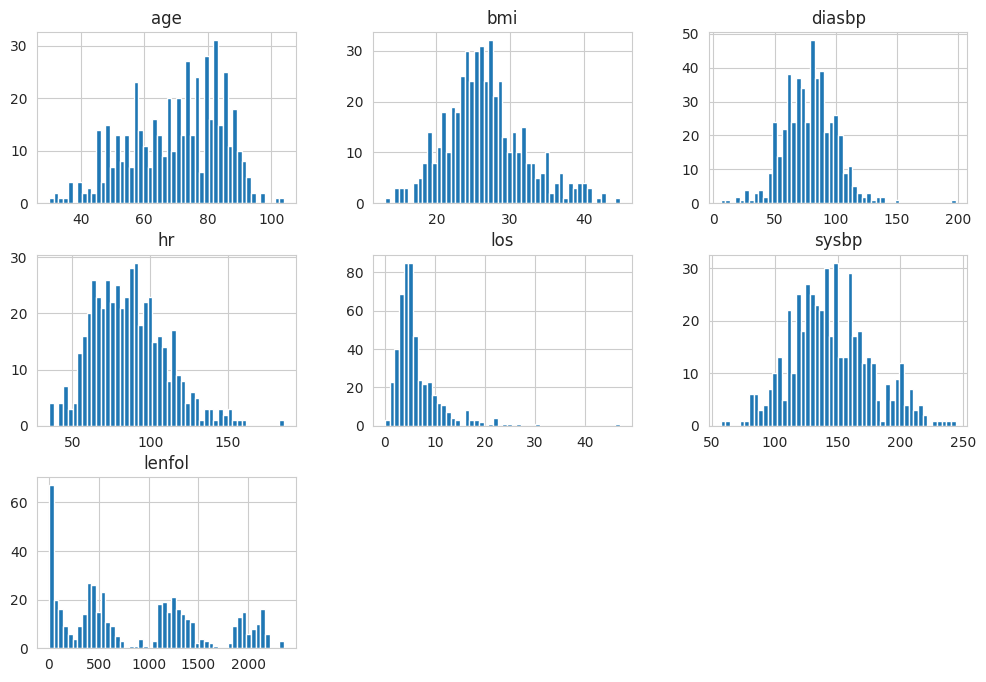

In [ ]:
whas_df.hist(bins=50, figsize=(12, 8))

## Categorical Variables - Plots

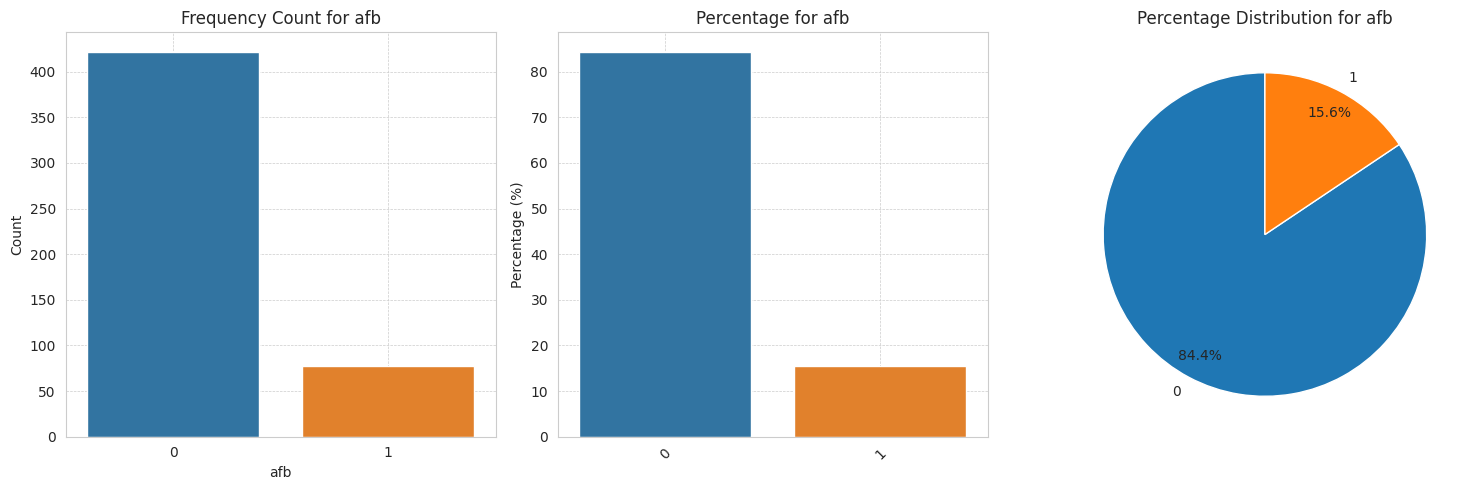

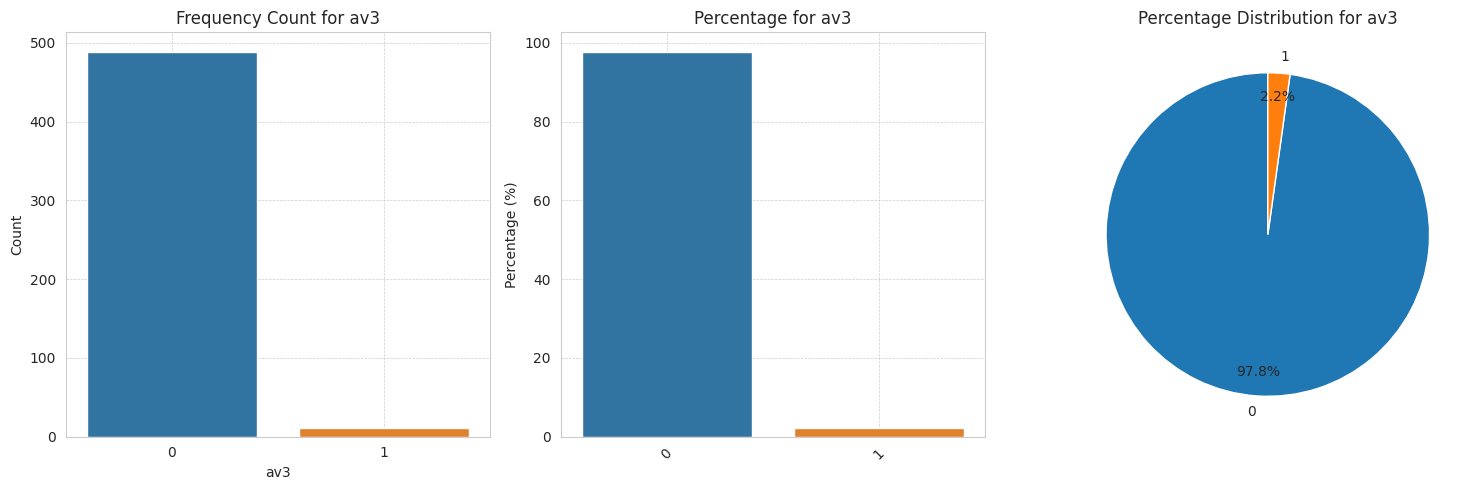

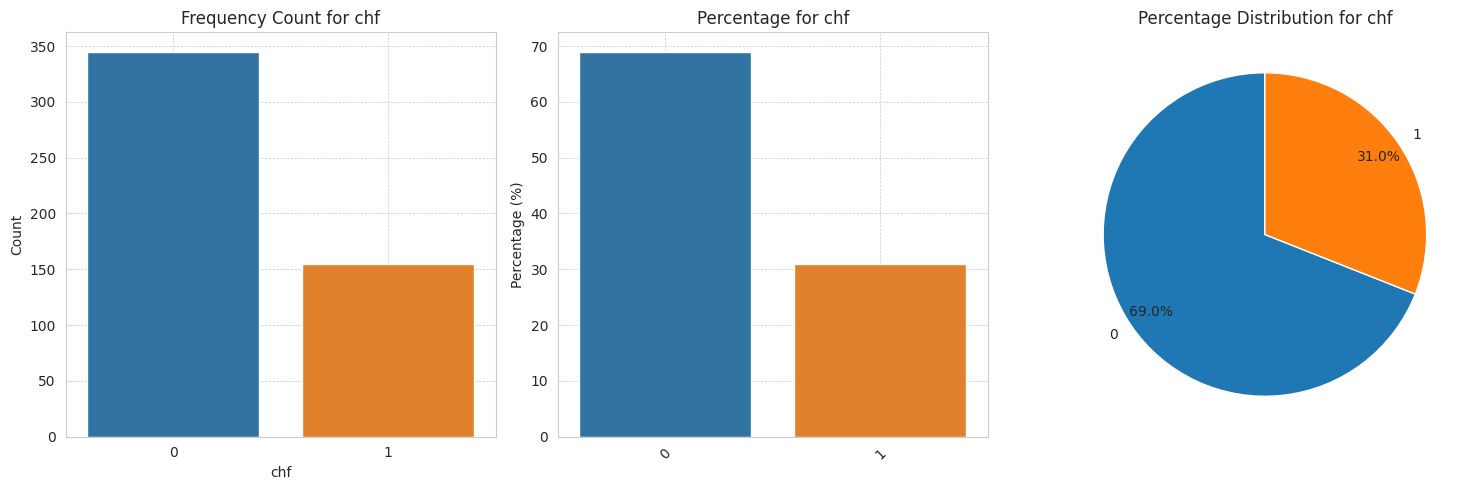

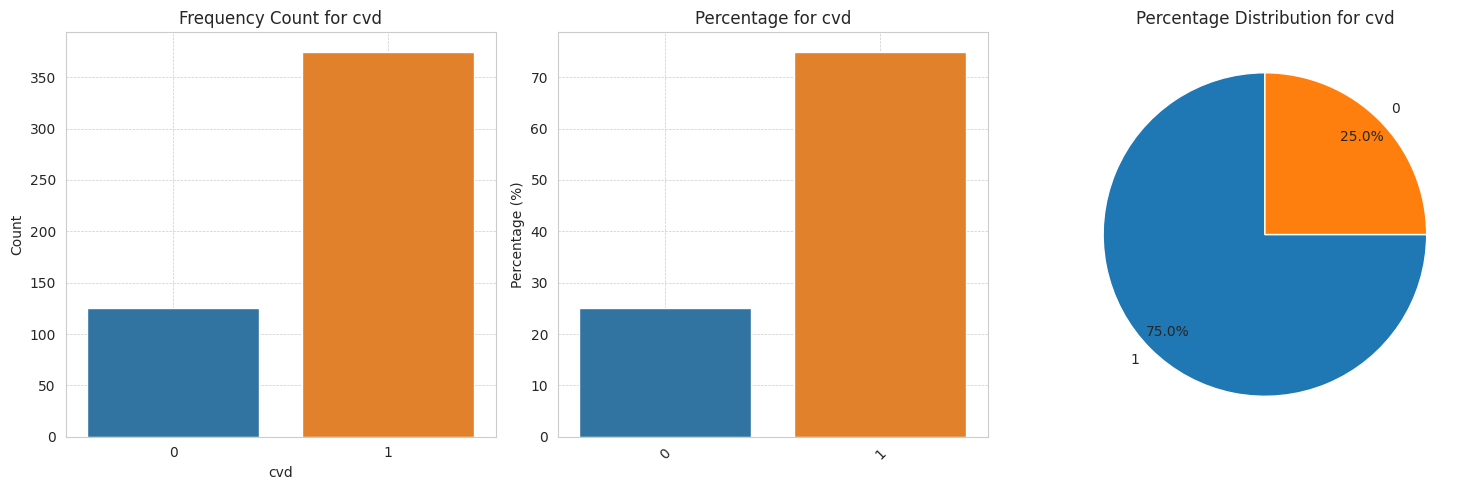

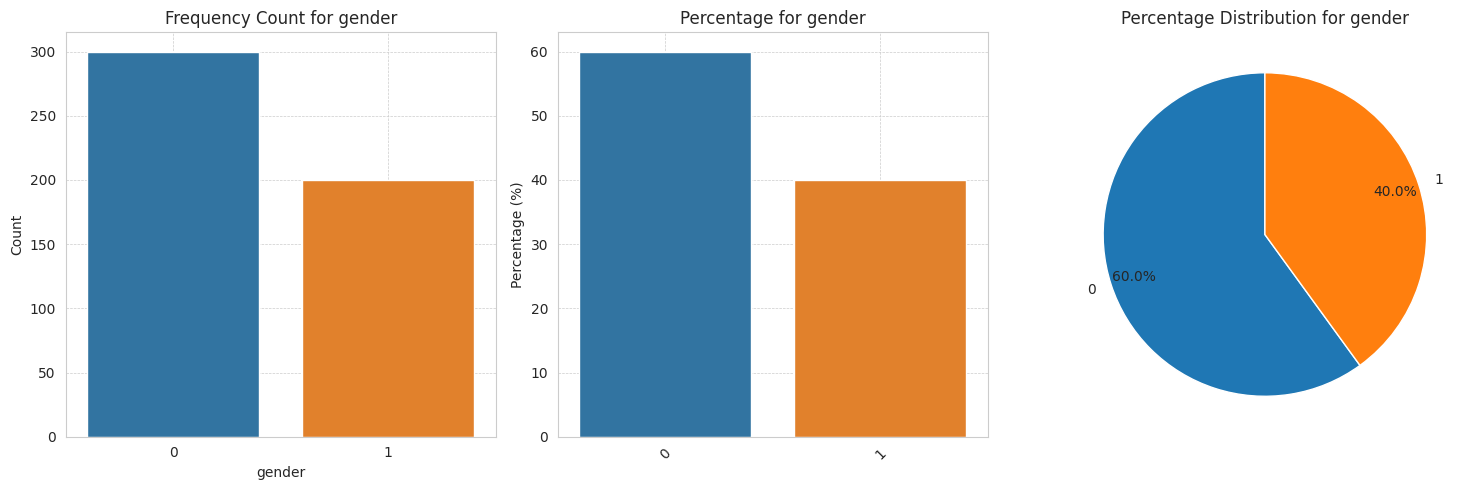

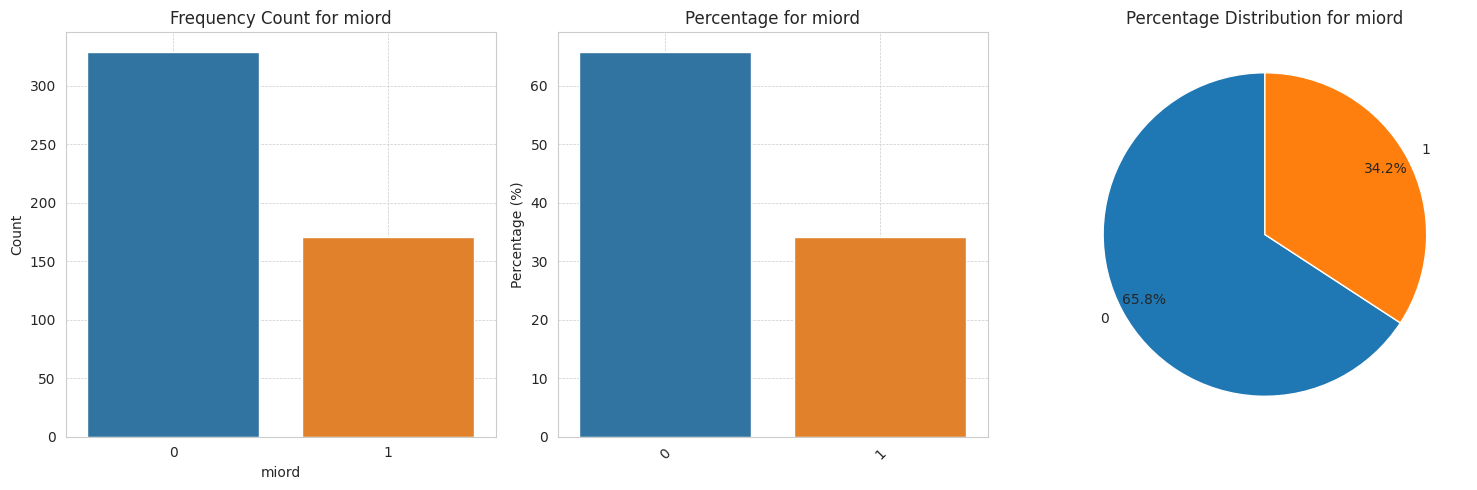

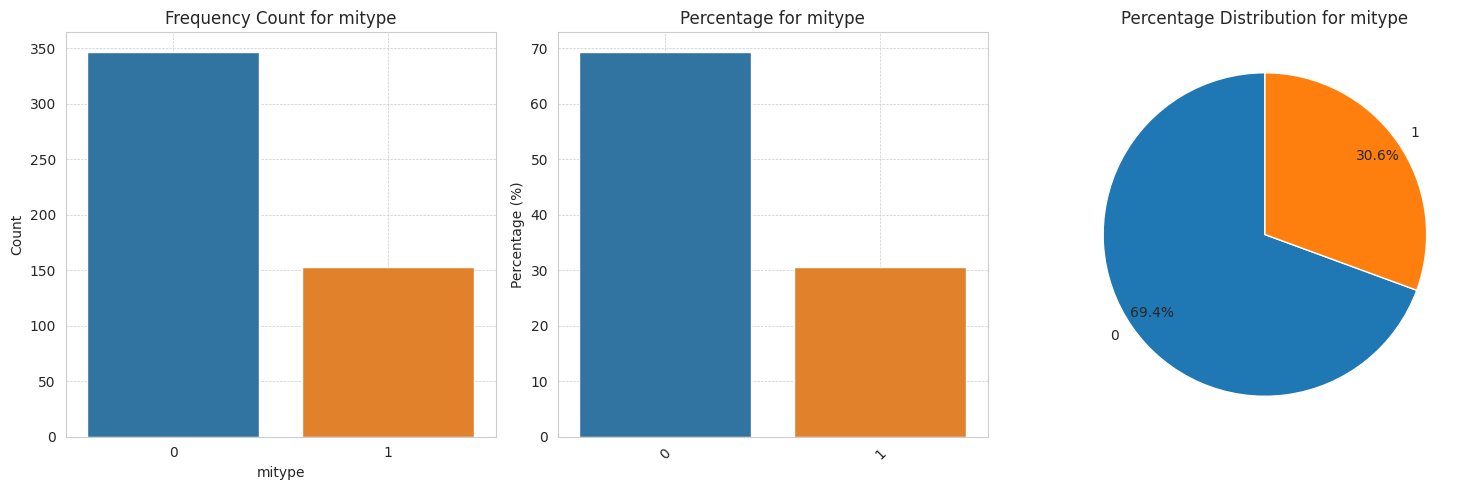

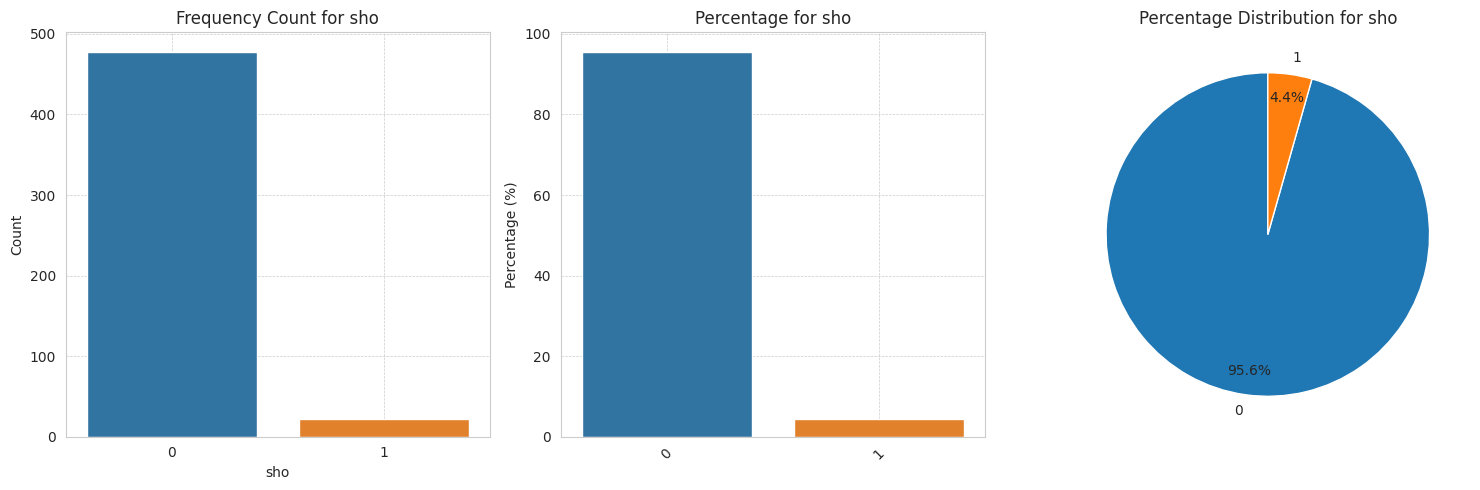

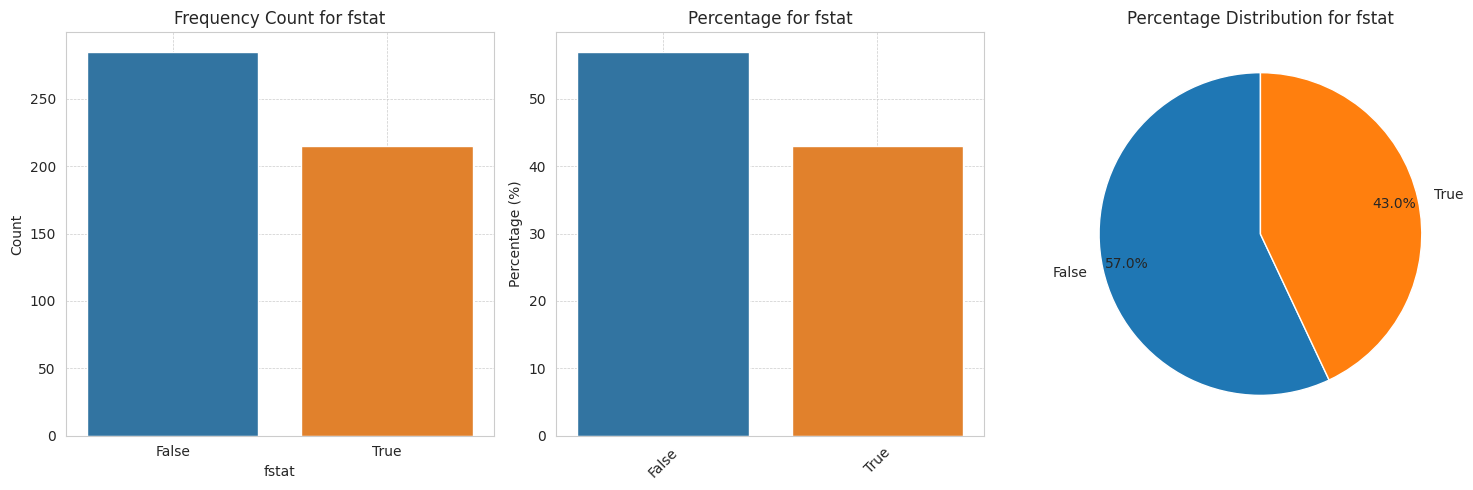

In [ ]:
plot_categorical_cols(whas_df, categorical_cols)

## Test Set

In [ ]:
#### Group age

# Define the bin edges
age_bins = [0,30, 40, 50, 60, float('inf')]  # Covering all possible age groups including <30

# Define the labels for the bins
age_labels = ['<30', '30-40', '40-50', '50-60', '>60']

# Bin the 'age' column
whas_df['age_group'] = pd.cut(whas_df['age'], bins=age_bins, labels=age_labels, right=False)


In [ ]:
categorical_cols_without_event = add_to_list_if_not_present(categorical_cols_without_event, "age_group")
categorical_cols = add_to_list_if_not_present(categorical_cols, "age_group")

In [ ]:
# Create a combined column for stratification
combined_cols = ["gender","age_group"]

whas_df['COMBINED_STRAT'] = whas_df[combined_cols].astype(str).agg('_'.join, axis=1)

print(whas_df['COMBINED_STRAT'].value_counts())

0_>60      194
1_>60      168
0_50-60     60
0_40-50     36
1_50-60     25
0_30-40     10
1_40-50      6
1_30-40      1
Name: COMBINED_STRAT, dtype: int64


In [ ]:
# Removing the rows with '1_30-40'
whas_df = whas_df[whas_df['COMBINED_STRAT'] != '1_30-40']

In [ ]:
# Split the data into Train and Test
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = n_random_state)

for train_index, test_index in sss.split(whas_df, whas_df['COMBINED_STRAT']):
    strat_train_set = whas_df.iloc[train_index]
    strat_test_set = whas_df.iloc[test_index]

# Drop the combined column post split
strat_train_set = strat_train_set.drop('COMBINED_STRAT', axis=1)
strat_test_set = strat_test_set.drop('COMBINED_STRAT', axis=1)
whas_df = whas_df.drop('COMBINED_STRAT', axis=1)

In [ ]:
#### Check imbalanced distributions

for cols in combined_cols:
    comparison = compare_distributions(whas_df, strat_train_set, strat_test_set, cols)
    print((comparison * 100).round(2))
    print("\n" + "="*100 + "\n")

                 Overall %  Train %  Test %  Strat. Error %  Rand. Error %
gender Category                                                           
0                    60.12    60.15    60.0            0.05           -0.2
1                    39.88    39.85    40.0           -0.08            0.3


                    Overall %  Train %  Test %  Strat. Error %  Rand. Error %
age_group Category                                                           
<30                      0.00     0.00     0.0             NaN            NaN
30-40                    2.00     2.01     2.0            0.05          -0.20
40-50                    8.42     8.52     8.0            1.24          -4.95
50-60                   17.03    17.04    17.0            0.05          -0.20
>60                     72.55    72.43    73.0           -0.16           0.63




### Section Summary


To ensure a balanced representation of the `gender` and `age group` in both the training and test sets, we employ the technique of StratifiedShuffleSplit.

We discovered that the combination `1_30-40` appeared only once in the data before attempting the split. Given that the StratifiedShuffleSplit requires each class to have a minimum of two instances, we removed this particular entry.

## Univariate and Bivariate Analysis

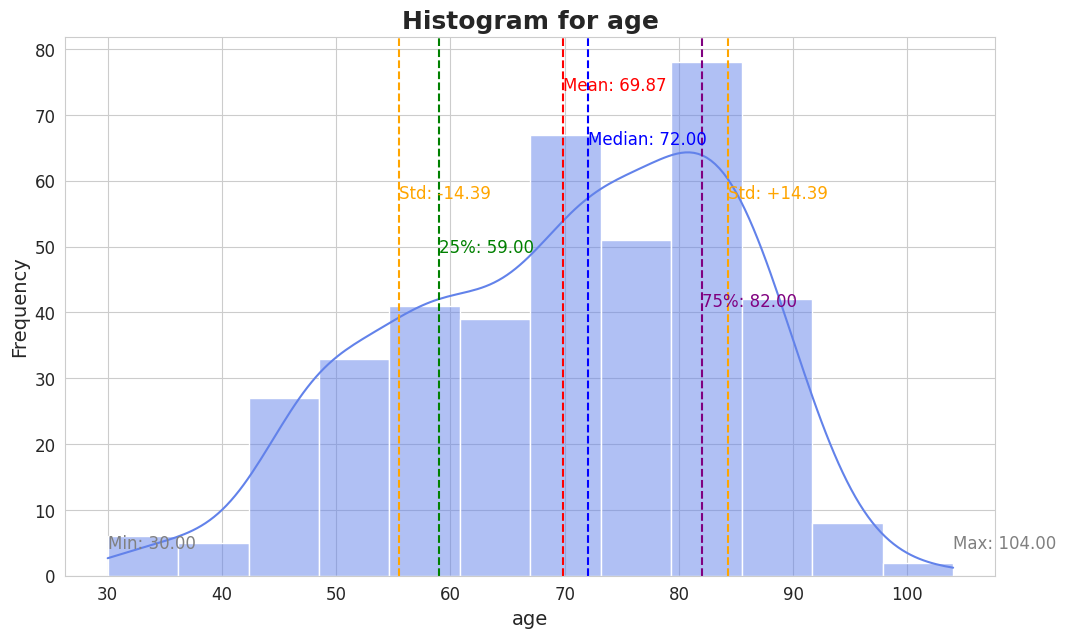

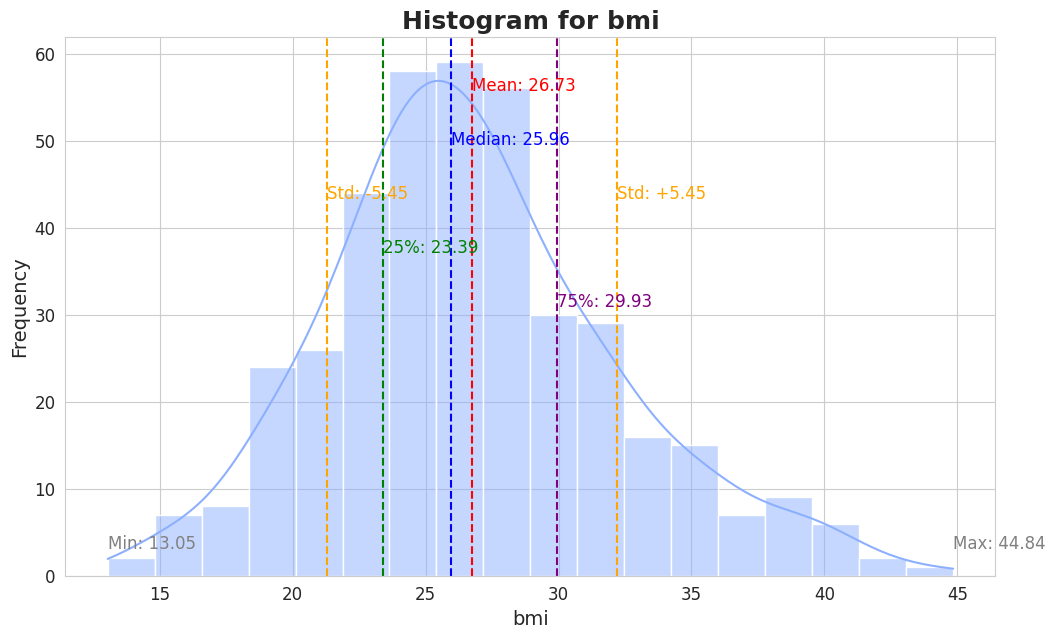

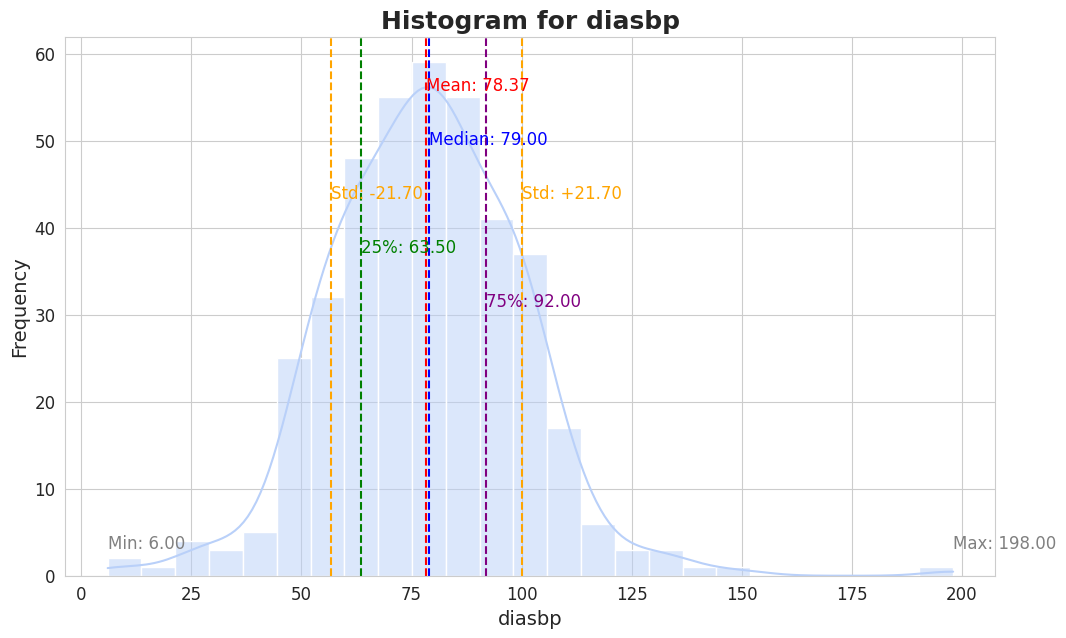

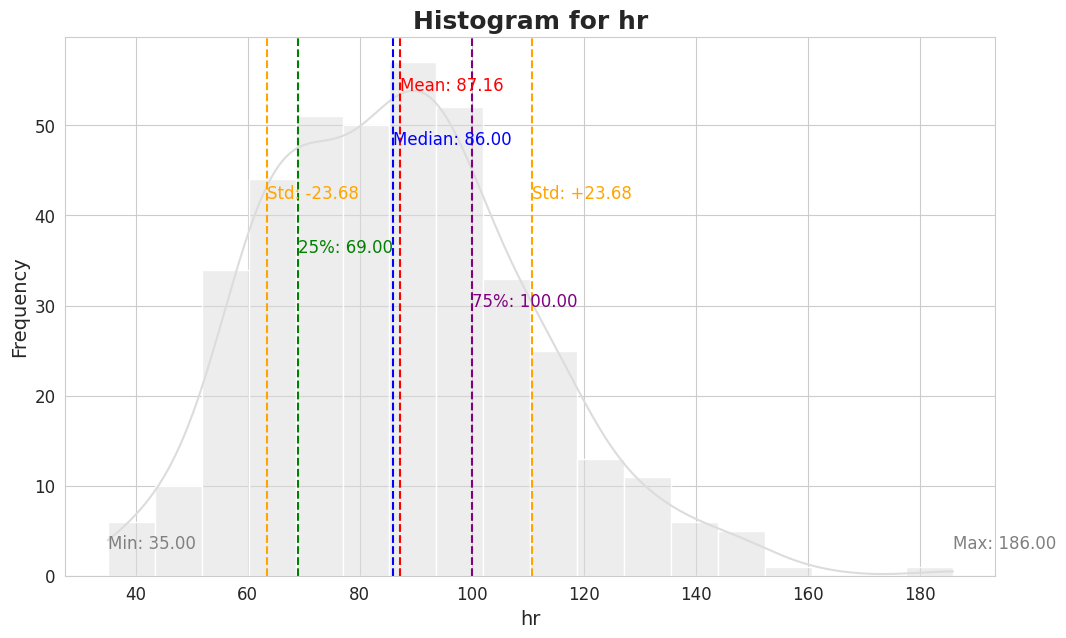

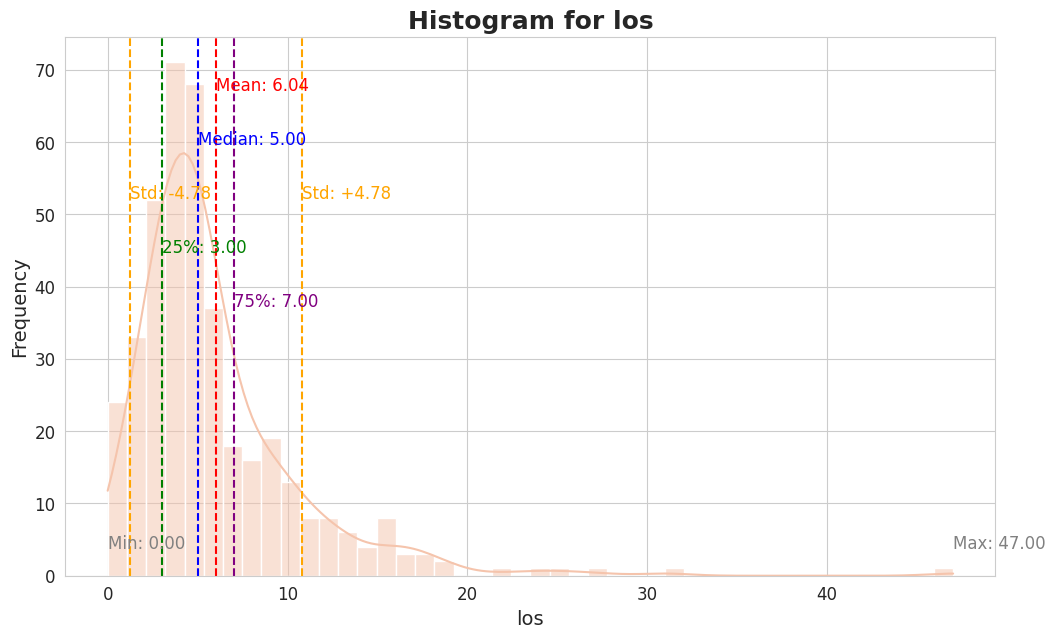

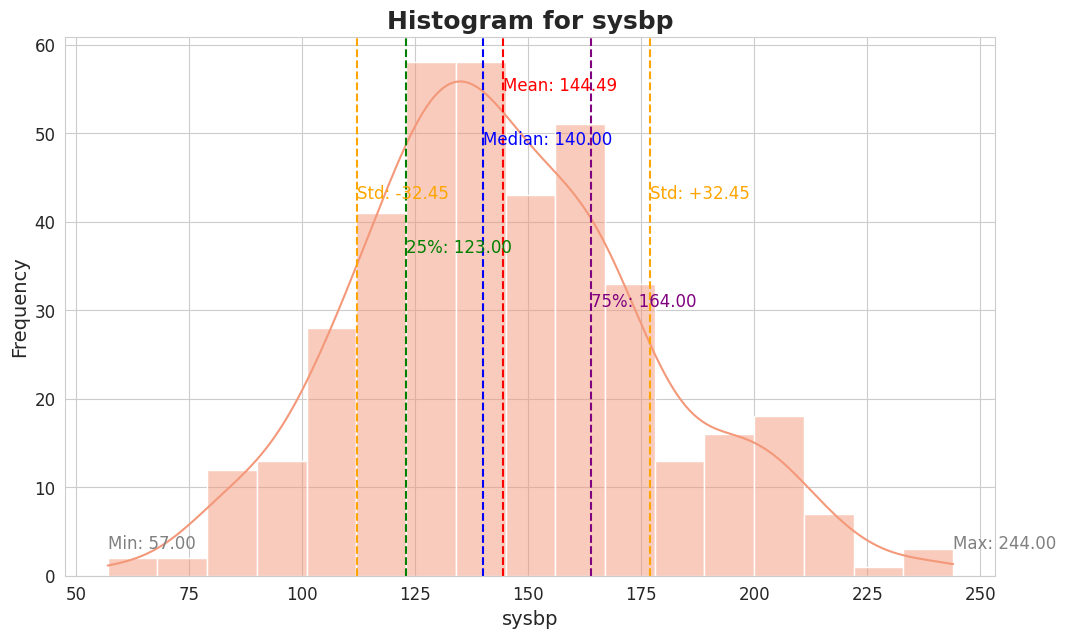

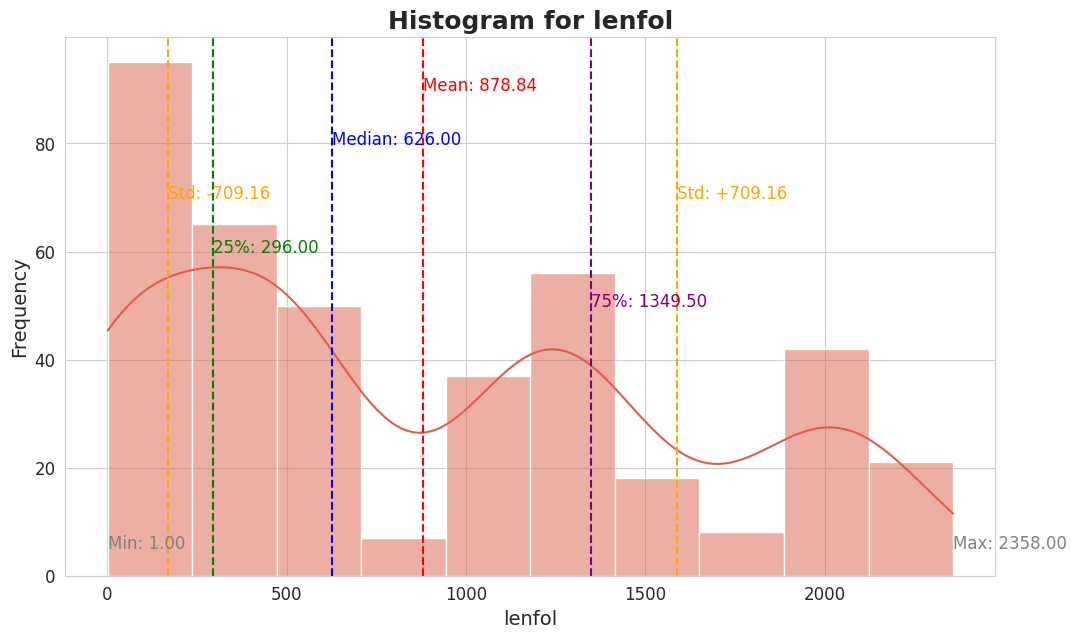

In [ ]:
#### Numeric Variables

plot_numeric_cols(strat_train_set, numeric_cols)

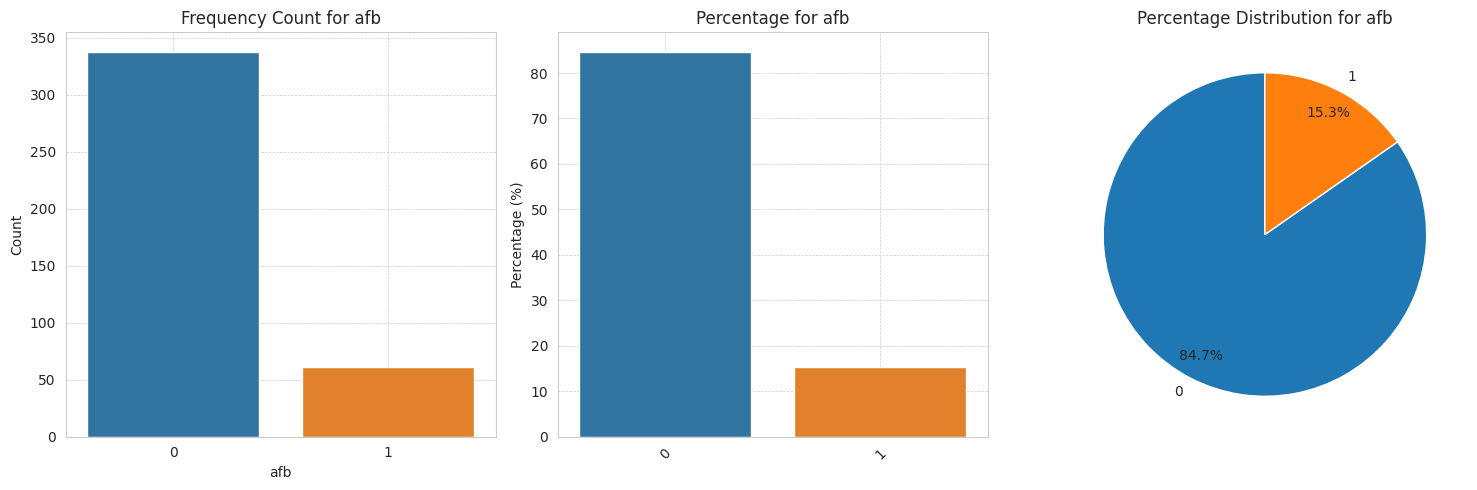

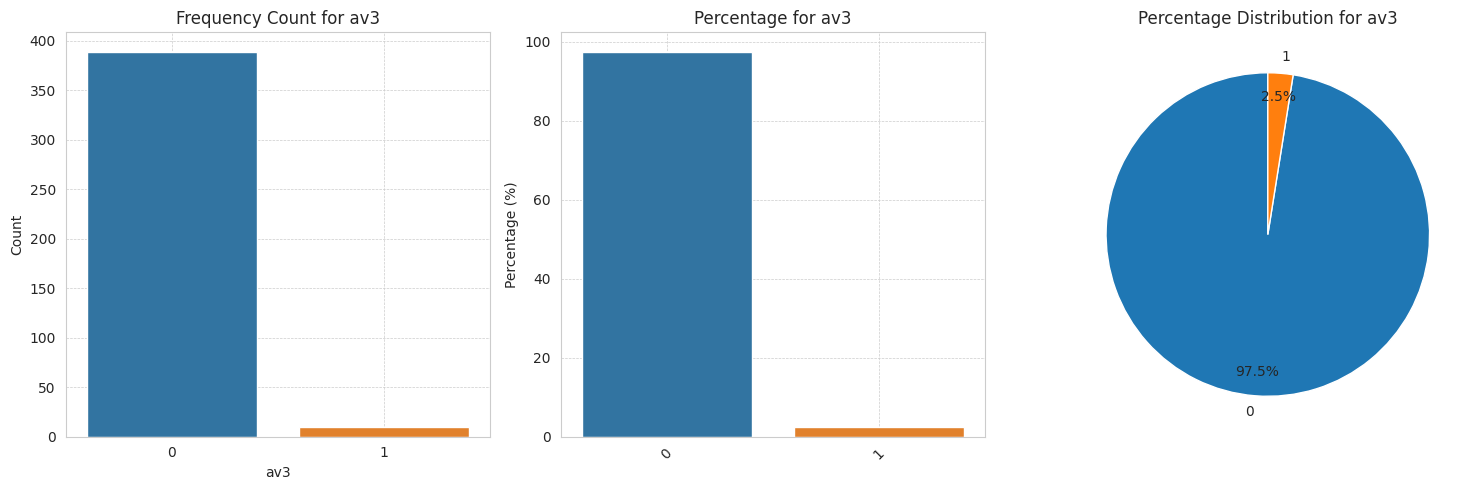

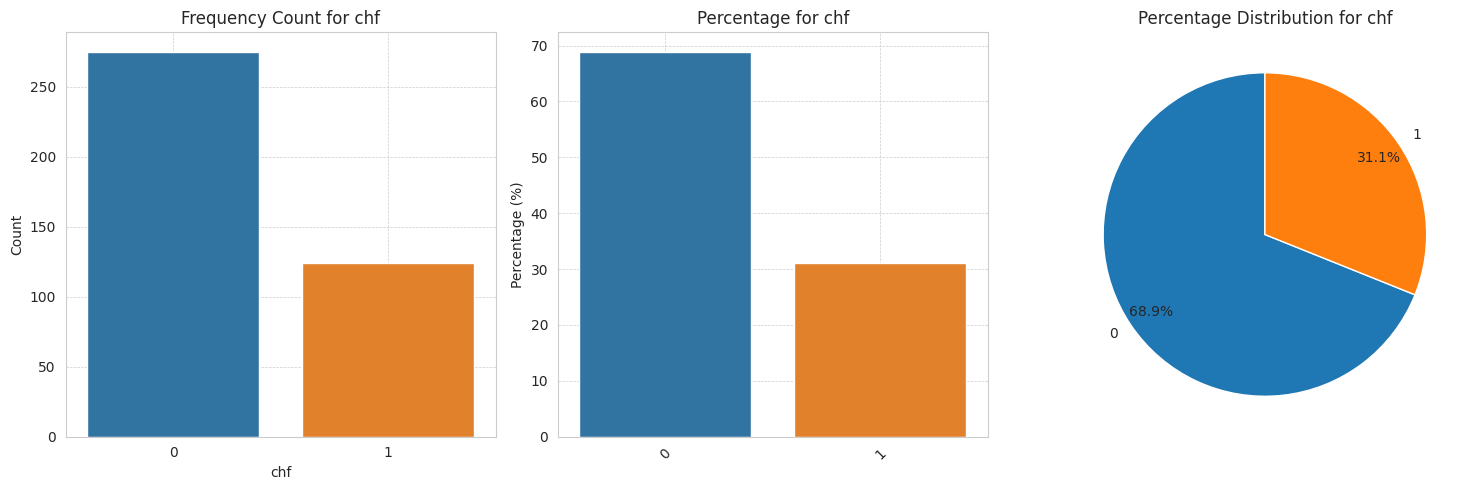

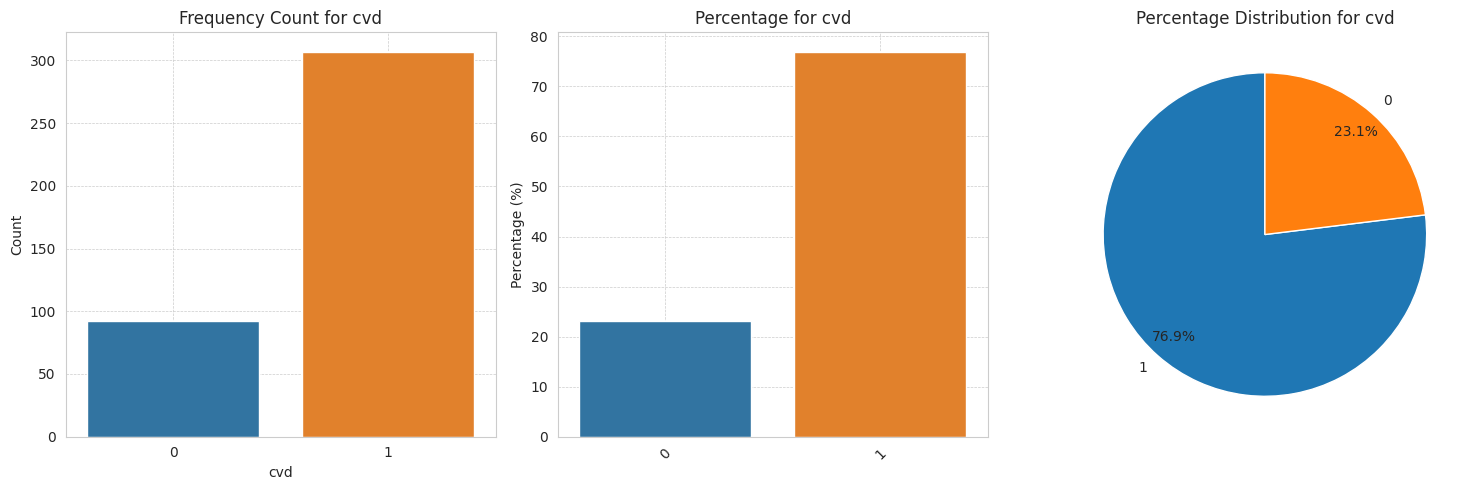

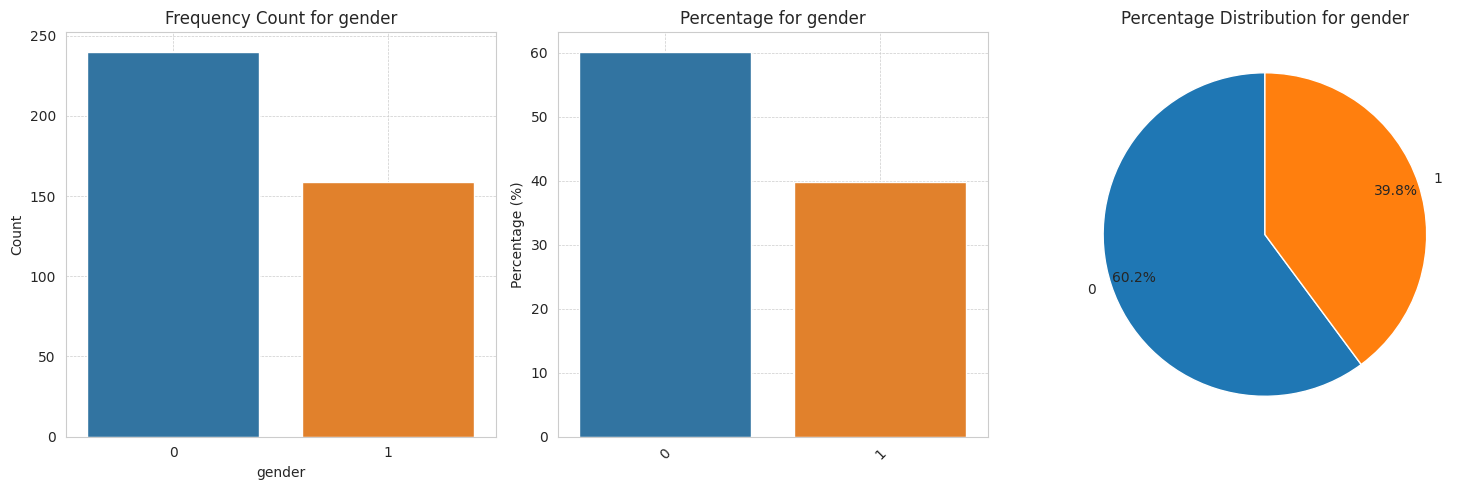

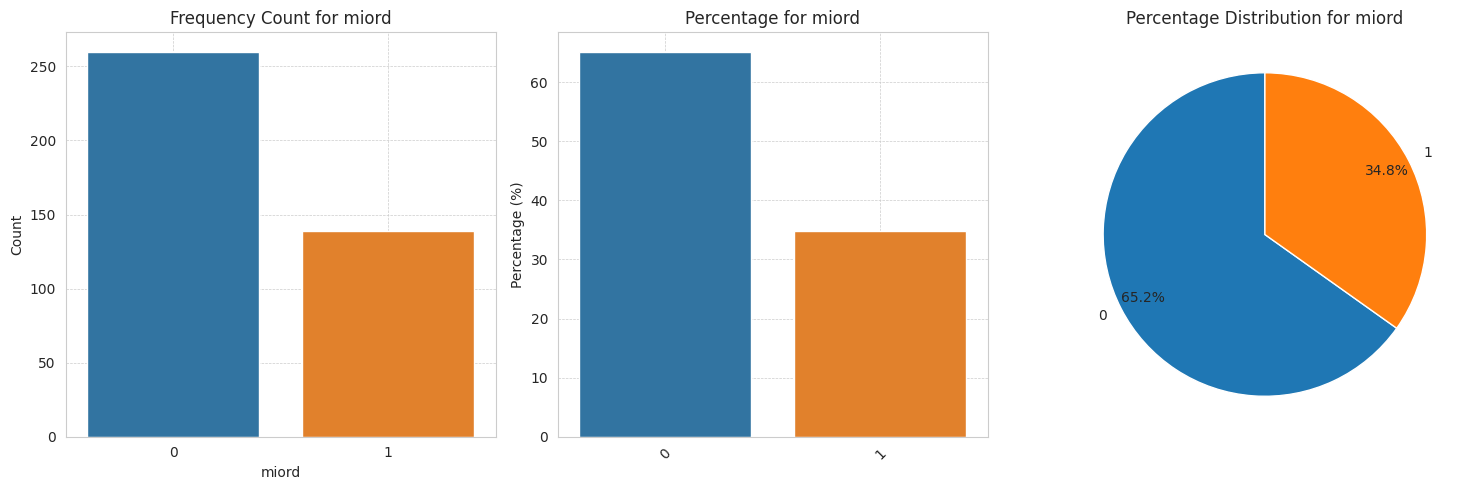

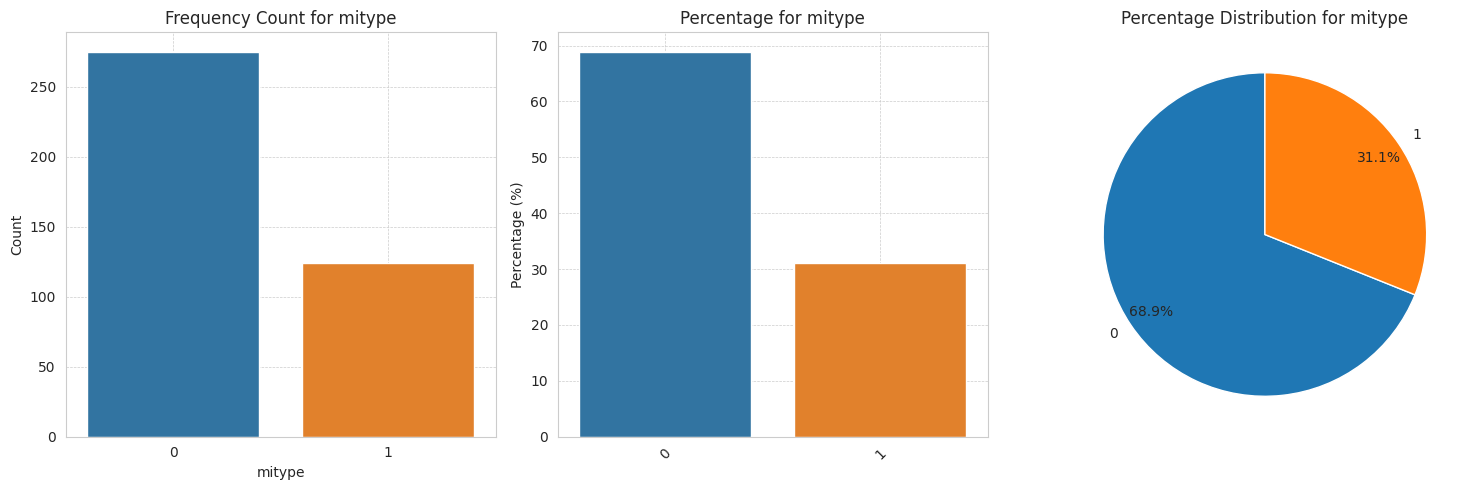

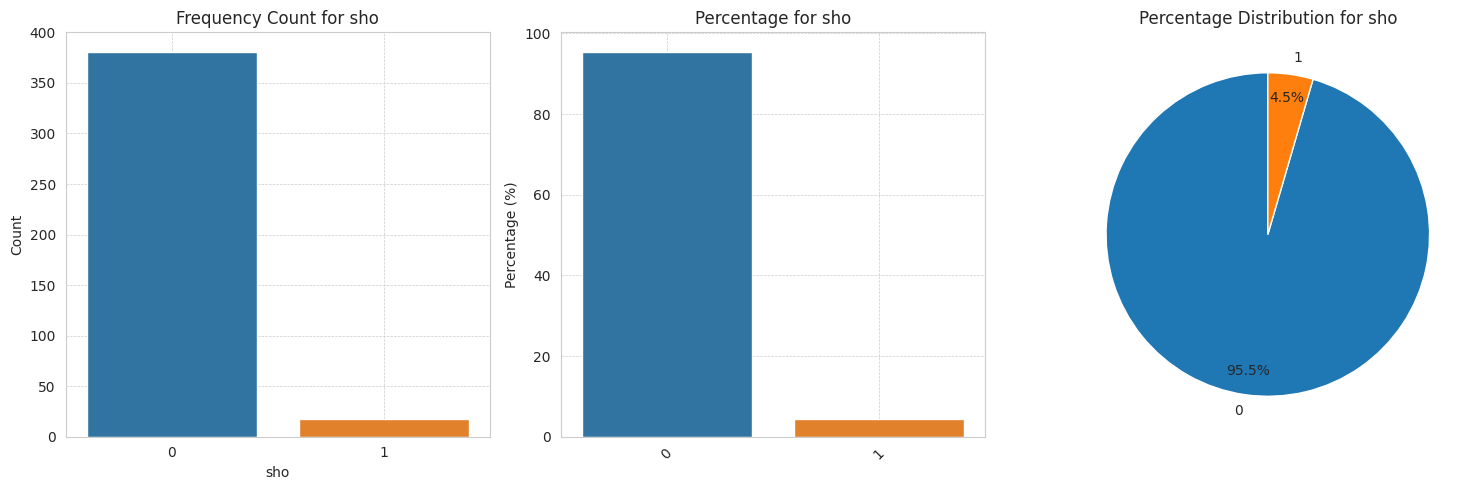

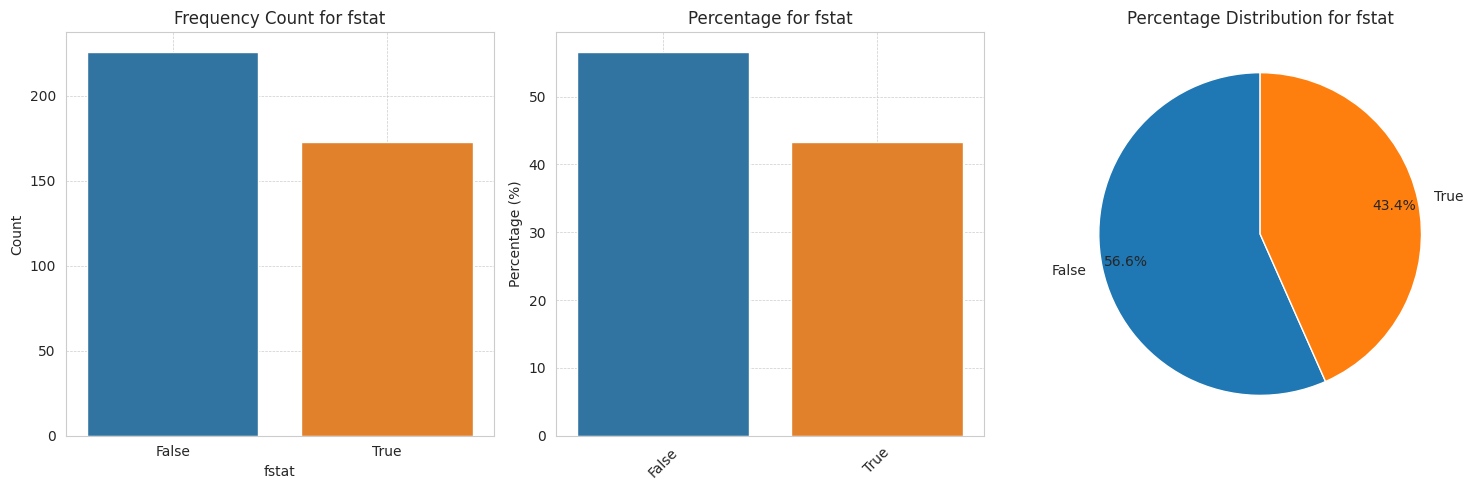

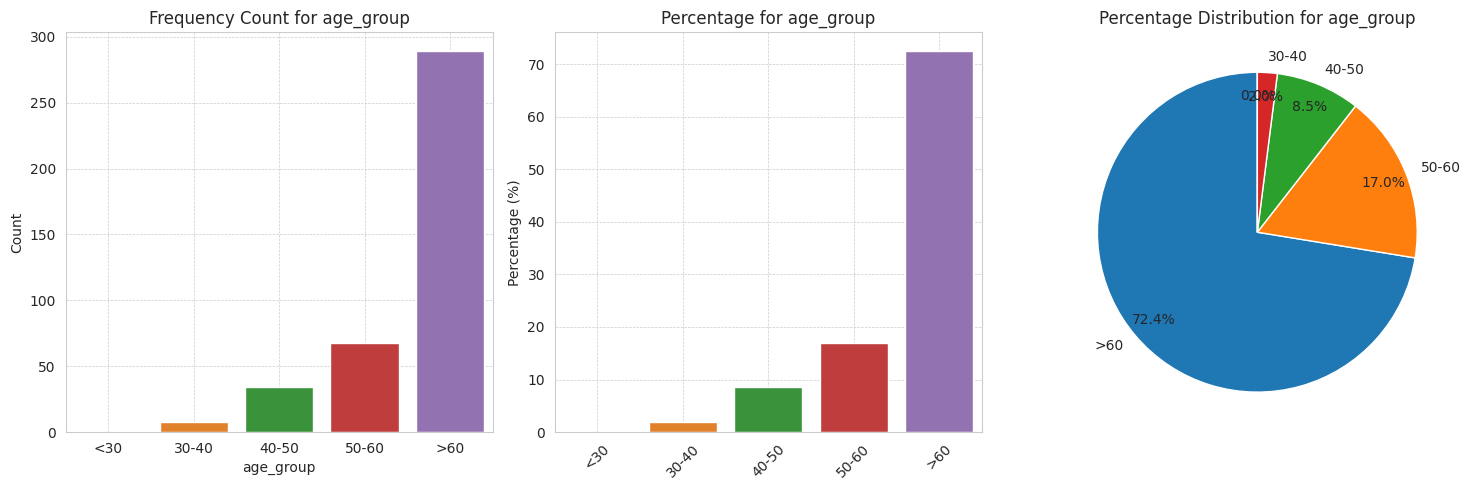

In [ ]:
#### Categorical variables

plot_categorical_cols(strat_train_set, categorical_cols)

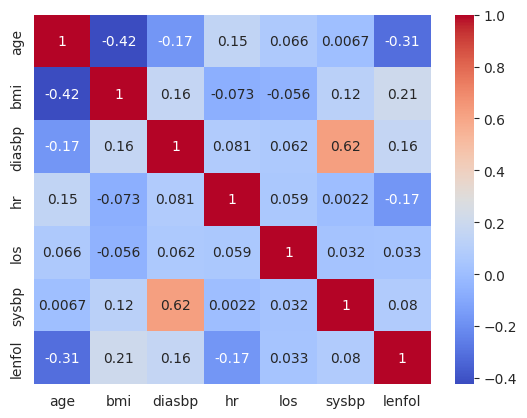

In [ ]:
# Correlation Heatmap

correlation_matrix = strat_train_set[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

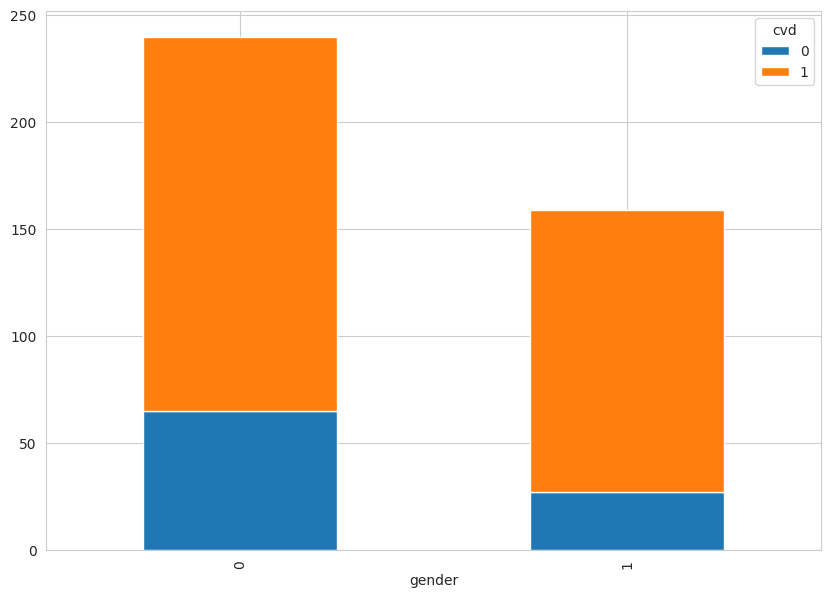

In [ ]:
cross_tab = pd.crosstab(strat_train_set['gender'], strat_train_set['cvd'])

# Plot as a stacked bar chart
cross_tab.plot(kind='bar', stacked=True, figsize=(10,7))
plt.show()

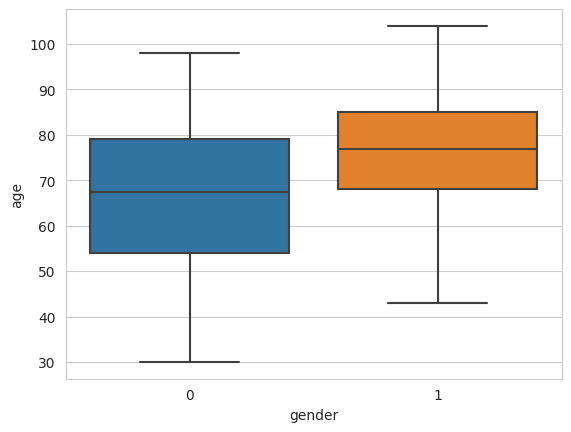

In [ ]:
#### Categorical vs Numerical

sns.boxplot(data=strat_train_set, x='gender', y='age')
plt.show()

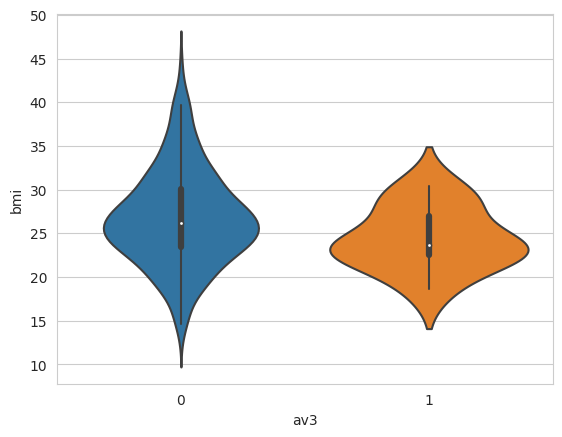

In [ ]:
sns.violinplot(data=strat_train_set, x='av3', y='bmi')
plt.show()

**EVENT Analysis - Numerical Variables**

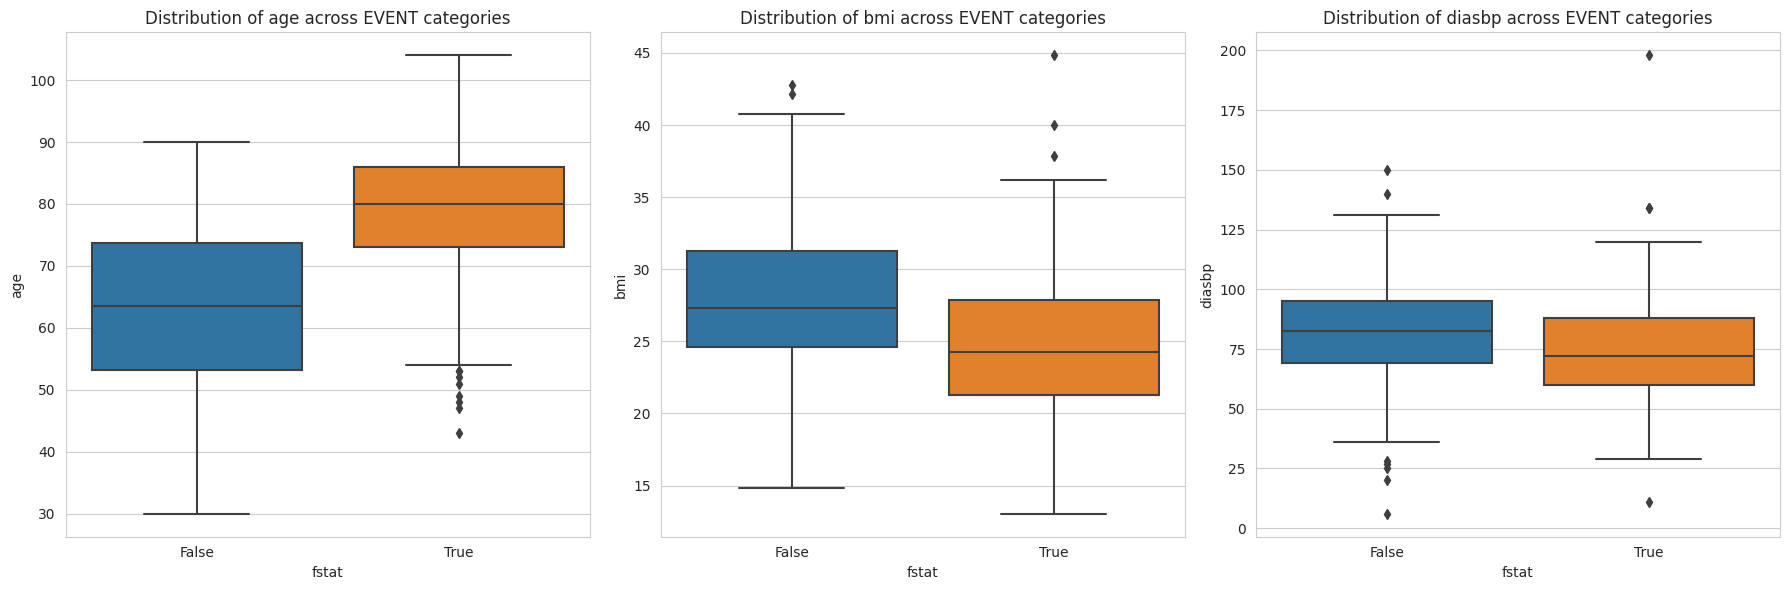

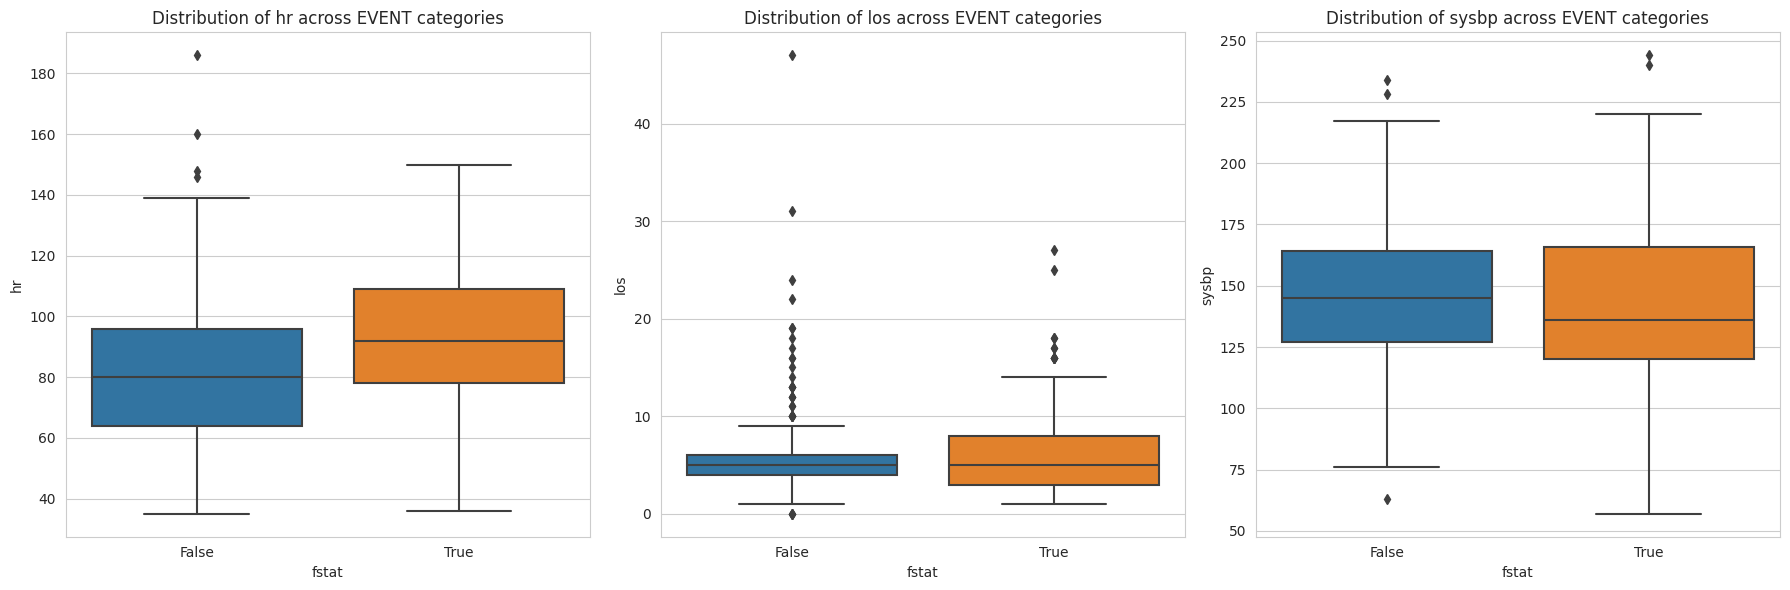

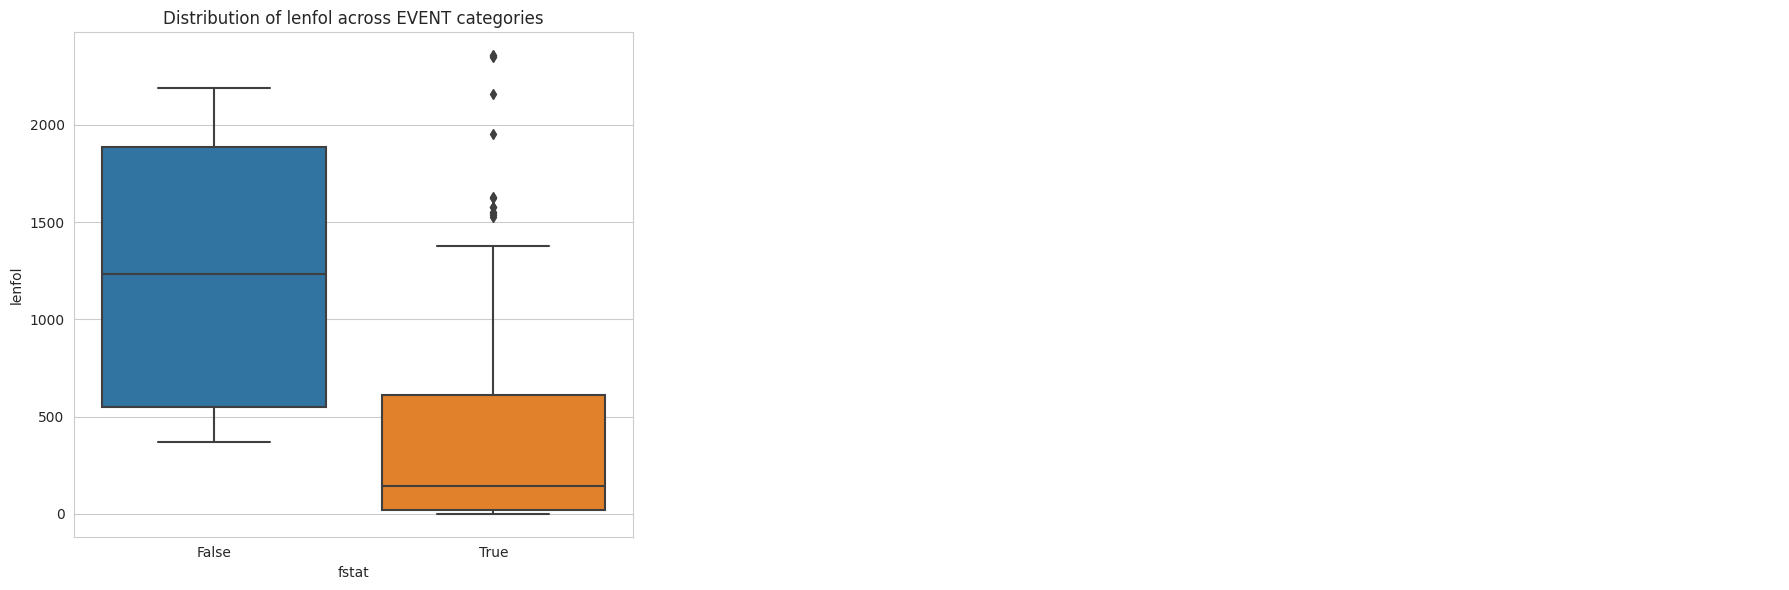

In [ ]:
# Number of columns in each subplot row
n_cols = 3

for i, col in enumerate(numeric_cols):
    # Create a new figure with subplots for every 3 columns
    if i % n_cols == 0:
        fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(18, 6))
        # Turn off all axes to begin with; we'll turn them back on when used
        for ax in axes:
            ax.axis('off')

    # Plot the boxplot on the correct subplot
    sns.boxplot(data=strat_train_set, x=event_col, y=col, ax=axes[i % n_cols])
    axes[i % n_cols].set_title(f'Distribution of {col} across EVENT categories')
    axes[i % n_cols].axis('on')  # Turn the axis back on

    # Show the figure after every 3 columns or on the last column
    if (i+1) % n_cols == 0 or i == len(numeric_cols) - 1:
        plt.tight_layout()
        plt.show()

**EVENT Analysis - Categorical Variables**

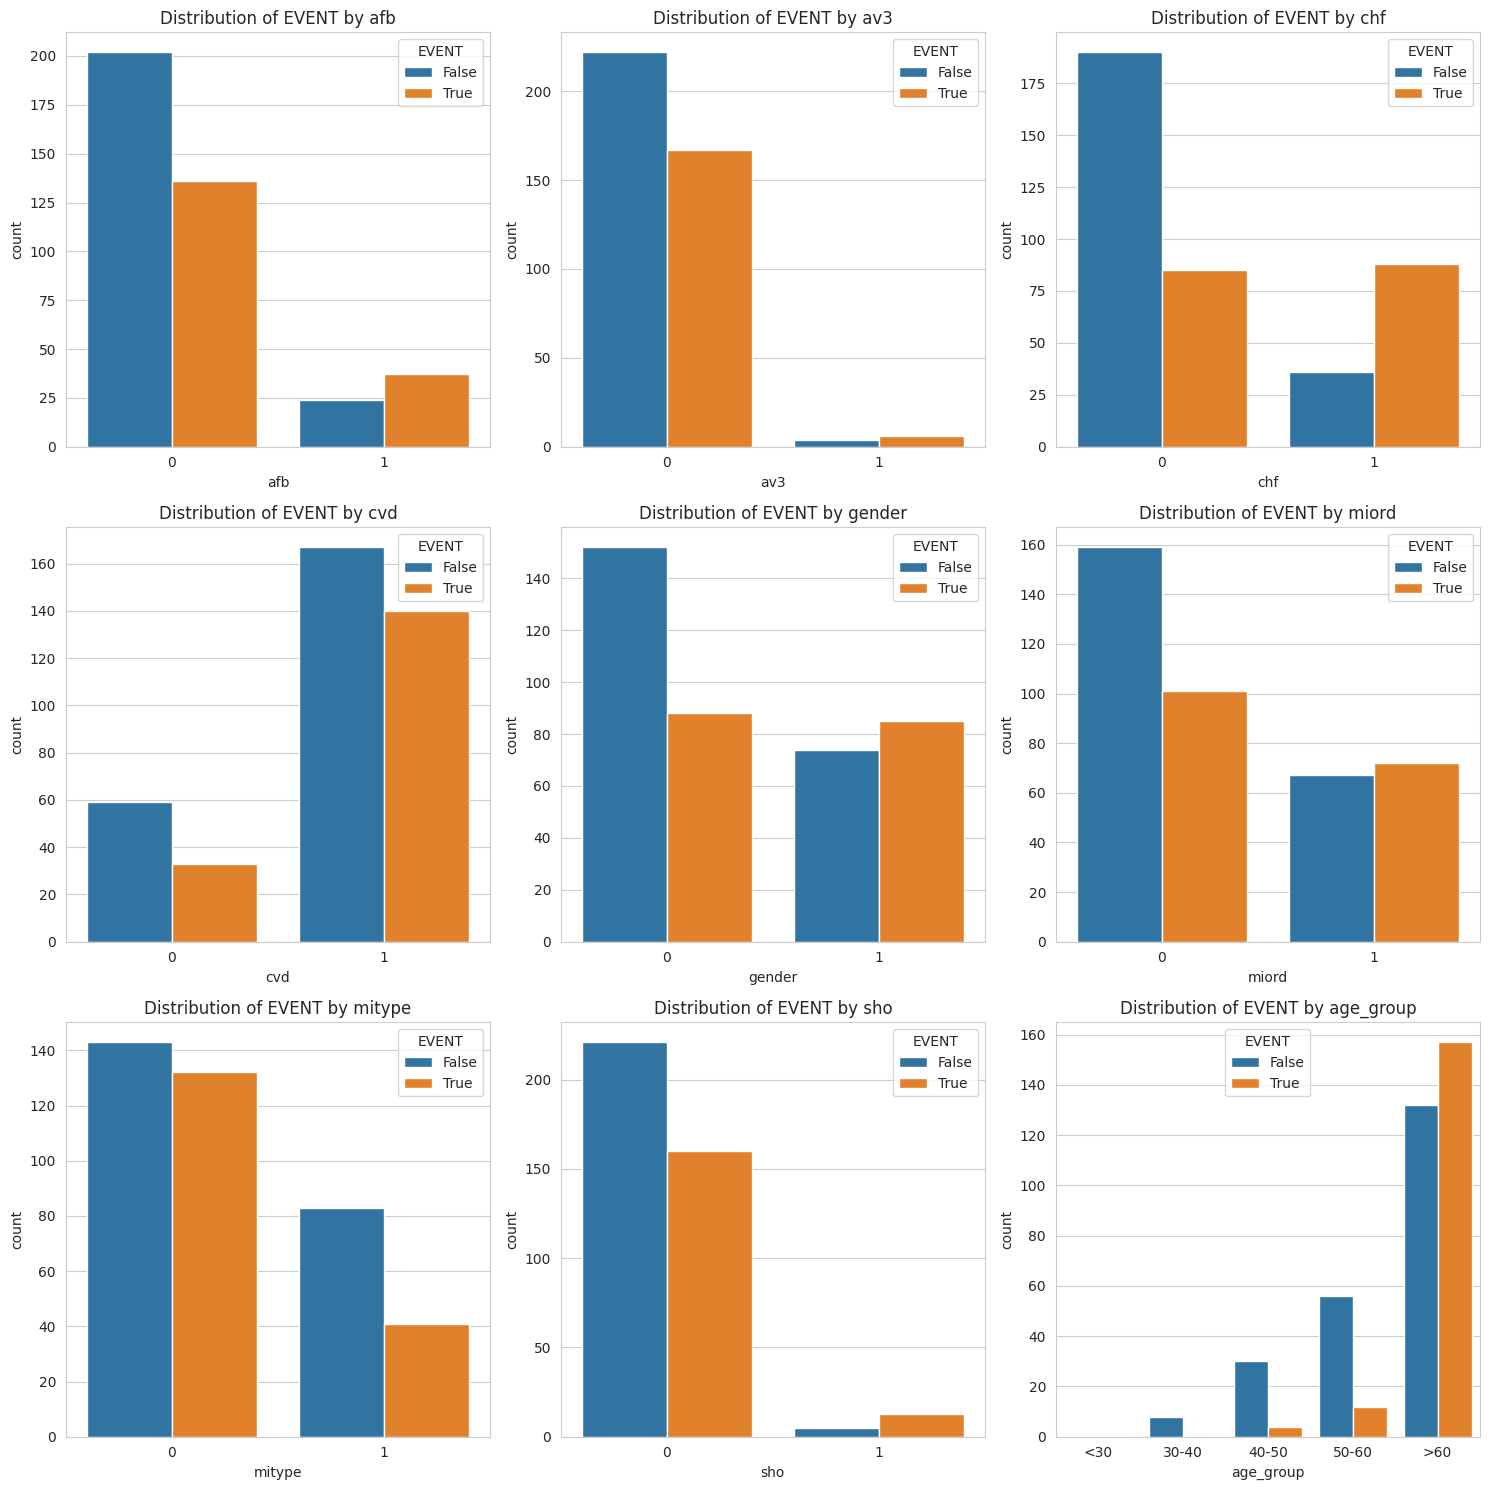

In [ ]:
n_rows = -(-len(categorical_cols_without_event) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# If there's only one row (axes is 1D), make it 2D for consistent indexing
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)

# Go through the categorical columns and plot them
for idx, col in enumerate(categorical_cols_without_event):
    current_row, current_col = divmod(idx, n_cols)
    ax = axes[current_row, current_col]
    sns.countplot(x=col, hue=event_col, data=strat_train_set, ax=ax)
    ax.set_title(f'Distribution of EVENT by {col}')
    ax.legend(title='EVENT')

# If the total number of plots isn't a multiple of n_cols, some subplots remain empty.
# We can turn these off for a cleaner look.
for empty_idx in range(len(categorical_cols_without_event), n_rows * n_cols):
    current_row, current_col = divmod(empty_idx, n_cols)
    axes[current_row, current_col].axis('off')

plt.tight_layout()
plt.show()

**EVENT Analysis - Statistical Testing**

In [ ]:
for col in categorical_cols_without_event:
    if strat_train_set[col].nunique() == 2:
        group1 = strat_train_set[event_col][strat_train_set[col] == strat_train_set[col].unique()[0]]
        group2 = strat_train_set[event_col][strat_train_set[col] == strat_train_set[col].unique()[1]]

        t_stat, p_val = ttest_ind(group1, group2)
        print(f"T-test for {col}: T-stat: {t_stat}, P-value: {p_val}")
    else:
        # Perform ANOVA
        groups = [strat_train_set[event_col][strat_train_set[col] == group] for group in strat_train_set[col].unique()]
        f_stat, p_val = f_oneway(*groups)
        print(f"ANOVA for {col}: F-stat: {f_stat}, P-value: {p_val}")

T-test for afb: T-stat: -2.9874762711785987, P-value: 0.0029875072108176124
T-test for av3: T-stat: -1.074339791554258, P-value: 0.28332294661201063
T-test for chf: T-stat: -8.037689675753127, P-value: 1.0596128391717364e-14
T-test for cvd: T-stat: 1.6539437800278673, P-value: 0.09892935125153927
T-test for gender: T-stat: 3.3519415697691137, P-value: 0.0008794656214118376
T-test for miord: T-stat: -2.5006694390689495, P-value: 0.012798079398606341
T-test for mitype: T-stat: 2.806601645995732, P-value: 0.005253372926667879
T-test for sho: T-stat: -2.542886095350113, P-value: 0.011372820663037915
ANOVA for age_group: F-stat: 19.905766788244325, P-value: 4.912350401123594e-12


### Section Summary

For comparing `EVENT` across the groups in each categorical variable, we use ANOVA if the categorical variable has more than two levels/groups, or a T-test if it only has two.

For each variable tested (`afb`, `av3`, `chf`, `cvd`, `gender`, `miord`, `mitype`, and `sho`), the statistical outcomes suggest varying degrees of significance. Specifically, the variables `chf`, `gender`, `miord`, `mitype`, and `sho` show p-values less than the commonly accepted significance threshold of 0.05, indicating they might have different means concerning the associated outcome. On the other hand, for `av3`, `cvd`, and potentially others, given their p-values exceed 0.05, we don't have sufficient evidence to state that their means differ significantly concerning the outcome in question.

## Survival Analysis

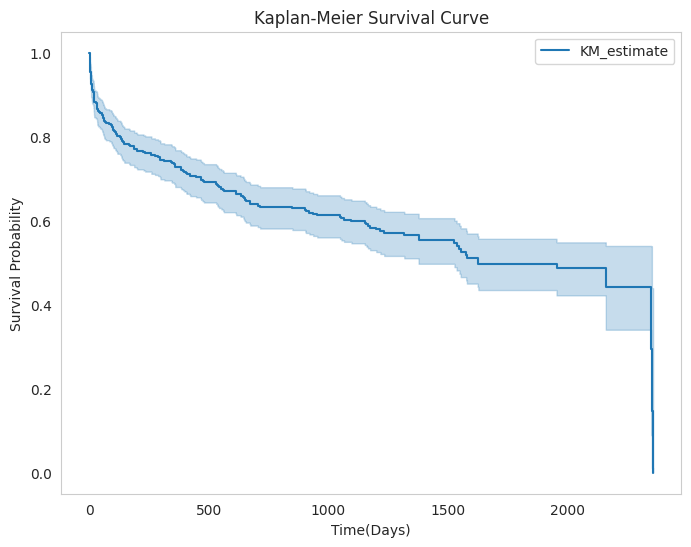

In [ ]:
#### Survival curve - Overall

plot_km_curves(strat_train_set, time_col, event_col,x_axis_name="Time(Days)")

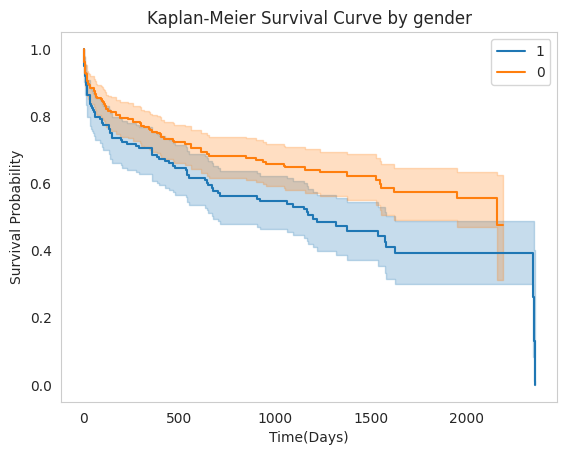

In [ ]:
#### Suvival curve - Gender

plot_km_curves(strat_train_set, time_col, event_col, stratify_by='gender',x_axis_name="Time(Days)")

## Data Preprocessing and Feature Engineering


**Creating Mean Arterial Pressure (MAP)**

$\text{MAP}=\text{diasbp}+\frac{1}{3}(\text{sysbp}-\text{diasbp})$

In [ ]:
strat_train_cleaned = strat_train_set.copy()
strat_test_cleaned = strat_test_set.copy()

In [ ]:
strat_train_cleaned['MAP'] = strat_train_cleaned['diasbp'] + (1/3) * (strat_train_cleaned['sysbp'] - strat_train_cleaned['diasbp'])
strat_test_cleaned['MAP'] = strat_test_cleaned['diasbp'] + (1/3) * (strat_test_cleaned['sysbp'] - strat_test_cleaned['diasbp'])

In [ ]:
numeric_cols_without_time = add_to_list_if_not_present(numeric_cols_without_time, "MAP")
numeric_cols = add_to_list_if_not_present(numeric_cols, "MAP")

In [ ]:
#### Categorical variables

unique_values = strat_train_cleaned[categorical_cols].apply(pd.Series.unique)
print(unique_values)

afb                                                                     ['0', '1']
Categories (2, object): ['0', '1']
av3                                                                     ['0', '1']
Categories (2, object): ['0', '1']
chf                                                                     ['0', '1']
Categories (2, object): ['0', '1']
cvd                                                                     ['1', '0']
Categories (2, object): ['0', '1']
gender                                                                  ['1', '0']
Categories (2, object): ['0', '1']
miord                                                                   ['0', '1']
Categories (2, object): ['0', '1']
mitype                                                                  ['0', '1']
Categories (2, object): ['0', '1']
sho                                                                     ['0', '1']
Categories (2, object): ['0', '1']
fstat                                                   

In [ ]:
#### Convert 2 value categories `fstat` into binary variables

replacements = {
    'fstat': {'True': 1, 'False': 0}
}

convert_categorical_to_binary(strat_train_cleaned, replacements)
convert_categorical_to_binary(strat_test_cleaned, replacements)

In [ ]:
#### onvert  `age_group` into dummy variables

strat_train_cleaned = pd.get_dummies(strat_train_cleaned, columns=['age_group'])
strat_test_cleaned = pd.get_dummies(strat_test_cleaned, columns=['age_group'])

strat_train_cleaned = strat_test_cleaned.drop("age_group_<30", axis=1)
strat_test_cleaned = strat_test_cleaned.drop("age_group_<30", axis=1)

#### Normalization

train_df_scaled = strat_train_cleaned.copy()
test_df_scaled = strat_test_cleaned.copy()

scaler = StandardScaler()

# Fit the scaler on the training data and transform it
train_df_scaled[numeric_cols] = scaler.fit_transform(train_df_scaled[numeric_cols])

# Transform the test data using the same scaler (don't fit the scaler on the test data!)
test_df_scaled[numeric_cols] = scaler.transform(test_df_scaled[numeric_cols])

## Further Analysis - Pre Model

**Univariate Analysis with CPH**

Perform univariate Cox regression for each feature against the outcome to determine if there is any significant relationship.
Retain features that are statistically significant based on a predefined p-value threshold, e.g., p < 0.05.

In [ ]:
cph = CoxPHFitter()
significant_features = []

for col in train_df_scaled.columns.difference([time_col, event_col]):
    try:
        cph.fit(train_df_scaled[[col, time_col, event_col]], duration_col=time_col, event_col=event_col)

        # Extract the p-value for the current feature
        p_value = cph.summary.loc[col, 'p']

        if p_value < 0.05:  # Check if p-value is less than 0.05
            significant_features.append(col)
            print(f"Feature: {col}, p-value: {p_value}")
    except ConvergenceError:
        print(f"Feature: {col} caused convergence error.")
        continue

print("\nSignificant Features:", significant_features)

Feature: MAP, p-value: 0.010629865450713778
Feature: age, p-value: 3.7702811350980136e-07
Feature: age_group_50-60, p-value: 0.03570233184165613
Feature: age_group_>60, p-value: 0.0020477235445430894
Feature: bmi, p-value: 0.011335736807475141
Feature: chf, p-value: 1.6489036109525337e-05
Feature: diasbp, p-value: 0.0008192158231671776
Feature: hr, p-value: 0.0018616336962304105
Feature: los, p-value: 0.006868242635903717
Feature: mitype, p-value: 0.004406719122516077
Feature: sho caused convergence error.

Significant Features: ['MAP', 'age', 'age_group_50-60', 'age_group_>60', 'bmi', 'chf', 'diasbp', 'hr', 'los', 'mitype']


**Check for High Correlation Among Features:**

Compute a correlation matrix for our dataset and check if any pairs of variables have a very high correlation (e.g., absolute correlation > 0.7).

In [ ]:
corr_matrix = train_df_scaled.drop([event_col, time_col], axis=1).corr().abs()
high_corr_var=np.where(corr_matrix>0.7)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
print(high_corr_var)

[('age', 'age_group_>60'), ('diasbp', 'MAP'), ('sysbp', 'MAP'), ('age_group_50-60', 'age_group_>60')]


In [ ]:
remove_high_corr_cols = ["diasbp","sysbp","age_group_50-60","age_group_40-50"]

train_df_scaled = train_df_scaled.drop(remove_high_corr_cols, axis=1)
test_df_scaled = test_df_scaled.drop(remove_high_corr_cols, axis=1)


#### For NN model
# train_df_scaled.to_csv("trained_df_whas.csv", sep=',', index=False)
# test_df_scaled.to_csv("test_df_whas.csv", sep=',', index=False)


In [ ]:
X = train_df_scaled.drop([event_col, time_col], axis=1)
y = train_df_scaled[[time_col, event_col]]

feature_cols = X.columns.tolist()
selector = RFE(estimator=CoxPH(feature_names=feature_cols),
               n_features_to_select=10) # We pick top 10
selector.fit(X, y)

# Get the ranking of the features
feature_ranking = pd.Series(selector.ranking_, index=feature_cols)
print(feature_ranking.sort_values())

age                1
av3                1
bmi                1
chf                1
gender             1
hr                 1
mitype             1
sho                1
age_group_30-40    1
age_group_>60      1
miord              2
cvd                3
los                4
afb                5
MAP                6
dtype: int64


In [ ]:
selected_features = feature_ranking[feature_ranking == 1].index.tolist()

train_df_scaled_selected = train_df_scaled[selected_features + [time_col, event_col]]
test_df_scaled_selected = test_df_scaled[selected_features + [time_col, event_col]]

<a name="cox-ph-whas"></a>
## Cox-PH Model
[Back to Top](#toc)

In [ ]:
# Fit the Cox's Proportional Hazards model
cph_model = CoxPHFitter()
#cph.fit(train_df_scaled_selected, duration_col=time_col, event_col=event_col)

cph_model.fit(train_df_scaled_selected, duration_col=time_col, event_col=event_col,strata="sho")

cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 100 total observations, 59 right-censored observations>
             duration col = 'lenfol'
                event col = 'fstat'
                   strata = sho
      baseline estimation = breslow
   number of observations = 100
number of events observed = 41
   partial log-likelihood = -127.26
         time fit was run = 2023-08-15 16:07:34 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
age               0.62       1.86       0.28             0.07             1.17                 1.08                 3.22
av3              18.90   1.61e+08    6194.89        -12122.86         12160.66                 0.00                  inf
bmi              -0.44       0.64       0.23            -0.90             0.01                 0.41                 1.01
chf               1.12       3.06       0.37             0.39             1.85                 1.47                 6.37
gender           -0.39       0.68       0.36            -1.10             0.32                 0.33                 1.37
hr                0.34       1.41       0.17             0.00             0.68                 1.00                 1.98
mitype           -1.43       0.24       0.56            -2.54            -0.33                 0.08                 0.72
age_group_30-40 -13.51       0.00    3489.68         -6853.16          6826.14                 0.00                  inf
age_group_>60     0.53       1.70       0.78            -1.00             2.06                 0.37                 7.84

                  cmp to     z      p   -log2(p)
covariate                                       
age                 0.00  2.22   0.03       5.25
av3                 0.00  0.00   1.00       0.00
bmi                 0.00 -1.90   0.06       4.12
chf                 0.00  2.99 <0.005       8.51
gender              0.00 -1.08   0.28       1.84
hr                  0.00  1.96   0.05       4.33
mitype              0.00 -2.54   0.01       6.51
age_group_30-40     0.00 -0.00   1.00       0.00
age_group_>60       0.00  0.68   0.50       1.00
---
Concordance = 0.83
Partial AIC = 272.53
log-likelihood ratio test = 56.67 on 9 df
-log2(p) of ll-ratio test = 27.35

In [ ]:
# Calculate and print the Concordance Index for the training data
train_score = cph_model.score(train_df_scaled_selected, scoring_method="concordance_index")
print(f"CoxPH model Concordance Index (c-index) on training dataset: {train_score:.4f}")

CoxPH model Concordance Index (c-index) on training dataset: 0.8251


In [ ]:
#### Proportional hazards assumption

# Statistical test
cph_model.check_assumptions(train_df_scaled_selected, p_value_threshold=0.05) # show p < 0.05

Proportional hazard assumption looks okay.


[]

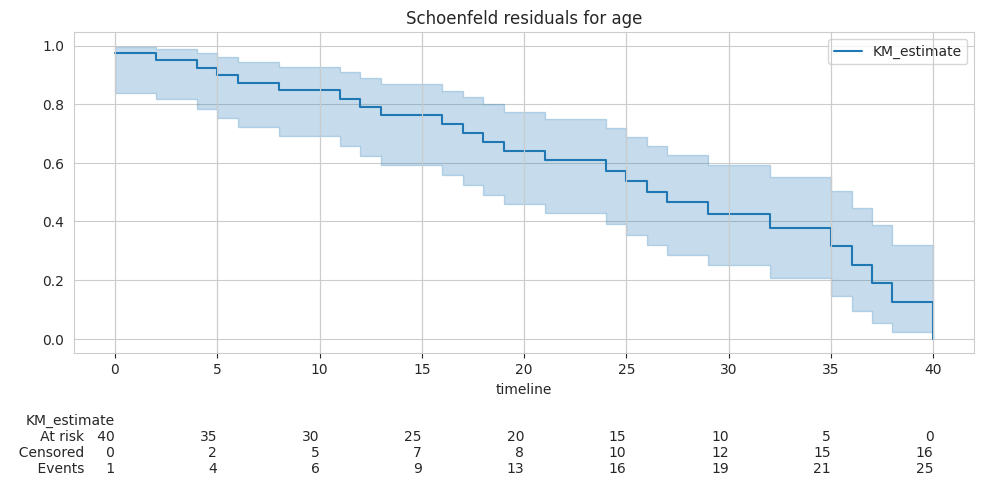

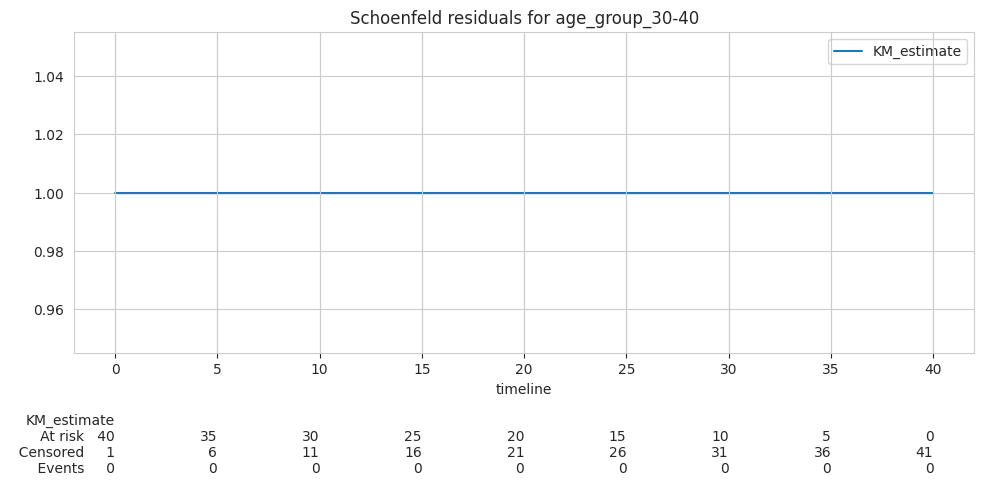

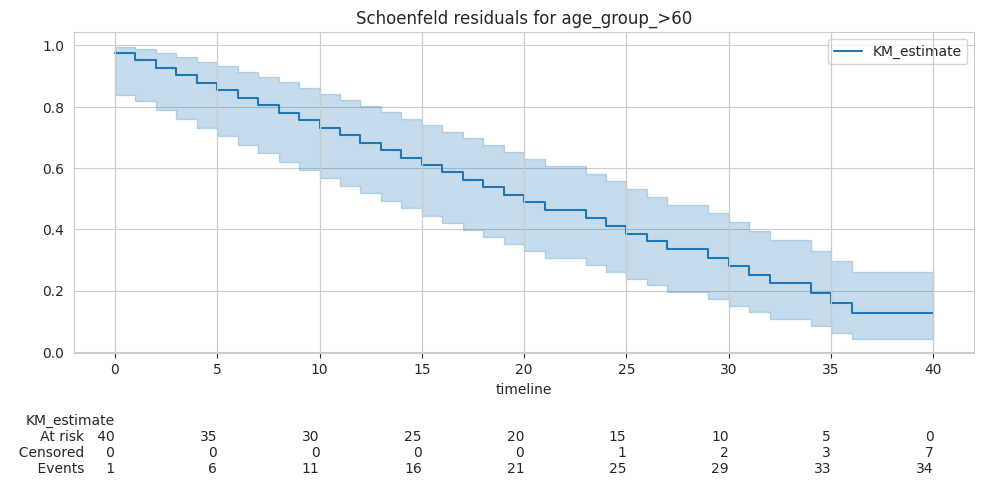

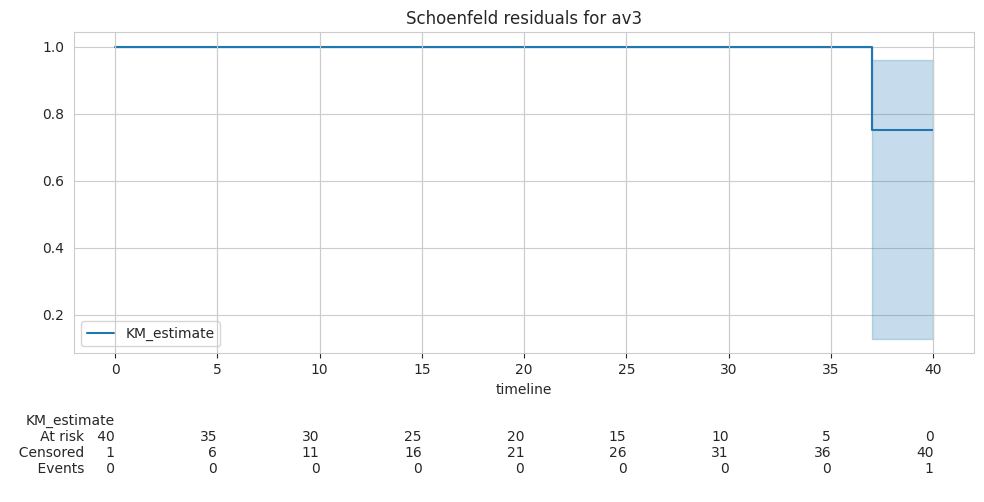

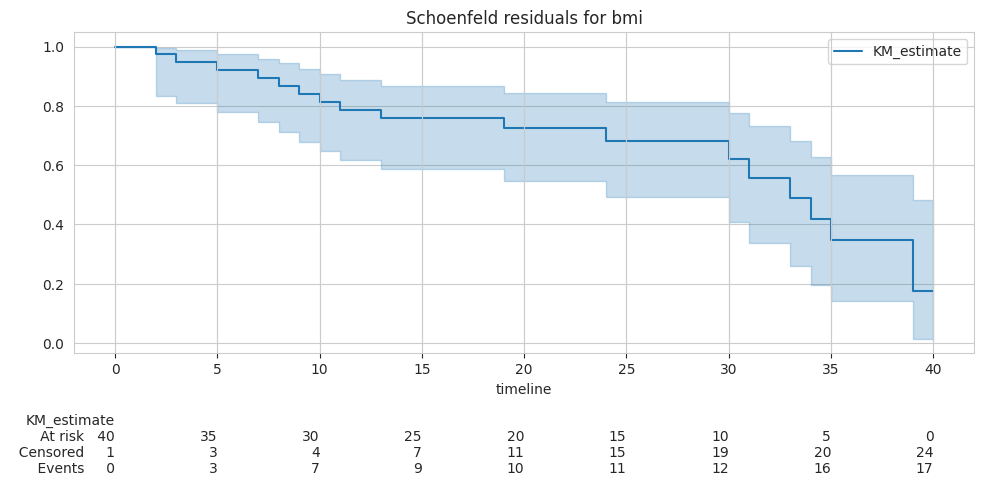

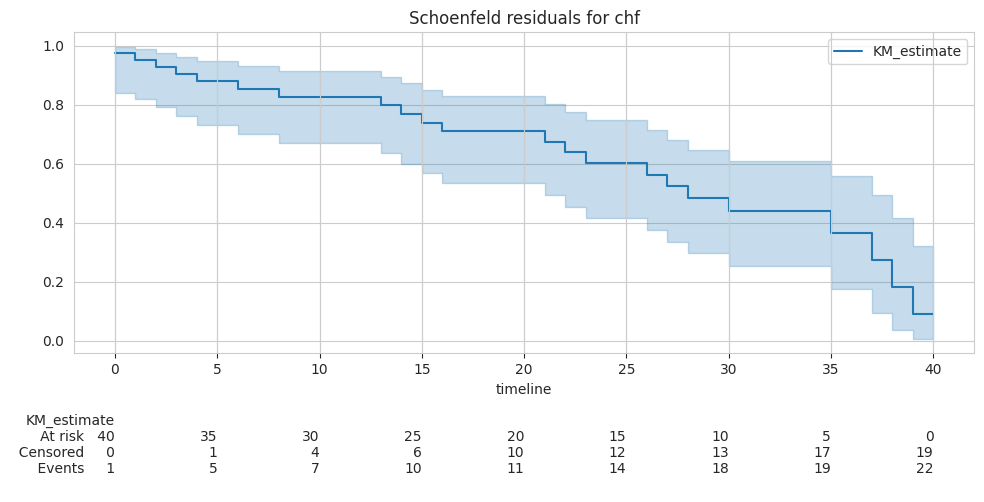

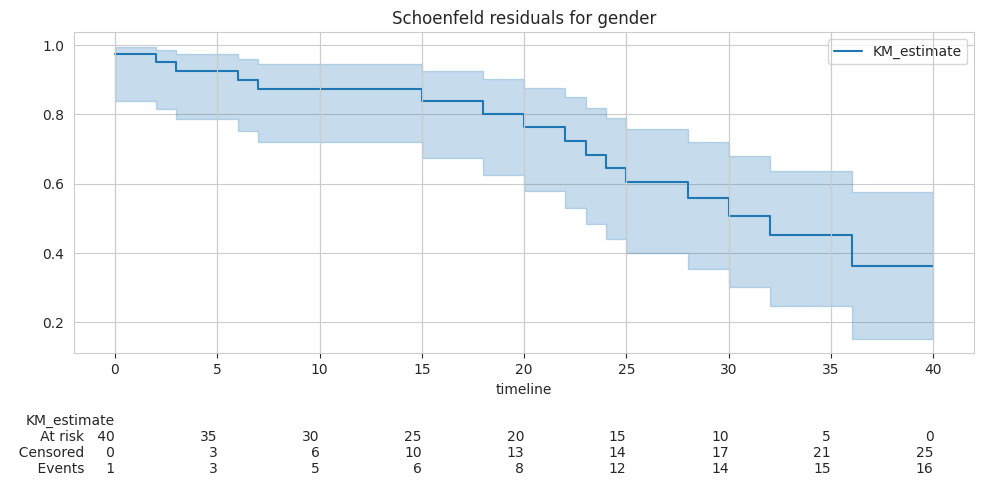

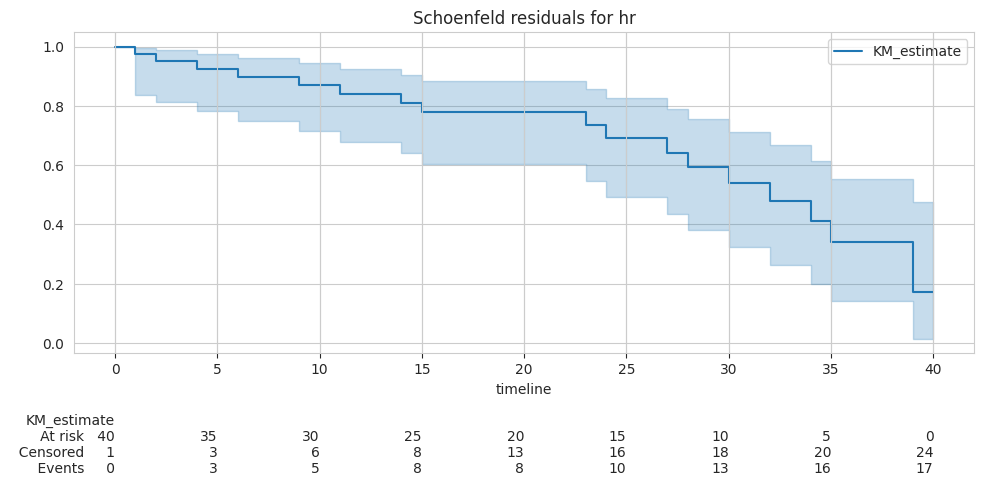

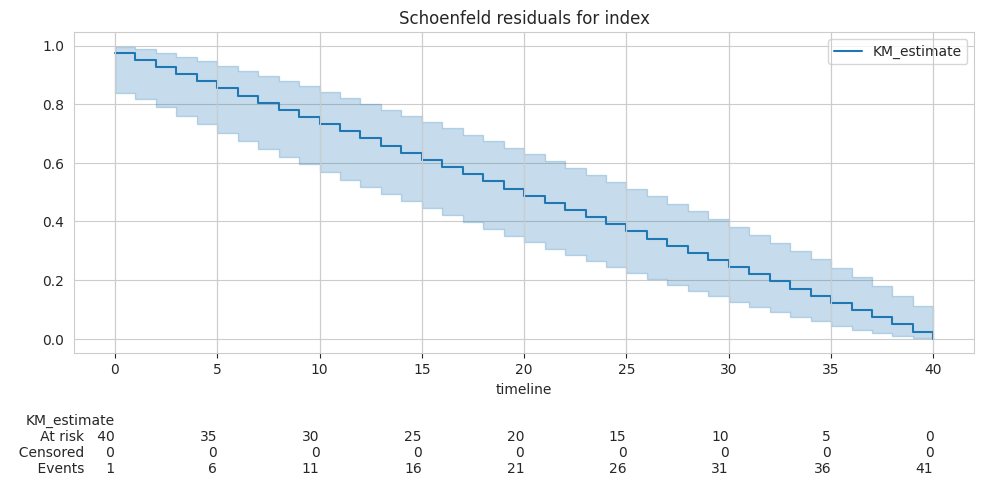

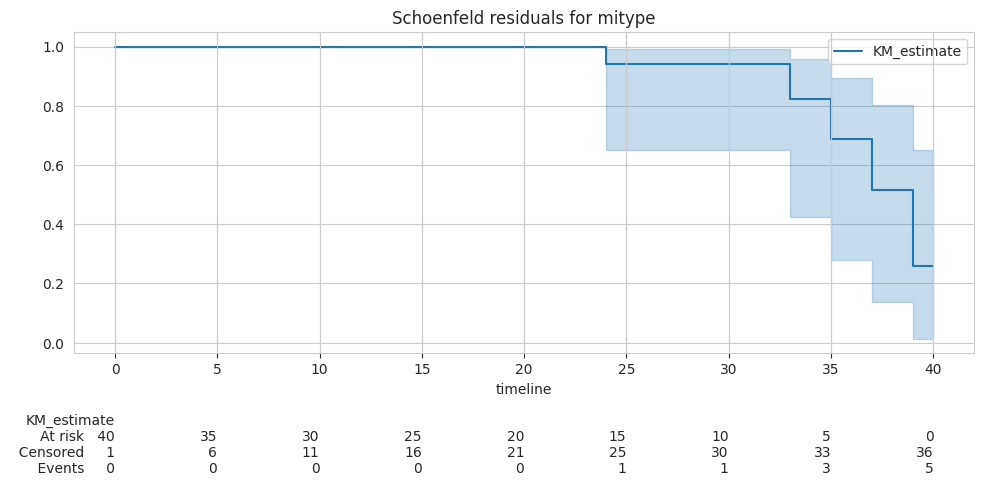

In [ ]:
#### Residual plots

# Obtain scaled Schoenfeld residuals
residuals = cph_model.compute_residuals(train_df_scaled_selected, 'schoenfeld')
residuals = residuals.reset_index()

kmf = KaplanMeierFitter()

# For each covariate, plot the residuals
for covariate in residuals.columns.difference(['event']):
    plt.figure(figsize=(10, 5))
    times = residuals.index
    kmf.fit(times, event_observed=(residuals[covariate] > 0))
    kmf.plot(at_risk_counts=True)
    plt.title(f"Schoenfeld residuals for {covariate}")
    plt.show()

### Model Evaluation

In [ ]:
risk_scores_test = cph_model.predict_partial_hazard(test_df_scaled_selected)

In [ ]:
#### C-Index

# from lifelines.utils import concordance_index
c_index = concordance_index(test_df_scaled_selected[time_col], -cph_model.predict_partial_hazard(test_df_scaled_selected).values, test_df_scaled_selected[event_col])

print(f"CoxPH model Concordance Index (c-index) on training dataset: {train_score:.4f}")
print(f"CoxPH model Concordance Index (c-index) on test dataset: {c_index:.4f}")

CoxPH model Concordance Index (c-index) on training dataset: 0.8251
CoxPH model Concordance Index (c-index) on test dataset: 0.8251


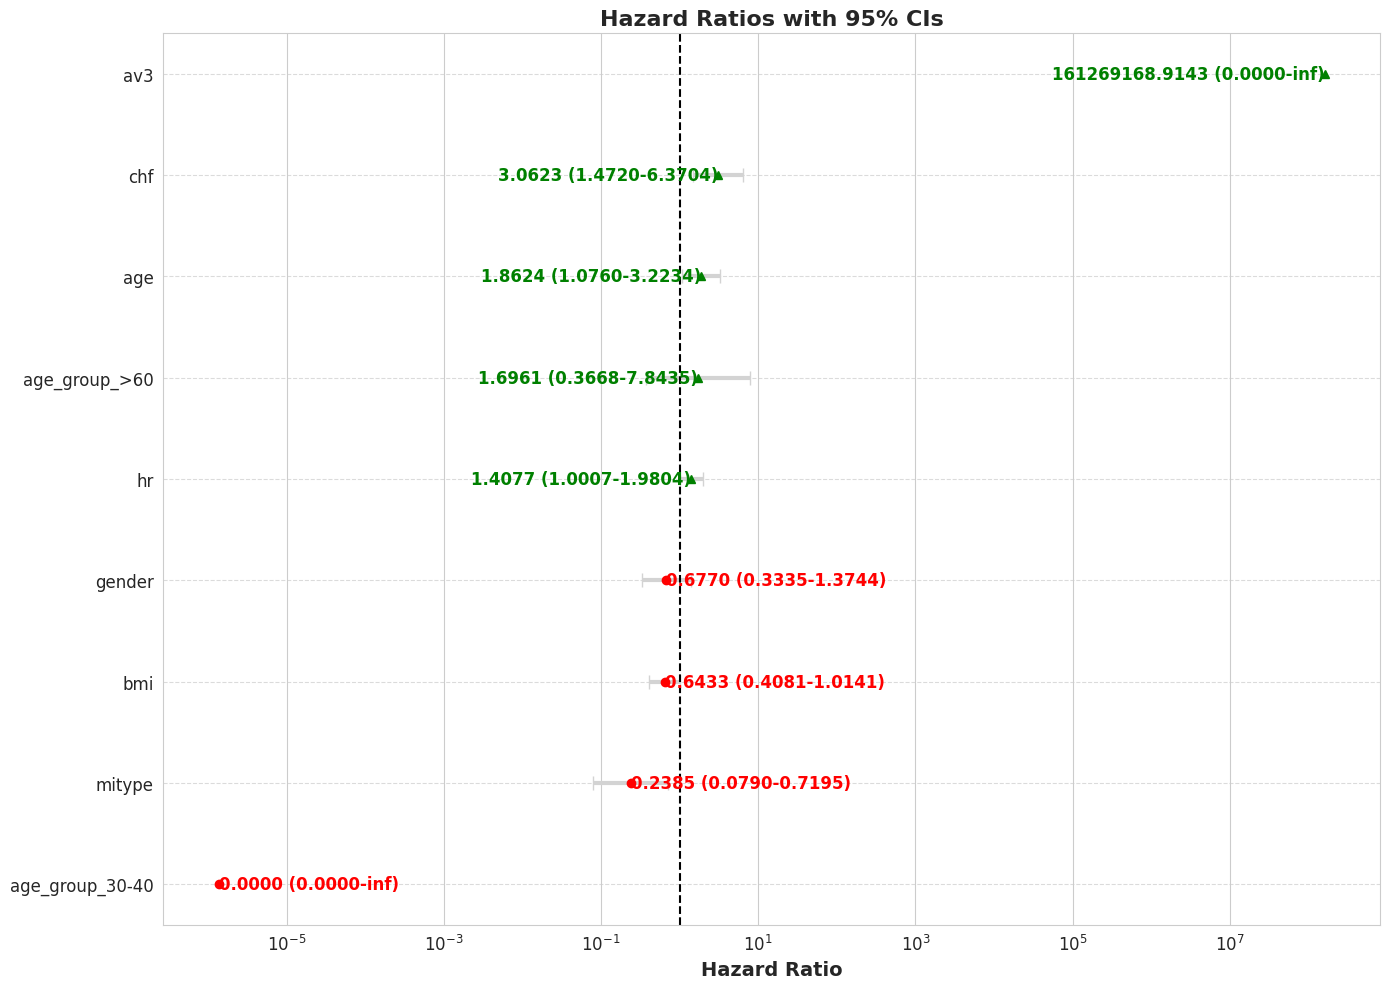

In [ ]:
#### Hazard Ratios

# Get hazard ratios and confidence intervals
hr = cph_model.hazard_ratios_
ci = cph_model.confidence_intervals_

# Sort for better visualization
sorted_vars = hr.sort_values().index
hr_sorted = hr[sorted_vars]
ci_sorted = ci.loc[sorted_vars]

# Plotting
plt.figure(figsize=(14, 10))

colors = ['red' if h < 1 else 'green' for h in hr_sorted]
markers = ['o' if h < 1 else '^' for h in hr_sorted]

for idx, var in enumerate(sorted_vars):
    plt.errorbar(y=idx, x=hr_sorted[var], xerr=[[hr_sorted[var] - np.exp(ci_sorted.loc[var, '95% lower-bound'])], [np.exp(ci_sorted.loc[var, '95% upper-bound']) - hr_sorted[var]]], fmt=markers[idx], color=colors[idx], ecolor='lightgray', elinewidth=3, capsize=5, label=var)
    plt.text(s=f"{hr_sorted[var]:.4f} ({np.exp(ci_sorted.loc[var, '95% lower-bound']):.4f}-{np.exp(ci_sorted.loc[var, '95% upper-bound']):.4f})", x=hr_sorted[var], y=idx, color=colors[idx], va="center", ha="right" if hr_sorted[var] > 1 else "left", fontsize=12, fontweight='bold')

plt.yticks(ticks=np.arange(len(sorted_vars)), labels=sorted_vars, fontsize=12)
plt.xticks(fontsize=12)
plt.xscale("log")
plt.axvline(x=1, color='black', linestyle='--', linewidth=1.5)
plt.title("Hazard Ratios with 95% CIs", fontsize=16, fontweight='bold')
plt.xlabel("Hazard Ratio", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Model Interpretation

**Covariates:**

- `Age (age)`:
Hazard Ratio: 1.8624, Confidence Interval: [0.0733, 1.1704]

Each year increase in a patient's age, the hazard, or the risk of the event of interest (possibly death or an adverse event), increases by 86.24% when holding other variables constant. However, the wide confidence interval indicates uncertainty about this estimate.


- `Third-degree atrioventricular block (av3)`:
Hazard Ratio: 161,269,200, Confidence Interval: [-12,122.86, 12,160.66]

Patients with a third-degree atrioventricular block have an extremely high hazard ratio. The wide confidence interval, spanning negative to positive values, suggests extreme variability and potentially a problematic estimation. This might be due to outliers, sparse data, or issues with the model. Further investigation is needed.


- `Body Mass Index (BMI)`:
Hazard Ratio: 0.6433, Confidence Interval: [-0.8962, 0.0140]

A rise in BMI corresponds to a 35.67% reduction in the risk, implying that a higher BMI may offer some protective benefits in this scenario. However, the span of the confidence interval underscores the uncertainty in this estimation, which should be factored into any decisions.

- `Congestive Heart Failure (chf)`:
Hazard Ratio: 3.0622, Confidence Interval: [0.3866, 1.8517]

Patients diagnosed with congestive heart failure face a risk that's threefold compared to those unaffected. This emphasizes the significant impact of this condition within the scope of our research.

- `Gender (gender)`:
Hazard Ratio: 6.7699, Confidence Interval: [-1.0983, 0.3181]

Female patients have a 32.3% reduced hazard compared to male patients, suggesting a potential protective effect.

- `Heart rate (hr)`:
Hazard Ratio: 1.4078, Confidence Interval: [0.0007, 0.6833]

An increase in heart rate is associated with a 40.78% increase in hazard, emphasizing the importance of monitoring and managing heart rate in patients.

- `MI Type (mitype)`:
Hazard Ratio: 2.3847, Confidence Interval: [-2.5378, -0.3292]

The hazard for patients with a particular type of MI (possibly Q-wave, given the data dictionary) is 76.15% lower than for other types, suggesting a better prognosis.

- `Age Group 30-40 (age_group_30-40)`:
Hazard Ratio: Close to 0, Confidence Interval: Vast and includes negative values

The results suggest that being in the age group 30-40 has a significantly reduced hazard. Still, the confidence interval needs to be broader and more robust, indicating potential issues with the data or model for this age group.

- `Age Group >60 (age_group_>60)`:
Hazard Ratio: 1.6961, Confidence Interval: [-1.0031, 2.0597]

Patients older than 60 have a 69.61% increased hazard compared to the reference group, highlighting the increased risk for older individuals.


**Business Implications:**

- Risk Management: Understanding these hazard ratios can help in risk stratification. For example, older patients and those with congestive heart failure should be monitored more closely, given their increased risk.

- Resource Allocation: Resources like specialized care or follow-ups can be directed more towards those at higher risk, like older patients or those with certain medical conditions like CHF.

- Further Research: Some variables like av3 have problematic estimates and need further investigation. Understanding these can lead to more accurate risk models in the future.

Text(0.5, 1.0, 'ROC Curve')

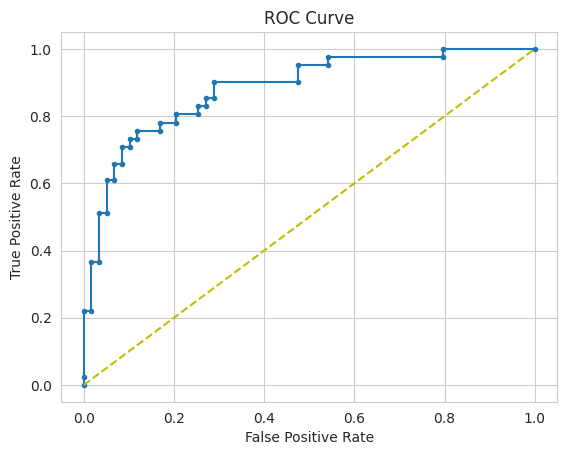

In [ ]:
#### ROC Analysis

from sklearn.metrics import roc_curve

fpr, tpr, thresholds= roc_curve(test_df_scaled_selected[event_col],risk_scores_test)
plt.plot(fpr, tpr, marker=".")
plt.plot([0,1], [0,1], 'y--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

<a name="nn-whas"></a>
## Non-linear Survival Analysis with Neural Networks
[Back to Top](#toc)



Remember, Cox's proportional hazards model is a linear model, i.e., the predicted risk score is a linear combination of features. However, the model can easily be extended to the non-linear case by just replacing the linear predictor with the output of a neural network with parameters $\theta$.

In [ ]:
# Convert boolean columns to int
def convert_bool_cate_to_int(df):
    for col in df.select_dtypes(include=[bool]).columns:
        df[col] = df[col].astype(int)
    for col in df.select_dtypes(include=['category', 'object']).columns:
        df[col] = df[col].astype('category').cat.codes
    return df


In [ ]:
nn_train_set = convert_bool_cate_to_int(train_df_scaled.copy())
nn_test_set = convert_bool_cate_to_int(test_df_scaled.copy())

### PyCox

In [ ]:
# Split the Data

# Extract features and targets from nn_train_set
X_train_full = nn_train_set.drop(columns=[time_col, event_col])
Y_duration_train_full = nn_train_set[time_col]
Y_event_train_full = nn_train_set[event_col]

# Splitting into training and validation
X_train, X_val, Y_duration_train, Y_duration_val, Y_event_train, Y_event_val = train_test_split(
    X_train_full, Y_duration_train_full, Y_event_train_full, test_size=0.2, random_state=n_random_state)

# Extracting features and targets from nn_test_set
X_test = nn_test_set.drop(columns=[time_col, event_col])
Y_duration_test = nn_test_set[time_col]
Y_event_test = nn_test_set[event_col]

In [ ]:
# Convert dataframe to PyTorch tensors

X_train = torch.tensor(X_train.values, dtype=torch.float)
Y_duration_train = torch.tensor(Y_duration_train.values, dtype=torch.float)
Y_event_train = torch.tensor(Y_event_train.values, dtype=torch.float)

X_val = torch.tensor(X_val.values, dtype=torch.float)
Y_duration_val = torch.tensor(Y_duration_val.values, dtype=torch.float)
Y_event_val = torch.tensor(Y_event_val.values, dtype=torch.float)

X_test = torch.tensor(X_test.values, dtype=torch.float)
Y_duration_test = torch.tensor(Y_duration_test.values, dtype=torch.float)
Y_event_test = torch.tensor(Y_event_test.values, dtype=torch.float)

Y_train = (Y_duration_train, Y_event_train)
Y_val = (Y_duration_val, Y_event_val)
Y_test = (Y_duration_test, Y_event_test)

In [ ]:
torch.manual_seed(n_random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(n_random_state)
    torch.cuda.manual_seed_all(n_random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Neural Network Architecture
in_features = X_train.shape[1]
num_nodes = [128, 128]
out_features = 1
dropout = 0.3

net = nn.Sequential(
    nn.Linear(in_features, num_nodes[0]),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(num_nodes[0], num_nodes[1]),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(num_nodes[1], out_features)
)

pycox_model = pycox.models.CoxPH(net, torch.optim.Adam)
batch_size = 256
pycox_model.fit(X_train, Y_train, batch_size, epochs=20, callbacks=[], verbose=True, val_data=(X_val, Y_val))


0:	[0s / 0s],		train_loss: 3.9697,	val_loss: 2.6432
1:	[0s / 0s],		train_loss: 3.9038,	val_loss: 2.6116
2:	[0s / 0s],		train_loss: 3.8752,	val_loss: 2.5810
3:	[0s / 0s],		train_loss: 3.8317,	val_loss: 2.5500
4:	[0s / 0s],		train_loss: 3.8243,	val_loss: 2.5193
5:	[0s / 0s],		train_loss: 3.7969,	val_loss: 2.4885
6:	[0s / 0s],		train_loss: 3.7491,	val_loss: 2.4580
7:	[0s / 0s],		train_loss: 3.7286,	val_loss: 2.4274
8:	[0s / 0s],		train_loss: 3.7066,	val_loss: 2.3966
9:	[0s / 0s],		train_loss: 3.7051,	val_loss: 2.3653
10:	[0s / 0s],		train_loss: 3.6681,	val_loss: 2.3336
11:	[0s / 0s],		train_loss: 3.6554,	val_loss: 2.3015
12:	[0s / 0s],		train_loss: 3.6112,	val_loss: 2.2690
13:	[0s / 0s],		train_loss: 3.6141,	val_loss: 2.2362
14:	[0s / 0s],		train_loss: 3.5542,	val_loss: 2.2035
15:	[0s / 0s],		train_loss: 3.5277,	val_loss: 2.1706
16:	[0s / 0s],		train_loss: 3.5124,	val_loss: 2.1382
17:	[0s / 0s],		train_loss: 3.4654,	val_loss: 2.1064
18:	[0s / 0s],		train_loss: 3.3998,	val_loss: 2.0749
19:

In [ ]:
# Add is_monotonic attribute to pandas Series class
if not hasattr(pd.Series, 'is_monotonic'):
    pd.Series.is_monotonic = property(lambda self: self.is_monotonic_increasing)


# Convert tensors back to numpy arrays
Y_duration_test_np = Y_duration_test.numpy()
Y_event_test_np = Y_event_test.numpy()


_ = pycox_model.compute_baseline_hazards()
surv = pycox_model.predict_surv_df(X_test)
ev = EvalSurv(surv, Y_duration_test_np, Y_event_test_np, censor_surv='km')
c_index = ev.concordance_td()
print(f"C-index: {c_index}")

C-index: 0.818307426597582


<a name="conclusion"></a>
# Conclusion
[Back to Top](#toc)

Our project aimed to leverage survival analysis, specifically the Cox proportional hazards regression model (Cox-PH), to identify members diagnosed with chronic diseases or comorbidities who are most at risk of death. Our focus on health insurance organizations was to ensure both the well-being of members and the financial sustainability of the organizations. The findings from the research are multifaceted and offer valuable insights into healthcare management, risk assessment, and cost efficiency.

### Enhanced Preventive Care and Improved Quality of Care

We demonstrated that survival analysis could lead to personalized care plans and targeted preventive care strategies. By identifying high-risk members, health plans can manage conditions more effectively, potentially slowing disease progression and improving quality of life. The findings from the Cox-PH model, such as the significant risk associated with depression or gender, can guide these personalized interventions.

### Profitability and Resource Optimization

Our project emphasized the financial implications of identifying high-risk members. Implementing preventive measures and disease management programs can reduce high-cost care like hospitalizations and emergency room visits. The insights from the model, such as the importance of regular outpatient visits and medication compliance, can guide resource allocation, improving efficiency, and reducing costs.

### Financial Forecasting and Improved Risk Stratification

The proposed model's ability to aid in financial forecasting and risk stratification is a significant contribution. By predicting adverse events, insurers can estimate future healthcare costs and inform pricing strategies. The insights into factors like race and inpatient admissions can help in proactive risk identification, potentially reducing the Medical Loss Ratio (MLR), a critical metric for insurers.

### Federal Reimbursements

The model's potential to increase federal reimbursement through programs like HEDIS is another key finding. By improving care for high-risk individuals, health plans can enhance their performance scores, leading to higher federal reimbursements.

### Medical Claims and Administrative Data

The integration and analysis of claims and administrative data can enable health insurance organizations to create personalized health programs, forecast future healthcare needs, detect fraudulent activities, and optimize resource allocation. This data-driven approach aligns with the our projects emphasis on personalized care and efficiency.

### Interpretation of Cox-PH Models

The detailed interpretation of the Cox-PH models for both CMS Data and WHAS Data provided valuable insights:

- **CMS Data**: The findings highlighted the importance of gender, depression, regular hospital visits, medication compliance, and race in determining risk. Some coefficients, like those related to race, required further investigation due to instability.

- **WHAS Data**: The analysis revealed the significance of age, certain medical conditions like congestive heart failure, gender, heart rate, and MI type in risk assessment. Some variables, like the third-degree atrioventricular block, had problematic estimates, indicating a need for further research.

### Business Implications

Our project offers actionable insights for patient care, risk management, resource allocation, and additional areas of research. Understanding risk factors, prioritizing interventions, directing specialized care, and investigating problematic estimates can lead to more accurate risk models and improved patient outcomes.

### Limitations and Future Directions

Some limitations were observed in the interpretation of certain variables, such as those with wide confidence intervals or unstable estimates. These areas require further investigation and possibly refinement of the model.

### Final Thoughts

Our project has successfully demonstrated the applicability and flexibility of survival analysis in real-life healthcare scenarios. By identifying key risk factors and providing actionable insights, our research contributes to enhancing patient care, optimizing resources, improving financial forecasting, and increasing federal reimbursements. The findings pave the way for a more personalized, efficient, and financially sustainable healthcare system, aligning with the dual purpose of health insurance organizations. The insights gained from this project can be instrumental in shaping future healthcare policies, strategies, and interventions, ultimately leading to improved quality of care and well-being for health plan members.

<a name="references-1"></a>
# References
[Back to Top](#toc)

1. "Downloadable Public Use Files (SynPUFs) DE_Syn_PUF." Centers for Medicare & Medicaid Services. Accessed 2023-07-02. https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.

2. "Evaluating Survival Models." scikit-survival, 2023-08-02. https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html.

3. Goel, Manish Kumar, Pardeep Khanna, and Jugal Kishore. "Understanding survival analysis: Kaplan-Meier estimate." International journal of Ayurveda research 1, no. 4 (2010): 274.

4. Floyd, Kevin C., Jorge Yarzebski, Frederick A. Spencer, Darleen Lessard, James E. Dalen, Joseph S. Alpert, Joel M. Gore, and Robert J. Goldberg. "A 30-year perspective (1975–2005) into the changing landscape of patients hospitalized with initial acute myocardial infarction: Worcester Heart Attack Study." Circulation: Cardiovascular Quality and Outcomes 2, no. 2 (2009): 88-95.

5. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

6. Katzman, Jared L., Uri Shaham, Alexander Cloninger, Jonathan Bates, Tingting Jiang, and Yuval Kluger. "DeepSurv: personalized treatment recommender system using a Cox proportional hazards deep neural network." _BMC medical research methodology_ 18, no. 1 (2018): 1-12.

7. Kvamme, Haavard. "pycox." GitHub, 2023-07-24. https://github.com/havakv/pycox.

8. Pölsterl, Sebastion. "Survival Analysis for Deep Learning." K-D-W.org (blog), July 2019. https://k-d-w.org/blog/2019/07/survival-analysis-for-deep-learning/.

9. Zheng, Lillian, Nathan J. Smith, Bi Qing Teng, Aniko Szabo, and David L. Joyce. "Predictive model for heart failure readmission using nationwide readmissions database."Mayo Clinic Proceedings: Innovations, Quality & Outcomes 6, no. 3 (2022): 228-238.

